# Convert Simulation Log (JSON) to CSV

In [ ]:
# simulation_root = "C:/kerta/AppData/LocalLow/DefaultCompany/Sumobot/Simulation"
# output_folder = "D:/Simulation_CSV"
simulation_root = "/Users/defdef/Library/Application Support/DefaultCompany/Sumobot/Simulation"
csv_folder = "/Users/defdef/Documents/Simulation"

## Code

In [ ]:
# CONVERSION CODE

import os
import re
import json
import csv
from glob import glob
import shutil
from tqdm import tqdm

def extract_game_index(filename: str) -> int:
    """Extract numeric index from filename like 'game_001.json'."""
    match = re.search(r"game_(\d+)", filename)
    return int(match.group(1)) if match else -1


def escape_csv(value: str) -> str:
    """Escape CSV fields like C# version."""
    if any(c in value for c in [',', '"', '\n']):
        return '"' + value.replace('"', '""') + '"'
    return value


def safe_int(value, default="") -> str:
    """Convert to int string, return default if None/empty."""
    if value is None or value == "":
        return default
    try:
        return str(int(value))
    except (ValueError, TypeError):
        return default


def safe_float(value, default="") -> str:
    """Convert to float string with consistent precision, return default if None/empty."""
    if value is None or value == "":
        return default
    try:
        return f"{float(value):.10g}"  # Use general format, up to 10 significant digits
    except (ValueError, TypeError):
        return default


def safe_bool(value) -> str:
    """Convert boolean to '1' or '0'."""
    return "1" if value else "0"


def safe_str(value, default="") -> str:
    """Convert to string, handling None."""
    if value is None or value == "":
        return default
    return str(value)


def convert_logs_to_csv(folder_path: str, output_path: str):
    """Convert all game_*.json files in folder to one CSV."""
    csv_rows = []

    files = sorted(
        glob(os.path.join(folder_path, "game_*.json")),
        key=lambda f: extract_game_index(os.path.basename(f))
    )

    for file in tqdm(files, desc=f"Processing {folder_path}", ncols=100):
        with open(file, "r", encoding="utf-8") as f:
            root = json.load(f)

        game_index = root.get("Index", -1)
        game_timestamp = root.get("Timestamp", "")
        game_winner = root.get("Winner", "")

        rounds = root.get("Rounds", [])
        for round_data in rounds:
            round_index = round_data.get("Index", -1)
            round_timestamp = round_data.get("Timestamp", "")
            round_winner = round_data.get("Winner", "")

            player_events = round_data.get("PlayerEvents", [])
            for event_log in player_events:
                if event_log.get("Category") == "LastPosition":
                    continue

                row = {
                    "GameIndex": safe_int(game_index + 1),
                    "GameWinner": "2" if game_winner == "Draw" else "0" if game_winner == "Left" else "1",
                    "GameTimestamp": safe_str(game_timestamp),
                    "RoundIndex": safe_int(round_index),
                    "RoundWinner": "2" if round_winner == "Draw" else "0" if round_winner == "Left" else "1",
                    "RoundTimestamp": safe_str(round_timestamp),
                    "StartedAt": safe_float(event_log.get("StartedAt")),
                    "UpdatedAt": safe_float(event_log.get("UpdatedAt")),
                    "Actor": "0" if event_log.get("Actor") == "Left" else "1",
                }

                target = event_log.get("Target", "")
                row["Target"] = "" if target == "" else "0" if target == "Left" else "1"
                row["Category"] = safe_str(event_log.get("Category"))
                row["State"] = safe_str(event_log.get("State"))

                act = event_log.get("Data")
                if act:
                    row["Name"] = safe_str(act.get("Name"))
                    row["Duration"] = safe_float(act.get("Duration"))
                    reason = act.get("Reason")
                    row["Reason"] = "" if reason is None or str(reason) == "None" else safe_str(reason)

                    robot = act.get("Robot")
                    if robot:
                        pos = robot.get("Position", {})
                        row.update({
                            "BotPosX": safe_float(pos.get("X")),
                            "BotPosY": safe_float(pos.get("Y")),
                            "BotLinv": safe_float(robot.get("LinearVelocity")),
                            "BotAngv": safe_float(robot.get("AngularVelocity")),
                            "BotRot": safe_float(robot.get("Rotation")),
                            "BotIsDashActive": safe_bool(robot.get("IsDashActive")),
                            "BotIsSkillActive": safe_bool(robot.get("IsSkillActive")),
                            "BotIsOutFromArena": safe_bool(robot.get("IsOutFromArena")),
                        })

                    enemy = act.get("EnemyRobot")
                    if enemy:
                        pos = enemy.get("Position", {})
                        row.update({
                            "EnemyBotPosX": safe_float(pos.get("X")),
                            "EnemyBotPosY": safe_float(pos.get("Y")),
                            "EnemyBotLinv": safe_float(enemy.get("LinearVelocity")),
                            "EnemyBotAngv": safe_float(enemy.get("AngularVelocity")),
                            "EnemyBotRot": safe_float(enemy.get("Rotation")),
                            "EnemyBotIsDashActive": safe_bool(enemy.get("IsDashActive")),
                            "EnemyBotIsSkillActive": safe_bool(enemy.get("IsSkillActive")),
                            "EnemyBotIsOutFromArena": safe_bool(enemy.get("IsOutFromArena")),
                        })

                if event_log.get("Category") == "Collision":
                    col_data = event_log.get("Data", {})
                    row["ColActor"] = safe_bool(col_data.get("IsActor"))
                    row["ColImpact"] = safe_float(col_data.get("Impact"))
                    row["ColTieBreaker"] = safe_bool(col_data.get("IsTieBreaker"))
                    row["ColLockDuration"] = safe_float(col_data.get("LockDuration"))

                    col_robot = col_data.get("Robot")
                    if col_robot:
                        pos = col_robot.get("Position", {})
                        row.update({
                            "ColBotPosX": safe_float(pos.get("X")),
                            "ColBotPosY": safe_float(pos.get("Y")),
                            "ColBotLinv": safe_float(col_robot.get("LinearVelocity")),
                            "ColBotAngv": safe_float(col_robot.get("AngularVelocity")),
                            "ColBotRot": safe_float(col_robot.get("Rotation")),
                            "ColBotIsDashActive": safe_bool(col_robot.get("IsDashActive")),
                            "ColBotIsSkillActive": safe_bool(col_robot.get("IsSkillActive")),
                            "ColBotIsOutFromArena": safe_bool(col_robot.get("IsOutFromArena")),
                        })

                    col_enemy = col_data.get("EnemyRobot")
                    if col_enemy:
                        pos = col_enemy.get("Position", {})
                        row.update({
                            "ColEnemyBotPosX": safe_float(pos.get("X")),
                            "ColEnemyBotPosY": safe_float(pos.get("Y")),
                            "ColEnemyBotLinv": safe_float(col_enemy.get("LinearVelocity")),
                            "ColEnemyBotAngv": safe_float(col_enemy.get("AngularVelocity")),
                            "ColEnemyBotRot": safe_float(col_enemy.get("Rotation")),
                            "ColEnemyBotIsDashActive": safe_bool(col_enemy.get("IsDashActive")),
                            "ColEnemyBotIsSkillActive": safe_bool(col_enemy.get("IsSkillActive")),
                            "ColEnemyBotIsOutFromArena": safe_bool(col_enemy.get("IsOutFromArena")),
                        })

                csv_rows.append(row)

    # Collect all CSV columns
    preferred_order = [
        "GameIndex","GameWinner","GameTimestamp","RoundIndex","RoundWinner","RoundTimestamp","StartedAt","UpdatedAt","Actor","Target","Category","State","Name","Duration","Reason","BotPosX","BotPosY","BotLinv","BotAngv","BotRot","BotIsDashActive","BotIsSkillActive","BotIsOutFromArena","EnemyBotPosX","EnemyBotPosY","EnemyBotLinv","EnemyBotAngv","EnemyBotRot","EnemyBotIsDashActive","EnemyBotIsSkillActive","EnemyBotIsOutFromArena","ColActor","ColImpact","ColTieBreaker","ColLockDuration","ColBotPosX","ColBotPosY","ColBotLinv","ColBotAngv","ColBotRot","ColBotIsDashActive","ColBotIsSkillActive","ColBotIsOutFromArena","ColEnemyBotPosX","ColEnemyBotPosY","ColEnemyBotLinv","ColEnemyBotAngv","ColEnemyBotRot","ColEnemyBotIsDashActive","ColEnemyBotIsSkillActive","ColEnemyBotIsOutFromArena"
    ]
    # Merge preferred order with dynamically discovered keys
    all_keys = preferred_order + [k for k in {kk for d in csv_rows for kk in d.keys()} if k not in preferred_order]


    with open(output_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(all_keys)
        for row in csv_rows:
            writer.writerow([row.get(k, "") for k in all_keys])

    print(f"✅ Saved CSV: {output_path}")


def convert_all_configs(simulation_root: str, output_root: str):
    """Convert all config folders recursively (Timer_*)."""
    config_folders = []
    for root, dirs, _ in os.walk(simulation_root):
        for d in dirs:
            if d.startswith("Timer_"):
                config_folders.append(os.path.join(root, d))
    
    for i, config_folder in enumerate(config_folders, 1):
        config_name = os.path.basename(config_folder)
        parent_name = os.path.basename(os.path.dirname(config_folder))

        print(f"DEBUG: config_folder = {config_folder}")
        print(f"DEBUG: parent_name = {parent_name}")
        print(f"DEBUG: config_name = {config_name}")

        
        # Create output folder with parent structure if it doesn't exist
        output_folder = os.path.join(output_root, parent_name, config_name)
        os.makedirs(output_folder, exist_ok=True)
        
        output_path = os.path.join(output_folder, f"{config_name}.csv")
        
        if os.path.isfile(output_path):
            print(f"[{i}/{len(config_folders)}] Skipped {config_name} already exists")
            continue
        
        # Check if CSV exists in original location, move it instead of regenerating
        old_csv_path = os.path.join(config_folder, f"{config_name}.csv")
        if os.path.isfile(old_csv_path):
            shutil.move(old_csv_path, output_path)
            print(f"[{i}/{len(config_folders)}] Moved {config_name} to output folder")
            continue
        
        print(f"[{i}/{len(config_folders)}] Processing {config_name}")
        convert_logs_to_csv(config_folder, output_path)
        config_name = os.path.basename(config_folder)
        
        # Create output folder if it doesn't exist
        output_folder = os.path.join(output_root, parent_name,config_name)
        os.makedirs(output_folder, exist_ok=True)
        
        output_path = os.path.join(output_folder, f"{config_name}.csv")
        
        if os.path.isfile(output_path):
            print(f"[{i}/{len(config_folders)}] Skipped {config_name} already exists")
            continue
        
        # Check if CSV exists in original location, move it instead of regenerating
        old_csv_path = os.path.join(config_folder, f"{config_name}.csv")
        if os.path.isfile(old_csv_path):
            shutil.move(old_csv_path, output_path)
            print(f"[{i}/{len(config_folders)}] Moved {config_name} to output folder")
            continue
        
        print(f"[{i}/{len(config_folders)}] Processing {config_name}")
        convert_logs_to_csv(config_folder, output_path)

## Run Conversion

In [ ]:
convert_all_configs(simulation_root,csv_folder)

# Data Compiling

## Code

In [ ]:
import time
import os
import re
import glob
from functools import lru_cache
import polars as pl
import numpy as np
import pandas as pd  # For pd.cut in time bins

# Check if GPU support is available
GPU_AVAILABLE = False
try:
    # Try a simple GPU operation to check availability
    pl.LazyFrame({"test": [1]}).collect(engine="gpu")
    GPU_AVAILABLE = True
    print("GPU support available - will use GPU acceleration")
except Exception:
    print("Using CPU (GPU not available)")


def collect_with_gpu(lf):
    """Helper to collect LazyFrame with GPU if available"""
    if GPU_AVAILABLE:
        return lf.collect(engine="gpu")
    else:
        return lf.collect()


@lru_cache(maxsize=None)
def parse_config_name_cached(name):
    return parse_config_name(name)


def parse_config_name(config_name: str):
    """Extract structured info from config folder name"""
    segments = config_name.split("__")
    config = {}

    for seg in segments:
        if "_" in seg:
            key, value = seg.split("_", 1)
            config[key] = value
        else:
            config[seg] = True

    for k, v in config.items():
        if isinstance(v, str) and re.match(r"^-?\d+(\.\d+)?$", v):
            config[k] = float(v)

    return config


def process_batch_csvs(csv_paths, batch_checkpoint_dir="batched", time_bin_size=None, compute_timebins=False):
    """
    Process a batch of CSV files and create checkpoint

    Args:
        csv_paths: List of CSV file paths to process
        batch_checkpoint_dir: Directory to save checkpoints
        time_bin_size: Size of time bins (only used if compute_timebins=True)
        compute_timebins: Whether to compute time-binned data

    Returns:
        tuple: (batch_df, action_timebin_df, collision_timebin_df) or (batch_df, None, None)
    """
    os.makedirs(batch_checkpoint_dir, exist_ok=True)

    all_games_list = []
    time_fragment_list = [] if compute_timebins else None
    collision_fragment_list = [] if compute_timebins else None

    for csv_path in csv_paths:
        # Extract bot names and config from path
        # Expected path: base_dir/BotA_vs_BotB/ConfigName/log.csv
        parts = csv_path.split(os.sep)
        matchup_folder = parts[-3]
        config_folder = parts[-2]

        match = re.match(r"(.+)_vs_(.+)", matchup_folder)
        if not match:
            continue
        bot_a, bot_b = match.groups()

        # Parse config
        config = parse_config_name_cached(config_folder)

        # Scan CSV with Polars lazy API
        lf = pl.scan_csv(csv_path)

        # Process game metrics
        game_metrics_lf = process_single_csv_lazy(
            lf,
            bot_a,
            bot_b,
            config.get('Timer'),
            config.get('ActInterval'),
            config.get('Round'),
            config.get('SkillLeft'),
            config.get('SkillRight')
        )

        # Collect the results
        game_metrics_df = collect_with_gpu(game_metrics_lf)
        all_games_list.append(game_metrics_df)

        # Process time bins if requested
        if compute_timebins and time_bin_size:
            # Process action time bins
            action_tb = process_action_timebins_single_csv(
                lf, bot_a, bot_b, config, time_bin_size
            )
            if action_tb:
                time_fragment_list.extend(action_tb)

            # Process collision time bins
            collision_tb = process_collision_timebins_single_csv(
                lf, bot_a, bot_b, config, time_bin_size
            )
            if collision_tb:
                collision_fragment_list.extend(collision_tb)

    # Concatenate all games from this batch
    batch_df = None
    action_timebin_df = None
    collision_timebin_df = None

    if all_games_list:
        batch_df = pl.concat(all_games_list)

    if compute_timebins:
        if time_fragment_list:
            action_timebin_df = pl.DataFrame(time_fragment_list)
        if collision_fragment_list:
            collision_timebin_df = pl.DataFrame(collision_fragment_list)

    return batch_df, action_timebin_df, collision_timebin_df


def process_action_timebins_single_csv(lf, bot_a, bot_b, config, time_bin_size):
    """
    Process action time bins for a single CSV file
    Returns list of time-binned action records
    """
    # Scan and filter for actions
    raw_data = lf.filter(
        (pl.col("Category") == "Action") & (pl.col("State").cast(pl.Int32) != 2)
    ).select([
        "GameIndex", "Actor", "UpdatedAt", "Name"
    ])

    # Add match duration per game
    match_dur_lf = lf.group_by("GameIndex").agg([
        pl.col("UpdatedAt").max().alias("match_duration")
    ])

    raw_data = raw_data.join(match_dur_lf, on="GameIndex", how="left")
    raw_data_df = collect_with_gpu(raw_data)

    time_fragment_list = []

    # Process time bins per game
    for game_idx in raw_data_df['GameIndex'].unique():
        game_df = raw_data_df.filter(pl.col('GameIndex') == game_idx)
        match_dur = game_df['match_duration'][0]

        bins = np.arange(0, match_dur + time_bin_size, time_bin_size)
        if len(bins) < 2:
            continue

        game_pd = game_df.to_pandas()

        for side in [0, 1]:
            actor_data = game_pd[game_pd['Actor'] == side]
            if len(actor_data) == 0:
                continue

            actor_data = actor_data.copy()
            actor_data['TimeBin'] = pd.cut(actor_data['UpdatedAt'], bins=bins,
                                           labels=bins[:-1], include_lowest=True)

            grouped = actor_data.groupby(['TimeBin', 'Name'], observed=False).size().reset_index(name='Count')

            for _, row in grouped.iterrows():
                time_fragment_list.append({
                    'GameIndex': game_idx,
                    'Bot': bot_a if side == 0 else bot_b,
                    'Timer': config.get('Timer'),
                    'ActInterval': config.get('ActInterval'),
                    'Round': config.get('Round'),
                    'SkillLeft': config.get('SkillLeft'),
                    'SkillRight': config.get('SkillRight'),
                    'TimeBin': float(row['TimeBin']),
                    'Action': row['Name'],
                    'Count': row['Count']
                })

    return time_fragment_list


def process_collision_timebins_single_csv(lf, bot_a, bot_b, config, time_bin_size):
    """
    Process collision time bins for a single CSV file
    Returns list of time-binned collision records
    """
    # Scan and filter for collisions
    raw_data = lf.filter(
        (pl.col("Category") == "Collision") & (pl.col("State") == 0)
    ).select([
        "GameIndex", "Actor", "ColTieBreaker", "ColActor", "UpdatedAt"
    ])

    # Add match duration per game
    match_dur_lf = lf.group_by("GameIndex").agg([
        pl.col("UpdatedAt").max().alias("match_duration")
    ])

    raw_data = raw_data.join(match_dur_lf, on="GameIndex", how="left")
    raw_data_df = collect_with_gpu(raw_data)

    collision_fragment_list = []

    # Process collision time bins per game
    for game_idx in raw_data_df['GameIndex'].unique():
        game_df = raw_data_df.filter(pl.col('GameIndex') == game_idx)
        match_dur = game_df['match_duration'][0]

        bins = np.arange(0, match_dur + time_bin_size, time_bin_size)
        if len(bins) < 2:
            continue

        game_pd = game_df.to_pandas()
        game_pd['TimeBin'] = pd.cut(game_pd['UpdatedAt'], bins=bins,
                                   labels=bins[:-1], include_lowest=True)

        for time_bin, bin_data in game_pd.groupby('TimeBin', observed=False):
            actor_L_count = len(bin_data[(bin_data['Actor'] == True) &
                                        (bin_data['ColTieBreaker'] == False) &
                                        (bin_data["ColActor"] == True)])
            # print(f"actor_L_count {actor_L_count}")
            actor_R_count = len(bin_data[(bin_data['Actor'] == False) &
                                        (bin_data['ColTieBreaker'] == False) &
                                        (bin_data["ColActor"] == True)])

            tie = bin_data['ColTieBreaker'].sum() if 'ColTieBreaker' in bin_data.columns else 0

            collision_fragment_list.append({
                'GameIndex': game_idx,
                'Bot_L': bot_a,
                'Bot_R': bot_b,
                'Timer': config.get('Timer'),
                'ActInterval': config.get('ActInterval'),
                'Round': config.get('Round'),
                'SkillLeft': config.get('SkillLeft'),
                'SkillRight': config.get('SkillRight'),
                'TimeBin': float(time_bin),
                'Actor_L': actor_L_count,
                'Actor_R': actor_R_count,
                'Tie': int(tie),
            })

    return collision_fragment_list


def process_single_csv_lazy(lf, bot_a, bot_b, timer, act_interval, round_val, skill_left, skill_right):
    """
    Process a single CSV file using lazy evaluation
    Implements the same aggregation logic as process_all_games_sql
    Each CSV can contain multiple games (GameIndex)
    """

    # Filter for actions only
    action_data = lf.filter(pl.col("Category") == "Action")

    # Compute durations with window function (lag by game/actor/name)
    action_with_lag = action_data.with_columns([
        pl.col("StartedAt").shift(1).over(["GameIndex", "Actor", "Name"], order_by="UpdatedAt").alias("prev_started_at")
    ])

    # Compute actual durations per game/actor/action
    action_durations = action_with_lag.group_by(["GameIndex", "Actor", "Name"]).agg([
        pl.when((pl.col("State").cast(pl.Int32) == 2) & pl.col("prev_started_at").is_not_null())
          .then(pl.col("UpdatedAt") - pl.col("prev_started_at"))
          .otherwise(0)
          .sum()
          .alias("ActualDuration")
    ])

    # Action counts per game/actor/action
    action_counts = action_data.filter(pl.col("State").cast(pl.Int32) != 2).group_by(["GameIndex", "Actor", "Name"]).agg([
        pl.len().alias("action_count")
    ])

    # Collision counts per game
    collision_data = lf.filter(
        (pl.col("Category") == "Collision") & (pl.col("State").cast(pl.Int32) == 0)
    ).group_by("GameIndex").agg([
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("ColTieBreaker").cast(pl.Int32) == 0) & (pl.col("ColActor").cast(pl.Int32) == 1))
          .then(1).otherwise(0).sum().alias("collision_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("ColTieBreaker").cast(pl.Int32) == 0) & (pl.col("ColActor").cast(pl.Int32) == 1))
          .then(1).otherwise(0).sum().alias("collision_R"),
        pl.col("ColTieBreaker").cast(pl.Int32).fill_null(0).sum().alias("collision_tie")
    ])

    # Game metadata (winner and duration per game)
    game_meta = lf.group_by("GameIndex").agg([
        pl.col("GameWinner").first().alias("Winner"),
        pl.col("UpdatedAt").max().alias("MatchDur")
    ])

    # Now aggregate durations and counts to game level
    game_durations = action_durations.group_by("GameIndex").agg([
        pl.when(pl.col("Actor").cast(pl.Int32) == 0).then(pl.col("ActualDuration")).sum().fill_null(0).alias("Duration_L"),
        pl.when(pl.col("Actor").cast(pl.Int32) == 1).then(pl.col("ActualDuration")).sum().fill_null(0).alias("Duration_R"),

        # Per-action durations for left
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "Accelerate")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("Accelerate_Dur_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "TurnLeft")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("TurnLeft_Dur_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "TurnRight")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("TurnRight_Dur_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "Dash")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("Dash_Dur_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "SkillBoost")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("SkillBoost_Dur_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "SkillStone")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("SkillStone_Dur_L"),

        # Per-action durations for right
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "Accelerate")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("Accelerate_Dur_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "TurnLeft")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("TurnLeft_Dur_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "TurnRight")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("TurnRight_Dur_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "Dash")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("Dash_Dur_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "SkillBoost")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("SkillBoost_Dur_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "SkillStone")).then(pl.col("ActualDuration")).sum().fill_null(0).alias("SkillStone_Dur_R"),
    ])

    # Aggregate action counts to game level
    game_counts = action_counts.group_by("GameIndex").agg([
        pl.when(pl.col("Actor").cast(pl.Int32) == 0).then(pl.col("action_count")).sum().fill_null(0).alias("ActionCounts_L"),
        pl.when(pl.col("Actor").cast(pl.Int32) == 1).then(pl.col("action_count")).sum().fill_null(0).alias("ActionCounts_R"),
        pl.col("action_count").sum().fill_null(0).alias("TotalActions"),

        # Per-action counts for left
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "Accelerate")).then(pl.col("action_count")).sum().fill_null(0).alias("Accelerate_Act_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "TurnLeft")).then(pl.col("action_count")).sum().fill_null(0).alias("TurnLeft_Act_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "TurnRight")).then(pl.col("action_count")).sum().fill_null(0).alias("TurnRight_Act_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "Dash")).then(pl.col("action_count")).sum().fill_null(0).alias("Dash_Act_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "SkillBoost")).then(pl.col("action_count")).sum().fill_null(0).alias("SkillBoost_Act_L"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 0) & (pl.col("Name") == "SkillStone")).then(pl.col("action_count")).sum().fill_null(0).alias("SkillStone_Act_L"),

        # Per-action counts for right
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "Accelerate")).then(pl.col("action_count")).sum().fill_null(0).alias("Accelerate_Act_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "TurnLeft")).then(pl.col("action_count")).sum().fill_null(0).alias("TurnLeft_Act_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "TurnRight")).then(pl.col("action_count")).sum().fill_null(0).alias("TurnRight_Act_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "Dash")).then(pl.col("action_count")).sum().fill_null(0).alias("Dash_Act_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "SkillBoost")).then(pl.col("action_count")).sum().fill_null(0).alias("SkillBoost_Act_R"),
        pl.when((pl.col("Actor").cast(pl.Int32) == 1) & (pl.col("Name") == "SkillStone")).then(pl.col("action_count")).sum().fill_null(0).alias("SkillStone_Act_R"),
    ])

    # Join everything at game level
    final_metrics = game_meta.join(game_durations, on="GameIndex", how="left") \
                              .join(game_counts, on="GameIndex", how="left") \
                              .join(collision_data, on="GameIndex", how="left")

    # Fill nulls for collisions and add metadata
    final_metrics = final_metrics.with_columns([
        pl.col("collision_L").fill_null(0).alias("Collisions_L"),
        pl.col("collision_R").fill_null(0).alias("Collisions_R"),
        pl.col("collision_tie").fill_null(0).alias("Collisions_Tie"),
        pl.lit(bot_a).alias("Bot_L"),
        pl.lit(bot_b).alias("Bot_R"),
        pl.lit(timer).alias("Timer"),
        pl.lit(act_interval).alias("ActInterval"),
        pl.lit(round_val).alias("Round"),
        pl.lit(skill_left).alias("SkillLeft"),
        pl.lit(skill_right).alias("SkillRight")
    ]).drop(["collision_L", "collision_R", "collision_tie"])

    return final_metrics


def create_summary_matchup(all_games):
    """Create matchup summary using Polars with GPU acceleration"""
    group_cols = ["Bot_L", "Bot_R", "Timer", "ActInterval", "Round", "SkillLeft", "SkillRight"]

    # Find all action-specific columns
    action_cols = [col for col in all_games.columns if any(col.endswith(suffix) for suffix in ("_Act_L", "_Act_R", "_Dur_L", "_Dur_R"))]

    # Build aggregation list
    agg_list = [
        pl.col("GameIndex").n_unique().alias("Games"),
        (pl.col("Winner") == 0).sum().alias("Winner_L"),
        (pl.col("Winner") == 1).sum().alias("Winner_R"),
        pl.col("ActionCounts_L").sum(),
        pl.col("ActionCounts_R").sum(),
        pl.col("TotalActions").sum(),
        pl.col("Duration_L").sum(),
        pl.col("Duration_R").sum(),
        pl.col("Collisions_L").sum(),
        pl.col("Collisions_R").sum(),
        pl.col("Collisions_Tie").sum(),
        pl.col("MatchDur").mean(),
    ]

    # Add all action-specific columns
    for col in action_cols:
        agg_list.append(pl.col(col).sum())

    # Use lazy frames for GPU acceleration
    matchup_summary_lazy = all_games.lazy().group_by(group_cols).agg(agg_list)

    # Add win rates
    matchup_summary_lazy = matchup_summary_lazy.with_columns([
        (pl.col("Winner_L") / pl.col("Games")).alias("WinRate_L"),
        (pl.col("Winner_R") / pl.col("Games")).alias("WinRate_R")
    ])

    matchup_summary = collect_with_gpu(matchup_summary_lazy)

    # Compute bot rankings based on overall performance
    # Aggregate left bots
    bot_summary_L_lazy = matchup_summary.lazy().group_by("Bot_L").agg([
        pl.col("Games").sum().alias("TotalGames"),
        pl.col("Winner_L").sum().alias("TotalWins"),
    ]).rename({"Bot_L": "Bot"})

    # Aggregate right bots
    bot_summary_R_lazy = matchup_summary.lazy().group_by("Bot_R").agg([
        pl.col("Games").sum().alias("TotalGames"),
        pl.col("Winner_R").sum().alias("TotalWins"),
    ]).rename({"Bot_R": "Bot"})

    # Combine and compute ranks
    bot_ranks_lazy = pl.concat([bot_summary_L_lazy, bot_summary_R_lazy]).group_by("Bot").agg([
        pl.col("TotalGames").sum(),
        pl.col("TotalWins").sum(),
    ]).with_columns([
        (pl.col("TotalWins") / pl.col("TotalGames")).alias("WinRate")
    ]).with_columns([
        pl.col("WinRate").rank(descending=True).cast(pl.Int32).alias("Rank")
    ]).select(["Bot", "Rank"])

    bot_ranks = collect_with_gpu(bot_ranks_lazy)

    # Join ranks back to matchup summary
    matchup_summary_lazy = matchup_summary.lazy().join(
        bot_ranks.lazy().rename({"Bot": "Bot_L", "Rank": "Rank_L"}),
        on="Bot_L",
        how="left"
    ).join(
        bot_ranks.lazy().rename({"Bot": "Bot_R", "Rank": "Rank_R"}),
        on="Bot_R",
        how="left"
    ).sort(["Bot_L", "Bot_R", "Timer", "ActInterval"])

    matchup_summary = collect_with_gpu(matchup_summary_lazy)

    # Save to CSV
    matchup_summary.write_csv("summary_matchup.csv")
    print("Saved summary_matchup.csv")

    return matchup_summary


def create_summary_bot(matchup_summary):
    """Create bot summary using Polars with GPU acceleration"""

    # Use lazy frames for GPU acceleration
    # First, normalize the data so each row represents one bot in one game
    bot_summary_L_lazy = matchup_summary.lazy().select([
        pl.col("Bot_L").alias("Bot"),
        pl.col("Games"),
        pl.col("Winner_L").alias("Wins"),
        pl.col("Duration_L").alias("Duration"),
        pl.col("ActionCounts_L").alias("TotalActions"),
        pl.col("Collisions_L").alias("Collisions_Own"),
        pl.col("Collisions_Tie"),
    ])

    bot_summary_R_lazy = matchup_summary.lazy().select([
        pl.col("Bot_R").alias("Bot"),
        pl.col("Games"),
        pl.col("Winner_R").alias("Wins"),
        pl.col("Duration_R").alias("Duration"),
        pl.col("ActionCounts_R").alias("TotalActions"),
        pl.col("Collisions_R").alias("Collisions_Own"),
        pl.col("Collisions_Tie"),
    ])

    # Combine and calculate per-game averages, then aggregate by bot
    bot_summary_lazy = pl.concat([bot_summary_L_lazy, bot_summary_R_lazy]).with_columns([
        # Calculate per-game averages
        (pl.col("Duration") / pl.col("Games")).alias("Duration_per_game"),
        (pl.col("TotalActions") / pl.col("Games")).alias("Actions_per_game"),
        ((pl.col("Collisions_Own") + pl.col("Collisions_Tie")) / pl.col("Games")).alias("Collisions_per_game"),
        (pl.col("Wins") / pl.col("Games")).alias("WinRate_per_matchup"),
    ]).group_by("Bot").agg([
        pl.col("Games").sum().alias("TotalGames"),
        pl.col("Wins").sum().alias("TotalWins"),
        pl.col("WinRate_per_matchup").mean().alias("WinRate_mean"),
        pl.col("WinRate_per_matchup").std().alias("WinRate_std"),
        pl.col("Duration_per_game").mean().alias("Duration_mean"),
        pl.col("Duration_per_game").std().alias("Duration_std"),
        pl.col("Actions_per_game").mean().alias("Actions_mean"),
        pl.col("Actions_per_game").std().alias("Actions_std"),
        pl.col("Collisions_per_game").mean().alias("Collisions_mean"),
        pl.col("Collisions_per_game").std().alias("Collisions_std"),
    ]).with_columns([
        # Format as "mean (std)" with 2 decimal places
        (pl.col("WinRate_mean").round(2).cast(pl.Utf8) + " (" + pl.col("WinRate_std").round(2).cast(pl.Utf8) + ")").alias("Win-rate"),
        (pl.col("Duration_mean").round(2).cast(pl.Utf8) + " (" + pl.col("Duration_std").round(2).cast(pl.Utf8) + ")").alias("Action Duration"),
        (pl.col("Actions_mean").round(2).cast(pl.Utf8) + " (" + pl.col("Actions_std").round(2).cast(pl.Utf8) + ")").alias("Actions"),
        (pl.col("Collisions_mean").round(2).cast(pl.Utf8) + " (" + pl.col("Collisions_std").round(2).cast(pl.Utf8) + ")").alias("Collisions"),
    ]).with_columns([
        pl.col("WinRate_mean").rank(descending=True).cast(pl.Int32).alias("Rank"),
    ]).select([
        "Rank",
        "Bot",
        "Win-rate",
        "Action Duration",
        "Actions",
        "Collisions"
    ]).sort("Rank")

    bot_summary = collect_with_gpu(bot_summary_lazy)

    # Save
    bot_summary.write_csv("summary_bot.csv")
    print("Saved summary_bot.csv")

    return bot_summary


def compute_collision_time_bins_from_csvs(base_dir, time_bin_size=5):
    """
    Compute time-binned COLLISION data from CSV files.
    """
    # Find all CSV files
    all_csvs = []
    matchup_folders = [f for f in os.listdir(base_dir)
                       if os.path.isdir(os.path.join(base_dir, f))]

    for matchup_folder in matchup_folders:
        matchup_path = os.path.join(base_dir, matchup_folder)
        config_folders = [f for f in os.listdir(matchup_path)
                         if os.path.isdir(os.path.join(matchup_path, f))]

        for config_folder in config_folders:
            config_path = os.path.join(matchup_path, config_folder)
            csv_files = glob.glob(os.path.join(config_path, "*.csv"))
            all_csvs.extend([(csv, matchup_folder, config_folder) for csv in csv_files])

    print(f" Computing time-binned collision data from {len(all_csvs)} CSV files...")

    collision_fragment_list = []

    for csv_path, matchup_folder, config_folder in all_csvs:
        match = re.match(r"(.+)_vs_(.+)", matchup_folder)
        if not match:
            continue
        bot_a, bot_b = match.groups()

        config = parse_config_name_cached(config_folder)

        # Scan and filter for collisions
        lf = pl.scan_csv(csv_path)
        raw_data = lf.filter(
            (pl.col("Category") == "Collision") & (pl.col("State") == 0)
        ).select([
            "GameIndex", "Actor", "ColTieBreaker", "ColActor", "UpdatedAt"
        ])

        # Add match duration per game
        match_dur_lf = lf.group_by("GameIndex").agg([
            pl.col("UpdatedAt").max().alias("match_duration")
        ])

        raw_data = raw_data.join(match_dur_lf, on="GameIndex", how="left")
        raw_data_df = collect_with_gpu(raw_data)

        # Process collision time bins per game
        for game_idx in raw_data_df['GameIndex'].unique():
            game_df = raw_data_df.filter(pl.col('GameIndex') == game_idx)
            match_dur = game_df['match_duration'][0]

            bins = np.arange(0, match_dur + time_bin_size, time_bin_size)
            if len(bins) < 2:
                continue

            game_pd = game_df.to_pandas()
            game_pd['TimeBin'] = pd.cut(game_pd['UpdatedAt'], bins=bins,
                                       labels=bins[:-1], include_lowest=True)

            for time_bin, bin_data in game_pd.groupby('TimeBin', observed=False):
                actor_L_count = len(bin_data[(bin_data['Actor'] == "0") &
                                            (bin_data['ColTieBreaker'] == "0") &
                                            (bin_data["ColActor"] == "1")])
                actor_R_count = len(bin_data[(bin_data['Actor'] == "1") &
                                            (bin_data['ColTieBreaker'] == "0") &
                                            (bin_data["ColActor"] == "1")])

                tie = bin_data['ColTieBreaker'].sum() if 'ColTieBreaker' in bin_data.columns else 0

                collision_fragment_list.append({
                    'GameIndex': game_idx,
                    'Bot_L': bot_a,
                    'Bot_R': bot_b,
                    'Timer': config.get('Timer'),
                    'ActInterval': config.get('ActInterval'),
                    'Round': config.get('Round'),
                    'SkillLeft': config.get('SkillLeft'),
                    'SkillRight': config.get('SkillRight'),
                    'TimeBin': float(time_bin),
                    'Actor_L': actor_L_count,
                    'Actor_R': actor_R_count,
                    'Tie': int(tie),
                })

    collision_fragment_df = pl.DataFrame(collision_fragment_list)
    print(f"Computed {len(collision_fragment_df):,} collision time-binned records")

    return collision_fragment_df


def summarize_action_timebins(time_fragment_df):
    """
    Summarize action time fragment data with GPU acceleration.
    Computes mean counts per bot/config/timebin/action.
    """
    print(" Summarizing action time-binned data...")

    # Use lazy frames for GPU acceleration
    summary_lazy = time_fragment_df.lazy().group_by(
        ['Bot', 'Timer', 'ActInterval', 'Round', 'TimeBin', 'Action']
    ).agg([
        pl.col('Count').mean().alias('MeanCount')
    ]).sort(['Bot', 'Timer', 'ActInterval', 'Round', 'TimeBin', 'Action'])

    summary = collect_with_gpu(summary_lazy)

    # Save CSV
    summary.write_csv("summary_action_timebins.csv")
    print("Saved summary_action_timebins.csv")

    return summary


def summarize_collision_timebins(collision_fragment_df):
    """
    Calculate collision time fragment data with GPU acceleration.
    Aggregates Actor, Target, Tie counts per config/timebin.
    """
    print(" Creating collision detail time-binned data...")

    # Use lazy frames for GPU acceleration
    summary_lazy = collision_fragment_df.lazy().group_by(
        ['Bot_L', 'Bot_R', 'Timer', 'ActInterval', 'Round', 'TimeBin']
    ).agg([
        pl.col('Actor_L').sum().alias('Actor_L'),
        pl.col('Actor_R').sum().alias('Actor_R'),
        pl.col('Tie').sum().alias('Tie'),
    ]).sort(['Bot_L', 'Bot_R', 'Timer', 'ActInterval', 'Round', 'TimeBin'])

    summary = collect_with_gpu(summary_lazy)

    # Save CSV
    summary.write_csv("summary_collision_timebins.csv")
    print("Saved summary_collision_timebins.csv")

    return summary

def batch_process_csvs(base_dir, batch_size=50, checkpoint_dir="batched", time_bin_size=None, compute_timebins=False):
    """
    Process CSVs in batches and save checkpoints
    Similar to generator.py batch() function
    Structure: base_dir/BotA_vs_BotB/ConfigFolder/*.csv

    Args:
        base_dir: Base directory containing simulation data
        batch_size: Number of CSV files per batch
        checkpoint_dir: Directory to save checkpoints
        time_bin_size: Size of time bins (only used if compute_timebins=True)
        compute_timebins: Whether to compute time-binned data
    """
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Create separate checkpoint dirs for timebins if needed
    if compute_timebins:
        action_timebin_dir = os.path.join(checkpoint_dir, "action_timebins")
        collision_timebin_dir = os.path.join(checkpoint_dir, "collision_timebins")
        os.makedirs(action_timebin_dir, exist_ok=True)
        os.makedirs(collision_timebin_dir, exist_ok=True)

    # Find all CSV files grouped by matchup/config
    all_csvs = []
    matchup_folders = [f for f in os.listdir(base_dir)
                       if os.path.isdir(os.path.join(base_dir, f))]

    for matchup_folder in matchup_folders:
        matchup_path = os.path.join(base_dir, matchup_folder)
        config_folders = [f for f in os.listdir(matchup_path)
                         if os.path.isdir(os.path.join(matchup_path, f))]

        for config_folder in config_folders:
            config_path = os.path.join(matchup_path, config_folder)
            csv_files = glob.glob(os.path.join(config_path, "*.csv"))
            all_csvs.extend(csv_files)

    print(f"Found {len(all_csvs)} CSV files to process")

    # Determine which batches are already processed
    processed_batches = set()
    for f in os.listdir(checkpoint_dir):
        match = re.match(r"batch_(\d+)\.csv", f)
        if match:
            processed_batches.add(int(match.group(1)))

    # Process in batches
    total_batches = (len(all_csvs) + batch_size - 1) // batch_size

    for batch_idx in range(total_batches):
        batch_num = batch_idx + 1

        # Skip if already processed
        if batch_num in processed_batches:
            print(f"Skipping batch {batch_num}/{total_batches} (already processed)")
            continue

        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(all_csvs))
        batch_csvs = all_csvs[start_idx:end_idx]

        print(f"\nProcessing batch {batch_num}/{total_batches} ({len(batch_csvs)} files)...")

        batch_df, action_timebin_df, collision_timebin_df = process_batch_csvs(
            batch_csvs, checkpoint_dir, time_bin_size=time_bin_size, compute_timebins=compute_timebins
        )

        # Save game metrics batch
        if batch_df is not None:
            batch_path = os.path.join(checkpoint_dir, f"batch_{batch_num:02d}.csv")
            batch_df.write_csv(batch_path)
            print(f"Saved batch checkpoint: {batch_path}")

        # Save timebin batches if computed
        if compute_timebins:
            if action_timebin_df is not None:
                action_path = os.path.join(action_timebin_dir, f"batch_{batch_num:02d}.csv")
                action_timebin_df.write_csv(action_path)
                print(f"Saved action timebin batch: {action_path}")

            if collision_timebin_df is not None:
                collision_path = os.path.join(collision_timebin_dir, f"batch_{batch_num:02d}.csv")
                collision_timebin_df.write_csv(collision_path)
                print(f"Saved collision timebin batch: {collision_path}")

def generate_timebins_from_batches():
    """
    Generate timebin summaries from batched timebin checkpoints
    Loads batch files and creates final summaries
    """
    print("=" * 60)
    print("🚀 Generating timebin summaries from batches")
    print("=" * 60)

    # Load action timebin batches
    action_batch_files = sorted(glob.glob("batched/action_timebins/batch_*.csv"))
    if action_batch_files:
        print(f"\n📂 Loading {len(action_batch_files)} action timebin batch files...")
        action_lazy_frames = [pl.scan_csv(f) for f in action_batch_files]
        action_timebin_df = collect_with_gpu(pl.concat(action_lazy_frames))
        print(f"Loaded {len(action_timebin_df):,} action timebin records")

        print("\n Creating action time-bin summary...")
        summarize_action_timebins(action_timebin_df)

    # Load collision timebin batches
    collision_batch_files = sorted(glob.glob("batched/collision_timebins/batch_*.csv"))
    if collision_batch_files:
        print(f"\n📂 Loading {len(collision_batch_files)} collision timebin batch files...")
        collision_lazy_frames = [pl.scan_csv(f) for f in collision_batch_files]
        collision_timebin_df = collect_with_gpu(pl.concat(collision_lazy_frames))
        print(f"Loaded {len(collision_timebin_df):,} collision timebin records")

        print("\n Creating collision time-bin summary...")
        summarize_collision_timebins(collision_timebin_df)

    print("\n" + "=" * 60)
    print("🎉 Done! Created:")
    if action_batch_files:
        print("   - summary_action_timebins.csv")
    if collision_batch_files:
        print("   - summary_collision_timebins.csv")
    print("=" * 60)

## Generate Batched CSV

In [ ]:
timebin_size = 5
batch_size = 2 # if there's 156 matchup simulation folder, it will generate 156 / 2 = 78 summarization batch csv

batch_process_csvs(
    csv_folder, 
    batch_size=batch_size,
    time_bin_size=timebin_size,
    compute_timebins=True)

## Generate Final Summarization CSV from Batches

In [ ]:
generate_timebins_from_batches()

# Data Compiling (Arena Heatmap)

## Code

In [ ]:
import time
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
import os
import glob
from tqdm import tqdm

# Check if GPU support is available
GPU_AVAILABLE = False
try:
    # Try a simple GPU operation to check availability
    pl.LazyFrame({"test": [1]}).collect(engine="gpu")
    GPU_AVAILABLE = True
    print("✅ GPU support available - will use GPU acceleration")
except Exception:
    print("✅ Using CPU")


def collect_with_gpu(lf, streaming=True):
    """Helper to collect LazyFrame with GPU if available, otherwise uses CPU with streaming"""
    if GPU_AVAILABLE:
        try:
            return lf.collect(engine="gpu", streaming=streaming)
        except Exception:
            # Fallback to CPU if GPU collection fails
            return lf.collect(streaming=streaming)
    else:
        return lf.collect(streaming=streaming)

# =====================
# Config
# =====================
arena_center = np.array([0.24, 1.97])
arena_radius = 4.73485

# Adjustable parameters
tile_size = 0.7   # Larger = bigger heatmap tiles (lower resolution)
# arrow_size = 50   # Larger = longer arrows

def load_data_chunked(csv_path, chunksize=50000, actor_filter=None):
    """
    Load CSV data using Polars with GPU acceleration and streaming

    Args:
        csv_path: Path to CSV file
        chunksize: Number of rows per chunk (ignored for Polars, kept for API compatibility)
        actor_filter: Filter for specific actor (0 for left, 1 for right, None for both)
    """
    # Scan CSV without schema enforcement - let Polars infer naturally
    # Use ignore_errors to handle inconsistent column types across files
    # rechunk=False reduces memory overhead by avoiding unnecessary rechunking
    lf = pl.scan_csv(csv_path, ignore_errors=True, rechunk=False)

    # Select ONLY required columns to drastically reduce memory usage
    # This is critical for 135GB files - we only load what we need
    lf = lf.select([
        "GameIndex",     # For grouping by game
        "UpdatedAt",     # For time-based analysis
        "Actor",         # For filtering by bot
        "BotPosX",       # X position
        "BotPosY",       # Y position
        "BotRot"         # Rotation (used for null checking)
    ])

    # Filter by actor if specified, casting Actor inline for comparison
    # IMPORTANT: Do this BEFORE collect to reduce memory usage
    if actor_filter is not None:
        lf = lf.filter(pl.col("Actor").cast(pl.Int64) == actor_filter)

    # Drop invalid entries BEFORE collecting to reduce memory footprint
    lf = lf.drop_nulls(subset=["BotPosX", "BotPosY", "BotRot"])

    # Collect with GPU acceleration and streaming enabled
    # streaming=True processes data in batches to avoid OOM
    df = collect_with_gpu(lf, streaming=True)

    return df

def create_heatmap_data(x, y, tile_size):
    """Create heatmap data from position coordinates"""
    if len(x) == 0:
        return None, None, None

    xrange = np.arange(x.min(), x.max() + tile_size, tile_size)
    yrange = np.arange(y.min(), y.max() + tile_size, tile_size)
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[xrange, yrange])

    return heatmap, xedges, yedges

def plot_phase_heatmap(ax, phase_df, phase_name):
    """Plot contour density heatmap for a single phase"""
    if phase_df.is_empty():
        ax.text(0.5, 0.5, f"No data for {phase_name}",
                ha='center', va='center', transform=ax.transAxes)
        return

    x = phase_df["BotPosX"].to_numpy() - arena_center[0]
    y = phase_df["BotPosY"].to_numpy() - arena_center[1]  # Shift by arena center

    # Create 2D kernel density estimation for smooth contours
    if len(x) > 1:
        from scipy.stats import gaussian_kde

        # Create KDE
        try:
            xy = np.vstack([x, y])
            kde = gaussian_kde(xy)

            # Create grid for evaluation (data shifted by arena_center, so center is at origin)
            x_min, x_max = 0 - arena_radius - 1, 0 + arena_radius + 1
            y_min, y_max = 0 - arena_radius - 1, 0 + arena_radius + 1

            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            density = np.reshape(kde(positions).T, xx.shape)

            # Plot filled contours (density heatmap)
            ax.contourf(xx, yy, density, levels=15, cmap="Greens", alpha=0.8, zorder=1)

            # Optionally add contour lines for better definition
            ax.contour(xx, yy, density, levels=5, colors='darkgreen', alpha=0.3, linewidths=0.5, zorder=2)

        except Exception as e:
            # Fallback to scatter if KDE fails
            print(f"Warning: KDE failed for {phase_name}, using scatter plot. Error: {e}")
            ax.scatter(x, y, alpha=0.1, s=1, c='green', zorder=1)

    # Draw arena boundary AFTER contours so it appears on top (data shifted by arena_center)
    arena_center_shifted = np.array([0, 0])  # Center is at origin after shift
    circle = plt.Circle(arena_center_shifted, arena_radius,
                       fill=False, edgecolor="red",
                       linewidth=2, linestyle="--", zorder=3)
    ax.add_artist(circle)

    # Labels & Arena Bounds
    ax.set_title(f"{phase_name}\n(n={len(phase_df):,} samples)")
    ax.set_xlabel("BotPosX (shifted)")
    ax.set_ylabel("BotPosY (shifted)")
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlim(0 - arena_radius - 1, 0 + arena_radius + 1)
    ax.set_ylim(0 - arena_radius - 1, 0 + arena_radius + 1)

    # Add grid
    ax.grid(True, alpha=0.3, zorder=0)


def plot_position_distribution(df_combined, bot_name, actor_position="both"):
    """
    Plot X and Y position distributions in a single frame (overlaid histograms)
    Y values are shifted by -2 since the game starts at y=2

    Args:
        df_combined: Combined Polars DataFrame with bot position data
        bot_name: Name of the bot
        actor_position: Position filter text for title

    Returns:
        matplotlib figure
    """
    if df_combined.is_empty():
        return None

    x = df_combined["BotPosX"].to_numpy() - arena_center[0]
    y = df_combined["BotPosY"].to_numpy() - arena_center[1]  # Shift by arena center

    # Create figure with single subplot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Plot X distribution
    ax.hist(x, bins=30, alpha=0.7, color='green', edgecolor='darkgreen',
            label=f'{bot_name} X', linewidth=0.5)

    # Plot Y distribution (overlaid, shifted)
    ax.hist(y, bins=30, alpha=0.7, color='red', edgecolor='darkred',
            label=f'{bot_name} Y', linewidth=0.5)

    # Customize plot
    position_text = f" ({actor_position} side)" if actor_position != "both" else ""
    ax.set_title(f"Distribution of {bot_name} Positions (Overlayed){position_text}\n(n={len(df_combined):,} samples)",
                fontsize=14, fontweight='bold')
    ax.set_xlabel("Position (shifted by arena center)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    return fig


def plot_joint_heatmap_with_distributions(phase_df, phase_name, bot_name="", actor_position="both"):
    """
    Create a joint plot with contour heatmap and marginal distributions (like seaborn jointplot)
    Y values are shifted by -2 since the game starts at y=2

    Args:
        phase_df: Polars DataFrame with position data for a specific phase
        phase_name: Name of the phase (e.g., "Early Game")
        bot_name: Name of the bot
        actor_position: Position filter text for title

    Returns:
        matplotlib figure
    """
    if phase_df.is_empty():
        return None

    x = phase_df["BotPosX"].to_numpy() - arena_center[0]
    y = phase_df["BotPosY"].to_numpy() - arena_center[1]  # Shift by arena center

    # Create figure with GridSpec for joint plot layout
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

    # Main central plot (contour heatmap)
    ax_main = fig.add_subplot(gs[1:4, 0:3])

    # Top marginal (X distribution)
    ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

    # Right marginal (Y distribution)
    ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

    # Set white background for main axis
    ax_main.set_facecolor('white')

    # Plot contour heatmap on main axis
    if len(x) > 1:
        from scipy.stats import gaussian_kde
        from matplotlib.colors import LinearSegmentedColormap

        try:
            xy = np.vstack([x, y])
            kde = gaussian_kde(xy)

            # Create grid for evaluation (data shifted by arena_center, so center is at origin)
            x_min, x_max = 0 - arena_radius - 1, 0 + arena_radius + 1
            y_min, y_max = 0 - arena_radius - 1, 0 + arena_radius + 1

            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            density = np.reshape(kde(positions).T, xx.shape)

            # Mask low-density areas to keep background white
            threshold = np.percentile(density, 40)  # Mask bottom n% of density
            density_masked = np.ma.masked_where(density < threshold, density)

            # Create custom colormap: white -> light green -> strong dark green (more layers)
            colors_list = [ '#E0FFE0', '#C0FFC0', '#90EE90', '#66DD66',
                          '#32CD32', '#2AAA2A', '#228B22', '#1A6B1A', '#006400']
            n_bins = 256
            cmap = LinearSegmentedColormap.from_list('green_gradient', colors_list, N=n_bins)

            # Plot filled contours with masked data - only areas above threshold
            ax_main.contourf(xx, yy, density_masked, levels=10, cmap=cmap, zorder=1)
            ax_main.contour(xx, yy, density_masked, levels=10, colors='darkgreen', alpha=0.4,
                           linewidths=0.5, zorder=2)

        except Exception as e:
            print(f"Warning: KDE failed for {phase_name}, using scatter plot. Error: {e}")
            ax_main.scatter(x, y, alpha=0.1, s=1, c='green', zorder=1)

    # Draw arena boundary (Y shifted by -2)
    arena_center_shifted = np.array([0, 0])  # Center is at origin after shift
    circle = plt.Circle(arena_center_shifted, arena_radius,
                       fill=False, edgecolor="red",
                       linewidth=2, linestyle="--", zorder=3)
    ax_main.add_artist(circle)

    # Configure main axis
    ax_main.set_xlabel("X Position (shifted)", fontsize=12)
    ax_main.set_ylabel("Y Position (shifted)", fontsize=12)
    ax_main.set_aspect("equal", adjustable="box")
    ax_main.set_xlim(0 - arena_radius - 1, 0 + arena_radius + 1)
    ax_main.set_ylim(0 - arena_radius - 1, 0 + arena_radius + 1)
    ax_main.grid(True, alpha=0.3, zorder=0)

    # Plot marginal distributions
    # Top: X distribution (histogram with KDE line)
    ax_top.hist(x, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5, density=True)

    # Add KDE line for X
    if len(x) > 1:
        try:
            from scipy.stats import gaussian_kde
            kde_x = gaussian_kde(x)
            x_range = np.linspace(x.min(), x.max(), 200)
            ax_top.plot(x_range, kde_x(x_range), 'darkblue', linewidth=2)
        except Exception:
            pass

    ax_top.set_ylabel("Density", fontsize=10)
    ax_top.tick_params(labelbottom=False)
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)

    # Right: Y distribution (histogram with KDE line, rotated)
    ax_right.hist(y, bins=50, color='steelblue', alpha=0.7, edgecolor='black',
                  linewidth=0.5, orientation='horizontal', density=True)

    # Add KDE line for Y
    if len(y) > 1:
        try:
            from scipy.stats import gaussian_kde
            kde_y = gaussian_kde(y)
            y_range = np.linspace(y.min(), y.max(), 200)
            ax_right.plot(kde_y(y_range), y_range, 'darkblue', linewidth=2)
        except Exception:
            pass

    ax_right.set_xlabel("Density", fontsize=10)
    ax_right.tick_params(labelleft=False)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)

    # Add title
    position_text = f" ({actor_position} side)" if actor_position != "both" else ""
    title = f"Contour Heatmap with Marginal Distributions\n{bot_name}{position_text} - {phase_name}\n(n={len(phase_df):,} samples)"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.98)

    return fig

def extract_timer_from_config(config_folder):
    """
    Extract Timer value from config folder name
    e.g., "Timer_15__ActInterval_0.1" -> 15

    Args:
        config_folder: Config folder name

    Returns:
        Timer value as float or None if not found
    """
    import re
    match = re.search(r'Timer_(\d+(?:\.\d+)?)', config_folder)
    if match:
        return float(match.group(1))
    return None


def load_bot_data_from_simulation(base_dir, bot_name, actor_position="left", chunksize=50000, max_configs=None, group_by_timer=False, also_load_distance=False):
    """
    Load all CSV data for a specific bot from the simulation directory

    Args:
        base_dir: Base simulation directory
        bot_name: Name of the bot (e.g., "Bot_BT", "Bot_NN", "Bot_Primitive")
        actor_position: "left" (Actor 0) or "right" (Actor 1) or "both"
        chunksize: Chunk size for reading CSV files
        max_configs: Maximum number of config folders to process (None for all)
        group_by_timer: If True, return dict of {timer_value: DataFrame}, else return combined DataFrame
        also_load_distance: If True, also return timer-grouped distance data

    Returns:
        Combined DataFrame with all bot data, or dict of DataFrames grouped by Timer
        If also_load_distance=True, returns tuple: (bot_data, distance_data)
    """
    all_data = []
    timer_grouped_data = {}  # {timer_value: [dataframes]}
    timer_distance_data = {}  # {timer_value: [distance dataframes]}

    # Find all matchup folders containing this bot
    matchup_folders = [f for f in os.listdir(base_dir)
                      if os.path.isdir(os.path.join(base_dir, f)) and bot_name in f]

    print(f"Found {len(matchup_folders)} matchup folders for {bot_name}")

    total_csvs = 0
    for matchup_folder in matchup_folders:
        matchup_path = os.path.join(base_dir, matchup_folder)

        # Determine actor filter based on bot position in matchup
        # Bot_A_vs_Bot_B: Bot_A is actor 0 (left), Bot_B is actor 1 (right)
        parts = matchup_folder.split("_vs_")
        if len(parts) == 2:
            left_bot = parts[0]
            is_left_bot = (bot_name == left_bot)

            if actor_position == "left" and is_left_bot:
                actor_filter = 0
            elif actor_position == "left" and not is_left_bot:
                continue  # Skip this matchup
            elif actor_position == "right" and not is_left_bot:
                actor_filter = 1
            elif actor_position == "right" and is_left_bot:
                continue  # Skip this matchup
            elif actor_position == "both":
                actor_filter = 0 if is_left_bot else 1
            else:
                continue
        else:
            continue

        # Get all config folders
        config_folders = [f for f in os.listdir(matchup_path)
                         if os.path.isdir(os.path.join(matchup_path, f))]

        if max_configs:
            config_folders = config_folders[:max_configs]

        print(f"  {matchup_folder}: {len(config_folders)} configs")

        # Process each config folder
        for config_folder in tqdm(config_folders, desc=f"  Loading {matchup_folder}", leave=False):
            config_path = os.path.join(matchup_path, config_folder)

            # Find CSV file in this config folder
            csv_files = glob.glob(os.path.join(config_path, "*.csv"))

            if csv_files:
                csv_path = csv_files[0]  # Should only be 1 CSV per config
                df = load_data_chunked(csv_path, chunksize, actor_filter=actor_filter)

                if not df.is_empty():
                    # Also load distance data if requested
                    if also_load_distance:
                        df_all_actors = load_data_chunked(csv_path, chunksize, actor_filter=None)
                        if not df_all_actors.is_empty():
                            dist_df = calculate_distance_between_bots(df_all_actors)
                            if not dist_df.is_empty():
                                timer = extract_timer_from_config(config_folder)
                                if timer is not None:
                                    if timer not in timer_distance_data:
                                        timer_distance_data[timer] = []
                                    timer_distance_data[timer].append(dist_df)

                    if group_by_timer:
                        # Extract timer value and group
                        timer = extract_timer_from_config(config_folder)
                        if timer is not None:
                            if timer not in timer_grouped_data:
                                timer_grouped_data[timer] = []
                            timer_grouped_data[timer].append(df)
                    else:
                        all_data.append(df)
                    total_csvs += 1

    if group_by_timer:
        # Return dict of combined DataFrames per timer
        if not timer_grouped_data:
            print("No valid data found.")
            if also_load_distance:
                return {}, {}
            return {}

        print(f"\nLoaded {total_csvs} CSV files")
        result = {}
        for timer, dfs in timer_grouped_data.items():
            print(f"Combining data for Timer={timer}...")
            result[timer] = pl.concat(dfs, how="vertical_relaxed")
            print(f"  Timer {timer}: {len(result[timer]):,} samples")

        if also_load_distance:
            return result, timer_distance_data
        return result
    else:
        # Return combined DataFrame
        if not all_data:
            print("No valid data found.")
            if also_load_distance:
                return pl.DataFrame(), {}
            return pl.DataFrame()

        print(f"\nLoaded {total_csvs} CSV files")
        print("Combining all data...")
        df_combined = pl.concat(all_data, how="vertical_relaxed")

        print(f"Total samples: {len(df_combined):,}")

        if also_load_distance:
            return df_combined, timer_distance_data
        return df_combined


def calculate_distance_between_bots(df):
    """
    Calculate distance between Bot 1 (Actor 0) and Bot 2 (Actor 1) for each game frame

    Args:
        df: Polars DataFrame with columns including Actor, BotPosX, BotPosY, GameIndex, UpdatedAt

    Returns:
        Polars DataFrame with distance between bots for each frame
    """
    # Split data by actor - cast Actor inline for filtering
    bot1_df = df.filter(pl.col("Actor").cast(pl.Int64) == 0).select([
        "GameIndex", "UpdatedAt", "BotPosX", "BotPosY"
    ]).rename({"BotPosX": "Bot1_X", "BotPosY": "Bot1_Y"})

    bot2_df = df.filter(pl.col("Actor").cast(pl.Int64) == 1).select([
        "GameIndex", "UpdatedAt", "BotPosX", "BotPosY"
    ]).rename({"BotPosX": "Bot2_X", "BotPosY": "Bot2_Y"})

    # Merge on GameIndex and UpdatedAt to align frames
    merged = bot1_df.join(bot2_df, on=["GameIndex", "UpdatedAt"], how="inner")

    # Calculate Euclidean distance
    merged = merged.with_columns([
        (((pl.col("Bot1_X") - pl.col("Bot2_X"))**2 +
          (pl.col("Bot1_Y") - pl.col("Bot2_Y"))**2).sqrt()).alias("Distance")
    ])

    return merged

def calculate_distance_from_center(df):
    """
    Calculate distance from arena center for each bot

    Args:
        df: Polars DataFrame with columns including Actor, BotPosX, BotPosY

    Returns:
        Polars DataFrame with distance from center for each bot
    """
    # Calculate distance from center for each position
    df = df.with_columns([
        (((pl.col("BotPosX") - arena_center[0])**2 +
          (pl.col("BotPosY") - arena_center[1])**2).sqrt()).alias("DistanceFromCenter")
    ])

    return df

def plot_distance_histogram_from_data(distance_data, bot_name, output_path=None):
    """
    Plot histogram of distance between bot and all opponents

    Args:
        distance_data: Dict of {timer: [list of distance dataframes]}
        bot_name: Name of the bot to analyze
        output_path: Path to save the figure

    Returns:
        matplotlib figure
    """
    if not distance_data:
        print("No valid distance data found")
        return None

    # Combine all distance data across all timers and opponents
    all_distances = []
    for timer, dfs in distance_data.items():
        combined_df = pl.concat(dfs, how="vertical_relaxed")
        all_distances.append(combined_df["Distance"].to_numpy())

    # Concatenate all distances
    distances = np.concatenate(all_distances)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot histogram
    ax.hist(distances, bins=30, color='steelblue', edgecolor='black', alpha=0.7, linewidth=0.5)

    # Customize plot
    ax.set_xlabel("Distance Between Bots", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(f"Distribution of Distance Between Bots\n{bot_name} vs All Opponents\n(n={len(distances):,} samples)",
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')

    # Add statistics text
    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    std_dist = np.std(distances)
    stats_text = f"Mean: {mean_dist:.2f}\nMedian: {median_dist:.2f}\nStd: {std_dist:.2f}"
    ax.text(0.98, 0.98, stats_text,
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, family='monospace')

    plt.tight_layout()

    # Save or return
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  Saved distance histogram to {output_path}")

    return fig


def plot_distance_from_center_histogram(bot_data, bot_name, output_path=None):
    """
    Plot histogram of distance from center for a specific bot

    Args:
        bot_data: DataFrame or dict of DataFrames with bot position data
        bot_name: Name of the bot to analyze
        output_path: Path to save the figure

    Returns:
        matplotlib figure
    """
    # Handle both single DataFrame and dict of DataFrames
    if isinstance(bot_data, dict):
        # Combine all timer data
        all_dfs = []
        for timer, df in bot_data.items():
            all_dfs.append(df)
        combined_df = pl.concat(all_dfs, how="vertical_relaxed")
    else:
        combined_df = bot_data

    if combined_df.is_empty():
        print("No valid data found")
        return None

    # Calculate distance from center
    df_with_center_dist = calculate_distance_from_center(combined_df)
    distances = df_with_center_dist["DistanceFromCenter"].to_numpy()

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot histogram
    ax.hist(distances, bins=30, color='green', edgecolor='darkgreen', alpha=0.7, linewidth=0.5)

    # Add arena radius line
    ax.axvline(arena_radius, color='red', linestyle='--', linewidth=2, label=f'Arena Radius ({arena_radius:.2f})')

    # Customize plot
    ax.set_xlabel("Distance from Center", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(f"Distribution of Distance from Center\n{bot_name}\n(n={len(distances):,} samples)",
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')

    # Add statistics text
    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    std_dist = np.std(distances)
    stats_text = f"Mean: {mean_dist:.2f}\nMedian: {median_dist:.2f}\nStd: {std_dist:.2f}"
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes, ha='left', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10, family='monospace')

    plt.tight_layout()

    # Save or return
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  Saved distance from center histogram to {output_path}")

    return fig


def plot_distance_over_time_from_data(timer_data, bot_name, output_path=None):
    """
    Plot mean distance over time from pre-loaded timer-grouped data

    Args:
        timer_data: Dict of {timer: [list of distance dataframes]}
        bot_name: Name of the bot to analyze
        output_path: Path to save the figure

    Returns:
        matplotlib figure
    """
    if not timer_data:
        print("No valid data found")
        return None

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Process each timer value
    colors = plt.cm.tab10(range(len(timer_data)))

    for idx, (timer, dfs) in enumerate(sorted(timer_data.items())):
        # Combine all games for this timer (across all opponents)
        combined_df = pl.concat(dfs, how="vertical_relaxed")

        print(f"  Timer {timer}s: {len(combined_df):,} data points")

        # Calculate mean distance over time bins
        # Bin UpdatedAt into time intervals, but only up to the Timer value
        time_bins = 50  # Number of bins
        # Use the Timer value as the max time for this specific config
        max_time = timer  # Cut at the Timer config value
        bin_size = max_time / time_bins

        # Create time bins and calculate mean distance per bin
        time_points = []
        mean_distances = []
        std_distances = []

        for i in range(time_bins):
            bin_start = i * bin_size
            bin_end = (i + 1) * bin_size

            bin_data = combined_df.filter(
                (pl.col('UpdatedAt') >= bin_start) &
                (pl.col('UpdatedAt') < bin_end)
            )

            if not bin_data.is_empty():
                time_points.append((bin_start + bin_end) / 2)
                mean_distances.append(bin_data['Distance'].mean())
                # Handle None for std (when only 1 data point)
                std_val = bin_data['Distance'].std()
                std_distances.append(std_val if std_val is not None else 0.0)

        # Convert to numpy for plotting
        time_points = np.array(time_points)
        mean_distances = np.array(mean_distances)
        std_distances = np.array(std_distances)

        # Plot line with markers
        timer_label = f"Timer {int(timer)}s" if timer == int(timer) else f"Timer {timer}s"
        ax.plot(time_points, mean_distances, marker='o', markersize=4,
                linewidth=2, label=timer_label, color=colors[idx], alpha=0.8)

        # Add confidence interval (mean ± std)
        ax.fill_between(time_points,
                        mean_distances - std_distances,
                        mean_distances + std_distances,
                        alpha=0.2, color=colors[idx])

    # Customize plot
    ax.set_xlabel("Time (seconds)", fontsize=12)
    ax.set_ylabel("Mean Distance Between Bots", fontsize=12)
    ax.set_title(f"Mean Distance Over Time (vs All Opponents)\n{bot_name}",
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')

    # Limit x-axis to the maximum Timer value found
    max_timer = max(timer_data.keys())
    ax.set_xlim(0, max_timer)

    plt.tight_layout()

    # Save or return
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  Saved distance over time to {output_path}")

    return fig


def create_distance_distributions_all_matchups(base_dir, output_dir="arena_heatmaps", chunksize=50000, max_configs=None, skip_initial=0.0):
    """
    Create distance distribution plots per bot (averaged across all matchups).
    Saves to {output_dir}/{bot_name}/distance_distribution.png

    Args:
        base_dir: Base simulation directory
        output_dir: Output directory (should be arena_heatmaps folder)
        chunksize: Chunk size for reading CSV files
        max_configs: Maximum number of configs to process per matchup
        skip_initial: Skip initial N seconds of data to remove spawn point bias (default: 0.0)
    """
    # Find all matchup folders
    matchup_folders = [f for f in os.listdir(base_dir)
                      if os.path.isdir(os.path.join(base_dir, f)) and "_vs_" in f]

    print(f"Found {len(matchup_folders)} matchup folders")

    # Collect data per bot (across all matchups)
    bot_distance_data = {}  # {bot_name: [distance_between_series, distance_from_center_series]}

    # Process each matchup
    for matchup_folder in matchup_folders:
        print("\n" + "=" * 60)
        print(f"Processing {matchup_folder}")
        print("=" * 60)

        # Extract bot names
        parts = matchup_folder.split("_vs_")
        if len(parts) != 2:
            print(f"  Skipping invalid matchup folder name: {matchup_folder}")
            continue

        bot1_name, bot2_name = parts[0], parts[1]

        # Load data for this matchup
        df = load_all_game_data(base_dir, bot1_name, bot2_name, chunksize, max_configs)

        if df.is_empty():
            print(f"  No data found for {matchup_folder}, skipping...")
            continue

        # Apply skip_initial filter if specified (per game)
        if skip_initial > 0:
            print(f"  ⏩ Skipping initial {skip_initial}s of data per game to remove spawn bias...")
            df = df.filter(
                pl.col("UpdatedAt") >= pl.col("UpdatedAt").min().over("GameIndex") + skip_initial
            )
            if df.is_empty():
                print(f"  No data remaining after skipping initial {skip_initial}s, skipping matchup...")
                continue
            print(f"  Samples after filter: {len(df):,}")

        # Calculate distance between bots
        print("  Calculating distance between bots...")
        dist_between = calculate_distance_between_bots(df)

        # Calculate distance from center for each bot
        print("  Calculating distance from center...")
        df_with_center_dist = calculate_distance_from_center(df)

        # Split by actor - bot1 is actor 0, bot2 is actor 1
        bot1_center_dist = df_with_center_dist.filter(pl.col("Actor").cast(pl.Int64) == 0)["DistanceFromCenter"]
        bot2_center_dist = df_with_center_dist.filter(pl.col("Actor").cast(pl.Int64) == 1)["DistanceFromCenter"]

        # Store data for each bot
        if bot1_name not in bot_distance_data:
            bot_distance_data[bot1_name] = {"between": [], "from_center": []}
        if bot2_name not in bot_distance_data:
            bot_distance_data[bot2_name] = {"between": [], "from_center": []}

        # Add distance between for both bots (it's the same data)
        bot_distance_data[bot1_name]["between"].append(dist_between["Distance"])
        bot_distance_data[bot2_name]["between"].append(dist_between["Distance"])

        # Add distance from center for each bot
        bot_distance_data[bot1_name]["from_center"].append(bot1_center_dist)
        bot_distance_data[bot2_name]["from_center"].append(bot2_center_dist)

    # Create distance distribution plot for each bot
    for bot_name, data in bot_distance_data.items():
        print("\n" + "=" * 60)
        print(f"Creating distance distribution for {bot_name}...")
        print("=" * 60)

        # Concatenate all data for this bot
        combined_between = pl.concat(data["between"])
        combined_from_center = pl.concat(data["from_center"])

        between_numpy = combined_between.to_numpy()
        from_center_numpy = combined_from_center.to_numpy()

        # Create 2-subplot figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot 1: Distance between bots (averaged across all matchups)
        ax1.hist(between_numpy, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        ax1.set_title(f"Distance Between {bot_name} and Opponents (All Matchups)", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Distance Between Bots", fontsize=12)
        ax1.set_ylabel("Frequency", fontsize=12)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.text(0.98, 0.98, f"n={len(between_numpy):,}",
                transform=ax1.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Plot 2: Distance from center
        ax2.hist(from_center_numpy, bins=30, color='green', edgecolor='black', alpha=0.7)
        ax2.set_title(f"Distance from Center: {bot_name}", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Distance from Center", fontsize=12)
        ax2.set_ylabel("Frequency", fontsize=12)
        ax2.grid(True, alpha=0.3, linestyle='--')

        # Add arena radius reference line
        ax2.axvline(x=arena_radius, color='red', linestyle='--', linewidth=2,
                   label=f'Arena Radius ({arena_radius:.2f})', alpha=0.8)
        ax2.legend(loc='upper right', fontsize=10)

        ax2.text(0.98, 0.98, f"n={len(from_center_numpy):,}",
                transform=ax2.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()

        # Save to bot's folder
        bot_output_dir = os.path.join(output_dir, bot_name)
        os.makedirs(bot_output_dir, exist_ok=True)
        output_path = os.path.join(bot_output_dir, "distance_distribution.png")
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  Saved to {output_path}")
        plt.close(fig)

    print("\n" + "=" * 60)
    print(f"✅ Completed! Distance distribution plots saved in bot folders")
    print("=" * 60)

def load_all_game_data(base_dir, bot1_name=None, bot2_name=None, chunksize=50000, max_configs=None):
    """
    Load all game data from simulation directory, optionally filtered by bot matchup

    Args:
        base_dir: Base simulation directory
        bot1_name: Name of bot 1 (optional filter)
        bot2_name: Name of bot 2 (optional filter)
        chunksize: Chunk size for reading CSV files
        max_configs: Maximum number of configs to process (None for all)

    Returns:
        DataFrame with all game data including both actors
    """
    all_data = []

    # Find matchup folders
    if bot1_name and bot2_name:
        # Specific matchup
        matchup_folder = f"{bot1_name}_vs_{bot2_name}"
        matchup_folders = [matchup_folder] if os.path.exists(os.path.join(base_dir, matchup_folder)) else []
    else:
        # All matchups
        matchup_folders = [f for f in os.listdir(base_dir)
                          if os.path.isdir(os.path.join(base_dir, f)) and "_vs_" in f]

    print(f"Found {len(matchup_folders)} matchup folders")

    total_csvs = 0
    for matchup_folder in matchup_folders:
        matchup_path = os.path.join(base_dir, matchup_folder)

        # Get all config folders
        config_folders = [f for f in os.listdir(matchup_path)
                         if os.path.isdir(os.path.join(matchup_path, f))]

        if max_configs:
            config_folders = config_folders[:max_configs]

        print(f"  {matchup_folder}: {len(config_folders)} configs")

        # Process each config folder
        for config_folder in tqdm(config_folders, desc=f"  Loading {matchup_folder}", leave=False):
            config_path = os.path.join(matchup_path, config_folder)

            # Find CSV file
            csv_files = glob.glob(os.path.join(config_path, "*.csv"))

            if csv_files:
                csv_path = csv_files[0]
                # Load WITHOUT actor filter (we need both bots)
                df = load_data_chunked(csv_path, chunksize, actor_filter=None)

                if not df.is_empty():
                    all_data.append(df)
                    total_csvs += 1

    if not all_data:
        print("No valid data found.")
        return pl.DataFrame()

    print(f"\nLoaded {total_csvs} CSV files")
    print("Combining all data...")
    df_combined = pl.concat(all_data, how="vertical_relaxed")

    print(f"Total samples: {len(df_combined):,}")

    return df_combined

def create_phased_heatmaps_all_bots(base_dir, output_dir="arena_heatmap", actor_position="both", chunksize=50000, max_configs=None, mode="all", use_timer=False, use_time_windows=False, include_distance_over_time=True, skip_initial=0.0):
    """
    Create heatmaps and position distribution plots for all bots in the simulation directory
    Saves individual phase/timer images for each bot

    Args:
        base_dir: Base simulation directory
        output_dir: Output directory for heatmaps (default: "arena_heatmap")
        actor_position: "left", "right", or "both"
        chunksize: Chunk size for reading CSV files
        max_configs: Maximum number of configs to process per matchup
        mode: What to generate - "heatmap", "position", or "all" (default: "all")
        use_timer: If True, group by Timer values instead of phases
        use_time_windows: If True, group by fixed time windows [0-15s, 15-30s, 30-45s, 45-60s]
        include_distance_over_time: If True, also generate distance over time plot (default: True)
        skip_initial: Skip initial N seconds of data to remove spawn point bias (default: 0.0)
    """
    # Find all unique bot names from matchup folders
    matchup_folders = [f for f in os.listdir(base_dir)
                      if os.path.isdir(os.path.join(base_dir, f)) and "_vs_" in f]

    bot_names = set()
    for matchup in matchup_folders:
        parts = matchup.split("_vs_")
        if len(parts) == 2:
            bot_names.add(parts[0])
            bot_names.add(parts[1])

    bot_names = sorted(bot_names)
    print(f"Found {len(bot_names)} unique bots: {bot_names}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Process each bot
    for bot_name in bot_names:
        print("\n" + "=" * 60)
        print(f"Processing {bot_name}")
        print("=" * 60)

        # Create bot-specific directory
        bot_dir = os.path.join(output_dir, bot_name)
        os.makedirs(bot_dir, exist_ok=True)

        # Generate heatmaps if requested
        if mode in ["heatmap", "all"]:
            if use_timer:
                # Timer-based mode - load data with distance if needed
                print("\nLoading data grouped by Timer...")
                if include_distance_over_time:
                    timer_data, distance_data = load_bot_data_from_simulation(
                        base_dir, bot_name, actor_position, chunksize, max_configs,
                        group_by_timer=True, also_load_distance=True
                    )
                else:
                    timer_data = load_bot_data_from_simulation(
                        base_dir, bot_name, actor_position, chunksize, max_configs,
                        group_by_timer=True
                    )

                if not timer_data:
                    print(f"No data found for {bot_name}, skipping...")
                    continue

                # Apply skip_initial filter if specified
                if skip_initial > 0:
                    print(f"\n⏩ Skipping initial {skip_initial}s of data per game to remove spawn bias...")
                    filtered_timer_data = {}
                    for timer, df in timer_data.items():
                        # Filter out data where UpdatedAt < (min_UpdatedAt_for_that_game + skip_initial) per game
                        df_filtered = df.filter(
                            pl.col("UpdatedAt") >= pl.col("UpdatedAt").min().over("GameIndex") + skip_initial
                        )
                        if not df_filtered.is_empty():
                            filtered_timer_data[timer] = df_filtered
                            print(f"  Timer {timer}: {len(df):,} -> {len(df_filtered):,} samples")
                    timer_data = filtered_timer_data

                # Create plots for each timer value
                for timer in sorted(timer_data.keys()):
                    df = timer_data[timer]
                    print(f"\nProcessing Timer={timer}...")
                    print(f"  Samples: {len(df):,}")
                    print(f"  Time range: {df['UpdatedAt'].min():.2f} - {df['UpdatedAt'].max():.2f}")

                    label = f"Timer {int(timer)}s" if timer == int(timer) else f"Timer {timer}s"
                    fig = plot_joint_heatmap_with_distributions(df, label, bot_name, actor_position)

                    if fig is not None:
                        # Save with timer in filename
                        timer_str = f"{int(timer)}" if timer == int(timer) else f"{timer}"
                        output_path = os.path.join(bot_dir, f"timer_{timer_str}.png")
                        plt.savefig(output_path, dpi=150, bbox_inches='tight')
                        print(f"  Saved to {output_path}")
                        plt.close(fig)

                # Generate distance plots if requested and data is available
                if include_distance_over_time and distance_data:
                    print(f"\nGenerating distance over time plot...")
                    output_path = os.path.join(bot_dir, "distance_over_time.png")
                    fig = plot_distance_over_time_from_data(distance_data, bot_name, output_path)
                    if fig is not None:
                        plt.close(fig)

                    print(f"Generating distance histogram...")
                    output_path = os.path.join(bot_dir, "distance_histogram.png")
                    fig = plot_distance_histogram_from_data(distance_data, bot_name, output_path)
                    if fig is not None:
                        plt.close(fig)

                    print(f"Generating distance from center histogram...")
                    output_path = os.path.join(bot_dir, "distance_from_center_histogram.png")
                    fig = plot_distance_from_center_histogram(timer_data, bot_name, output_path)
                    if fig is not None:
                        plt.close(fig)

            elif use_time_windows:
                # Time window mode - fixed time windows [0-15s, 15-30s, 30-45s, 45-60s]
                print("\nLoading all data for time window grouping...")
                df_combined = load_bot_data_from_simulation(base_dir, bot_name, actor_position, chunksize, max_configs, group_by_timer=False)

                if df_combined.is_empty():
                    print(f"No data found for {bot_name}, skipping...")
                    continue

                # Apply skip_initial filter if specified (per game)
                if skip_initial > 0:
                    print(f"\n⏩ Skipping initial {skip_initial}s of data per game to remove spawn bias...")
                    original_count = len(df_combined)
                    df_combined = df_combined.filter(
                        pl.col("UpdatedAt") >= pl.col("UpdatedAt").min().over("GameIndex") + skip_initial
                    )
                    print(f"  Filtered: {original_count:,} -> {len(df_combined):,} samples")

                    if df_combined.is_empty():
                        print(f"No data remaining after filtering for {bot_name}, skipping...")
                        continue

                # Define time windows: [0-15s], [15-30s], [30-45s], [45-60s]
                time_windows = [
                    (skip_initial, 15, f"{skip_initial}-15s") if skip_initial > 0 else (0, 15, "0-15s"),
                    (15, 30, "15-30s"),
                    (30, 45, "30-45s"),
                    (45, 60, "45-60s")
                ]

                print(f"\nSplitting data into fixed time windows...")
                # Create plots for each time window
                for start, end, window_name in time_windows:
                    # Filter data for this time window
                    window_df = df_combined.filter(
                        (pl.col("UpdatedAt") >= start) & (pl.col("UpdatedAt") < end)
                    )

                    if window_df.is_empty():
                        print(f"  No data for {window_name}, skipping...")
                        continue

                    print(f"\nProcessing {window_name}...")
                    print(f"  Samples: {len(window_df):,}")
                    print(f"  Time range: {window_df['UpdatedAt'].min():.2f} - {window_df['UpdatedAt'].max():.2f}")

                    # Create joint plot
                    fig = plot_joint_heatmap_with_distributions(window_df, window_name, bot_name, actor_position)

                    if fig is not None:
                        # Save with window name in filename
                        output_path = os.path.join(bot_dir, f"window_{start}-{end}s.png")
                        plt.savefig(output_path, dpi=150, bbox_inches='tight')
                        print(f"  Saved to {output_path}")
                        plt.close(fig)

            else:
                # Phase-based mode (original)
                print("\nLoading all data...")
                df_combined = load_bot_data_from_simulation(base_dir, bot_name, actor_position, chunksize, max_configs, group_by_timer=False)

                if df_combined.is_empty():
                    print(f"No data found for {bot_name}, skipping...")
                    continue

                # Apply skip_initial filter if specified (per game)
                if skip_initial > 0:
                    print(f"\n⏩ Skipping initial {skip_initial}s of data per game to remove spawn bias...")
                    original_count = len(df_combined)
                    df_combined = df_combined.filter(
                        pl.col("UpdatedAt") >= pl.col("UpdatedAt").min().over("GameIndex") + skip_initial
                    )
                    print(f"  Filtered: {original_count:,} -> {len(df_combined):,} samples")

                    if df_combined.is_empty():
                        print(f"No data remaining after filtering for {bot_name}, skipping...")
                        continue

                print(f"Time range: {df_combined['UpdatedAt'].min():.2f} - {df_combined['UpdatedAt'].max():.2f}")

                # Split into phases
                print("\nSplitting into phases...")
                phases = split_into_phases(df_combined, num_phases=3)
                phase_names = ["Early Game", "Mid Game", "Late Game"]

                # Create and save individual heatmaps for each phase
                for idx, (phase_df, phase_name) in enumerate(zip(phases, phase_names)):
                    print(f"Creating {phase_name} joint heatmap with marginal distributions...")

                    if phase_df.is_empty():
                        print(f"  No data for {phase_name}, skipping...")
                        continue

                    # Create joint plot with marginal distributions
                    fig = plot_joint_heatmap_with_distributions(phase_df, phase_name, bot_name, actor_position)

                    if fig is not None:
                        # Save
                        output_path = os.path.join(bot_dir, f"{idx}.png")
                        plt.savefig(output_path, dpi=150, bbox_inches='tight')
                        print(f"  Saved to {output_path}")
                        plt.close(fig)

        # Generate position distribution if requested
        if mode in ["position", "all"]:
            # Load combined data if not already loaded (needed for position distribution)
            if use_timer or use_time_windows:
                print("\nLoading combined data for position distribution...")
                df_combined = load_bot_data_from_simulation(base_dir, bot_name, actor_position, chunksize, max_configs, group_by_timer=False)

                # Apply skip_initial filter if specified (per game)
                if skip_initial > 0 and not df_combined.is_empty():
                    print(f"\n⏩ Skipping initial {skip_initial}s of data per game to remove spawn bias...")
                    original_count = len(df_combined)
                    df_combined = df_combined.filter(
                        pl.col("UpdatedAt") >= pl.col("UpdatedAt").min().over("GameIndex") + skip_initial
                    )
                    print(f"  Filtered: {original_count:,} -> {len(df_combined):,} samples")

            # Check if we have data
            if 'df_combined' in locals() and not df_combined.is_empty():
                # Create position distribution plot
                print(f"Creating position distribution plot...")
                fig_dist = plot_position_distribution(df_combined, bot_name, actor_position)

                if fig_dist is not None:
                    dist_path = os.path.join(bot_dir, "position_distribution.png")
                    fig_dist.savefig(dist_path, dpi=150, bbox_inches='tight')
                    print(f"  Saved to {dist_path}")
                    plt.close(fig_dist)
            else:
                print(f"No data available for position distribution")

    # ========== Generate distance distributions per bot ==========
    print("\n" + "=" * 60)
    print("Generating distance distributions for each bot (across all matchups)...")
    print("=" * 60)

    # Collect data per bot (across all matchups)
    bot_distance_data = {}  # {bot_name: [distance_between_series, distance_from_center_series]}

    # Process each matchup
    for matchup_folder in matchup_folders:
        print("\n" + "=" * 60)
        print(f"Processing matchup: {matchup_folder}")
        print("=" * 60)

        # Extract bot names
        parts = matchup_folder.split("_vs_")
        if len(parts) != 2:
            print(f"  Skipping invalid matchup folder name: {matchup_folder}")
            continue

        bot1_name, bot2_name = parts[0], parts[1]

        # Load data for this matchup
        df = load_all_game_data(base_dir, bot1_name, bot2_name, chunksize, max_configs)

        if df.is_empty():
            print(f"  No data found for {matchup_folder}, skipping...")
            continue

        # Apply skip_initial filter if specified (per game)
        if skip_initial > 0:
            print(f"  ⏩ Skipping initial {skip_initial}s of data per game to remove spawn bias...")
            df = df.filter(
                pl.col("UpdatedAt") >= pl.col("UpdatedAt").min().over("GameIndex") + skip_initial
            )
            if df.is_empty():
                print(f"  No data remaining after skipping initial {skip_initial}s, skipping matchup...")
                continue
            print(f"  Samples after filter: {len(df):,}")

        # Calculate distance between bots
        print("  Calculating distance between bots...")
        dist_between = calculate_distance_between_bots(df)

        # Calculate distance from center for each bot
        print("  Calculating distance from center...")
        df_with_center_dist = calculate_distance_from_center(df)

        # Split by actor - bot1 is actor 0, bot2 is actor 1
        bot1_center_dist = df_with_center_dist.filter(pl.col("Actor").cast(pl.Int64) == 0)["DistanceFromCenter"]
        bot2_center_dist = df_with_center_dist.filter(pl.col("Actor").cast(pl.Int64) == 1)["DistanceFromCenter"]

        # Store data for each bot
        if bot1_name not in bot_distance_data:
            bot_distance_data[bot1_name] = {"between": [], "from_center": []}
        if bot2_name not in bot_distance_data:
            bot_distance_data[bot2_name] = {"between": [], "from_center": []}

        # Add distance between for both bots (it's the same data)
        bot_distance_data[bot1_name]["between"].append(dist_between["Distance"])
        bot_distance_data[bot2_name]["between"].append(dist_between["Distance"])

        # Add distance from center for each bot
        bot_distance_data[bot1_name]["from_center"].append(bot1_center_dist)
        bot_distance_data[bot2_name]["from_center"].append(bot2_center_dist)

    # Create distance distribution plot for each bot
    for bot_name, data in bot_distance_data.items():
        print("\n" + "=" * 60)
        print(f"Creating distance distribution for {bot_name}...")
        print("=" * 60)

        # Concatenate all data for this bot
        combined_between = pl.concat(data["between"])
        combined_from_center = pl.concat(data["from_center"])

        between_numpy = combined_between.to_numpy()
        from_center_numpy = combined_from_center.to_numpy()

        # Create 2-subplot figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot 1: Distance between bots (averaged across all matchups)
        ax1.hist(between_numpy, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        ax1.set_title(f"Distance Between {bot_name} and Opponents (All Matchups)", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Distance Between Bots", fontsize=12)
        ax1.set_ylabel("Frequency", fontsize=12)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.text(0.98, 0.98, f"n={len(between_numpy):,}",
                transform=ax1.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Plot 2: Distance from center
        ax2.hist(from_center_numpy, bins=30, color='green', edgecolor='black', alpha=0.7)
        ax2.set_title(f"Distance from Center: {bot_name}", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Distance from Center", fontsize=12)
        ax2.set_ylabel("Frequency", fontsize=12)
        ax2.grid(True, alpha=0.3, linestyle='--')

        # Add arena radius reference line
        ax2.axvline(x=arena_radius, color='red', linestyle='--', linewidth=2,
                   label=f'Arena Radius ({arena_radius:.2f})', alpha=0.8)
        ax2.legend(loc='upper right', fontsize=10)

        ax2.text(0.98, 0.98, f"n={len(from_center_numpy):,}",
                transform=ax2.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()

        # Save to bot's folder
        bot_output_dir = os.path.join(output_dir, bot_name)
        os.makedirs(bot_output_dir, exist_ok=True)
        output_path = os.path.join(bot_output_dir, "distance_distribution.png")
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  Saved to {output_path}")
        plt.close(fig)

    print("\n" + "=" * 60)
    print(f"✅ Completed! All visualizations saved to: {output_dir}")
    print("=" * 60)

## Run to Generate Arena Heatmap figures

In [ ]:
start = time.time()

create_phased_heatmaps_all_bots(
            csv_folder,
            output_dir = "arena_heatmaps",
            actor_position="both",
            chunksize=50000,
            max_configs=None,  # None for all configs, only fill to test, e.g. 2 or 5 configs
            mode="all",  # Generate both heatmaps and position distributions
            use_timer=False, # Group by existing Timer configuration
            use_time_windows=True, # Use time windows [skip_initial-15, 15-30, 30-45, 45-60]
            include_distance_over_time=True,  
            skip_initial=2.5
        )

elapsed_seconds = time.time() - start
hours, remainder = divmod(elapsed_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
processing_time = f"{int(hours):02d}:{int(minutes):02d}:{seconds:.2f}"
print(f"\nProcessing Time: {processing_time}")

# Plotting

## Configuration

In [ ]:
"""
Configuration and constants for sumobot analyzer
"""
import numpy as np

# =====================
# Arena Configuration
# =====================
arena_center = np.array([0.24, 1.97])
arena_radius = 4.73485

# =====================
# Visualization Parameters
# =====================
tile_size = 0.7   # Larger = bigger heatmap tiles (lower resolution)

# =====================
# Bot Marker Configuration
# =====================
BOT_MARKER_MAP = {
    "Bot_NN": "o",           # #1: NN - Circle
    "Bot_ML_Classification": "s",          # #2: MLP - Square
    "Bot_MCTS": "8",         # #3: MCTS - Octagon
    "Bot_FuzzyLogic": "^",        # #4: Fuzzy - Triangle up
    "Bot_Primitive": "p",    # #5: Primitive - Pentagon
    "Bot_GA": "h",           # #6: GA - Hexagon
    "Bot_SLM_ActionGPT": "*",          # #7: SLM - Star
    "Bot_PPO": "8",          # #8: PPO - Octagon
    "Bot_BT": "X",           # #9: BT - X filled
    "Bot_UtilityAI": "P",      # #10: Utility - Plus
    "Bot_LLM_ActionGPT": "D",          # #11: LLM - Diamond
    "Bot_FSM": "v",          # #12: FSM - Triangle down
    "Bot_DQN": "d",          # #13: DQN - Thin diamond
}
DEFAULT_MARKER = "o"


# =====================
# Bot Linestyle Configuration (by Rank)
# =====================
BOT_LINESTYLE_BY_RANK = {
    1: "-",      # Solid - Best performer
    2: "-",      # Solid - 2nd best
    3: "-",      # Solid - 3rd best
    4: "-",      # Solid - 4th best
    5: "-",      # Solid - 5th best
    6: "--",     # Dashed
    7: "--",     # Dashed
    8: "-.",     # Dash-dot
    9: "-.",     # Dash-dot
    10: ":",     # Dotted
    11: ":",     # Dotted
    12: ":",     # Dotted
    13: ":",     # Dotted
}
DEFAULT_LINESTYLE = "-"

# =====================
# Bot Color Configuration
# =====================
BOT_COLOR_MAP = {
    "Bot_NN": "#1f77b4",                    # Blue - #1
    "Bot_ML_Classification": "#ff7f0e",     # Orange - #2
    "Bot_MCTS": "#2ca02c",                  # Green - #3
    "Bot_FuzzyLogic": "#d62728",            # Red - #4
    "Bot_Primitive": "#9467bd",             # Purple - #5
    "Bot_GA": "#8c564b",                    # Brown - #6
    "Bot_SLM_ActionGPT": "#e377c2",         # Pink - #7
    "Bot_PPO": "#7f7f7f",                   # Gray - #8
    "Bot_BT": "#bcbd22",                    # Olive - #9
    "Bot_UtilityAI": "#17becf",             # Cyan - #10
    "Bot_LLM_ActionGPT": "#aec7e8",         # Light Blue - #11
    "Bot_FSM": "#ffbb78",                   # Light Orange - #12
    "Bot_DQN": "#98df8a",                   # Light Green - #13
}
DEFAULT_COLOR = "#333333"

# =====================
# Theme Configuration (for non-bot visualizations)
# =====================
THEME_COLORS = {
    # Primary theme colors
    'primary': '#2ca02c',      # Green
    'secondary': '#1f77b4',    # Blue
    'accent': '#ff7f0e',       # Orange
    'danger': '#d62728',       # Red
    'info': '#17becf',         # Cyan
    'warning': '#bcbd22',      # Olive

    # Chart-specific defaults
    'bar_default': '#d62728',           # Green for bar charts
    'heatmap_cmap': 'Blues',            # Colormap for heatmaps/matrices
    'regression_line': '#d62728',       # Red for regression lines
    'grid': '#cccccc',                  # Light gray for grids

    # Multi-category palettes (when you need multiple colors for non-bot categories)
    'categorical': ['#d62728', '#ff7f0e', '#2ca02c', '#17becf', '#9467bd', '#8c564b'],
}
DEFAULT_THEME_COLOR = THEME_COLORS['primary']

# =====================
# Metric Name Mapping
# =====================
METRIC_NAME_MAP = {
    # Time-related metrics
    "MatchDur": "Match Duration",
    "ActInterval": "Action Interval",
    "Timer": "Timer",
    "Duration": "Duration",

    # Win/Performance metrics
    "WinRate": "Win Rate",
    "WinRate_L": "Win Rate (Left)",
    "WinRate_R": "Win Rate (Right)",
    "Rank": "Rank",

    # Action metrics
    "ActionCounts": "Action Counts",
    "ActionCounts_L": "Action Counts (Left)",
    "ActionCounts_R": "Action Counts (Right)",
    "Actions": "Actions",
    "AvgActions_L": "Avg Actions (Left)",
    "AvgActions_R": "Avg Actions (Right)",

    # Collision metrics
    "Collisions": "Collisions",
    "Collisions_L": "Collisions (Left)",
    "Collisions_R": "Collisions (Right)",
    "TotalCollisions": "Total Collisions",
    "Actor_L": "Actor (Left)",
    "Actor_R": "Actor (Right)",
    "Tie": "Tie",

    # Specific action types
    "Accelerate_Act": "Accelerate",
    "Accelerate_Dur": "Accelerate",
    "Accelerate_Act_L": "Accelerate (Left)",
    "Accelerate_Act_R": "Accelerate (Right)",
    "TurnLeft_Act": "Turn Left",
    "TurnLeft_Dur": "Turn Left",
    "TurnLeft_Act_L": "Turn Left (Left)",
    "TurnLeft_Act_R": "Turn Left (Right)",
    "TurnRight_Act": "Turn Right",
    "TurnRight_Dur": "Turn Right",
    "TurnRight_Act_L": "Turn Right (Left)",
    "TurnRight_Act_R": "Turn Right (Right)",
    "Dash_Act": "Dash",
    "Dash_Dur": "Dash",

    # Skill actions
    "SkillBoost_Act": "Skill Boost",
    "SkillBoost_Dur": "Skill Boost",
    "SkillBoost_Act_L": "Skill Boost (Left)",
    "SkillBoost_Act_R": "Skill Boost (Right)",
    "SkillStone_Act": "Skill Stone",
    "SkillStone_Dur": "Skill Stone",
    "SkillStone_Act_L": "Skill Stone (Left)",
    "SkillStone_Act_R": "Skill Stone (Right)",
    "TotalSkillAct": "Total Skill Actions",

    # Round/Game metrics
    "Round": "Round",
    "RoundNumeric": "Round",
    "SkillTypeNumeric": "Skill Type",
    "Games": "Games",

    # Bot identifiers
    "Bot": "Bot",
    "Bot_L": "Bot (Left)",
    "Bot_R": "Bot (Right)",
    "Enemy": "Enemy",
    "Left_Side": "Left Side",
    "Right_Side": "Right Side",

    # Skill types
    "Skill": "Skill",
    "SkillType": "Skill Type",
    "SkillLeft": "Skill (Left)",
    "SkillRight": "Skill (Right)",
    "SkillNumeric": "Skill (Numeric)",

    # Time bins
    "TimeBin": "Time Bin",

    # Other metrics
    "AvgDuration": "Avg Duration",
    "MeanCount": "Mean Count",
    "Count": "Count",
    "Action": "Action",
    "Side": "Side",
    "BotWithRank": "Bot (with Rank)",
    "BotWithRankLeft": "Bot (Left, with Rank)",
    "BotWithRankRight": "Bot (Right, with Rank)",
}


def get_metric_name(metric_key):
    """
    Get proper display name for a metric key.

    Args:
        metric_key: Raw metric/column name

    Returns:
        Proper display name if found in map, otherwise returns the raw metric key
    """
    return METRIC_NAME_MAP.get(metric_key, metric_key)


def get_bot_marker(bot_name):
    """
    Get marker shape for a given bot name.

    Args:
        bot_name: Name of the bot

    Returns:
        Matplotlib marker string
    """
    return BOT_MARKER_MAP.get(bot_name, DEFAULT_MARKER)


def get_bot_linestyle(rank):
    """
    Get linestyle for a given bot rank.
    Top 5 performers get solid lines, others get varied styles.

    Args:
        rank: Bot rank (1-13)

    Returns:
        Matplotlib linestyle string
    """
    return BOT_LINESTYLE_BY_RANK.get(rank, DEFAULT_LINESTYLE)


def get_bot_color(bot_name):
    """
    Get color for a given bot name.

    Args:
        bot_name: Name of the bot

    Returns:
        Hex color string
    """
    return BOT_COLOR_MAP.get(bot_name, DEFAULT_COLOR)


def get_theme_color(theme_key):
    """
    Get theme color for non-bot visualizations.

    Args:
        theme_key: Key from THEME_COLORS (e.g., 'primary', 'bar_default', 'categorical')

    Returns:
        Color string or list of colors for 'categorical'
    """
    return THEME_COLORS.get(theme_key, DEFAULT_THEME_COLOR)


## Load Data

In [ ]:
import pandas as pd

# Load summary data
df_sum = pd.read_csv("summary_bot.csv").rename(columns={"Duration": "Duration (ms)"})
df = pd.read_csv("summary_matchup.csv")
df_timebins = pd.read_csv("summary_action_timebins.csv")
df_collision_timebins = pd.read_csv("summary_collision_timebins.csv")

# Configuration
cfg = {
    "Timer": sorted(df["Timer"].unique().tolist()),
    "ActInterval": sorted(df["ActInterval"].unique().tolist()),
    "Round": sorted(df["Round"].unique().tolist()),
    "SkillLeft": sorted(df["SkillLeft"].unique().tolist()),
    "SkillRight": sorted(df["SkillRight"].unique().tolist()),
    "Bots": sorted(df["Bot_L"].unique().tolist()),
}
bots = str.join(", ", cfg["Bots"])

# Display settings
width = 10
height = 6

print("Data loaded successfully!")
print(f"\nBots in experiment: {bots}")
print(f"\nConfiguration:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

## Code

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
import plotly.io as pio

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

def calculate_legend_padding(ax, x_labels=None, rotation=0, base_padding=-0.15):
    """
    Calculate dynamic padding for legend based on x-axis label length and rotation.

    Args:
        ax: Matplotlib axes object
        x_labels: List of x-axis labels (optional, will try to get from ax if not provided)
        rotation: Rotation angle of x-axis labels in degrees
        base_padding: Base padding value (default: -0.15)

    Returns:
        Adjusted padding value for bbox_to_anchor
    """
    if x_labels is None:
        # Try to get labels from the axis
        x_labels = [label.get_text() for label in ax.get_xticklabels()]

    if not x_labels or all(not label for label in x_labels):
        return base_padding

    # Calculate maximum label length
    max_label_len = max(len(str(label)) for label in x_labels)

    # Calculate padding based on rotation and length
    if rotation >= 30:
        # For rotated labels, length affects vertical space more
        # Longer labels need more space
        extra_padding = (max_label_len - 10) * 0.005  # Adjust factor as needed
        extra_padding = max(0, min(extra_padding, 0.15))  # Cap between 0 and 0.15
    else:
        # For horizontal labels, less impact
        extra_padding = (max_label_len - 15) * 0.003
        extra_padding = max(0, min(extra_padding, 0.1))

    return base_padding - extra_padding

def plot_with_bot_markers(ax, data, x, y, hue, hue_order=None, **kwargs):
    """
    Plot line plot with bot-specific markers, colors, and rank-based linestyles.

    Args:
        ax: Matplotlib axes object
        data: pandas DataFrame with plot data
        x: Column name for x-axis
        y: Column name for y-axis
        hue: Column name for grouping (bot names or bot names with rank)
        hue_order: List specifying order of hue values (optional)
        **kwargs: Additional plot keywords (linewidth, alpha, etc.)

    Example:
        >>> fig, ax = plt.subplots()
        >>> plot_with_bot_markers(ax, data=df, x="Timer", y="WinRate",
        ...                       hue="BotWithRank", hue_order=bot_order)
    """
    # Default plot settings
    plot_kwargs = {'linewidth': 2, 'markersize': 8}
    plot_kwargs.update(kwargs)

    # Determine which bots to plot
    bots_to_plot = hue_order if hue_order else data[hue].unique()

    # Plot in reverse order so top-ranked bots (solid lines) appear on top
    for bot_label in reversed(list(bots_to_plot)):
        bot_data = data[data[hue] == bot_label]
        if bot_data.empty:
            continue

        # Extract original bot name (before " (#rank)" if present)
        bot_name = bot_label.split(" (")[0] if " (" in str(bot_label) else str(bot_label)
        marker = get_bot_marker(bot_name)
        color = get_bot_color(bot_name)

        # Extract rank from label if present (format: "BotName (#rank)")
        rank = None
        if " (#" in str(bot_label):
            try:
                rank_str = str(bot_label).split(" (#")[1].rstrip(")")
                rank = int(rank_str)
            except (IndexError, ValueError):
                pass

        linestyle = get_bot_linestyle(rank) if rank is not None else "-"

        # Adjust linewidth and alpha based on rank
        # Top 5: thicker lines (3.5), full opacity (1.0)
        # Rank 6+: thinner lines (2.0), semi-transparent (0.3)
        line_kwargs = plot_kwargs.copy()
        if rank is not None:
            if rank <= 5:
                line_kwargs['linewidth'] = 3.5
                line_kwargs['alpha'] = 1.0
            else:
                line_kwargs['linewidth'] = 2.0
                line_kwargs['alpha'] = 0.3

        ax.plot(bot_data[x], bot_data[y],
                marker=marker,
                color=color,
                linestyle=linestyle,
                label=bot_label,
                **line_kwargs)

def update_bot_marker_map(new_mappings):
    """
    Update the bot marker map with new mappings.

    Args:
        new_mappings: Dictionary of {bot_name: marker_shape}

    Example:
        >>> update_bot_marker_map({"Bot_NewBot": "H"})
    """
    BOT_MARKER_MAP.update(new_mappings)


def get_bot_winrates(summary: pd.DataFrame, bot_name: str):
    """Return aggregated winrates for one bot against all others."""
    left = (
        summary[summary["Bot_L"] == bot_name]
        .groupby("Bot_R")["WinRate_L"]
        .mean()
        .reset_index()
        .rename(columns={"Bot_R": "Enemy", "WinRate_L": "WinRate"})
    )

    right = (
        summary[summary["Bot_R"] == bot_name]
        .groupby("Bot_L")["WinRate_R"]
        .mean()
        .reset_index()
        .rename(columns={"Bot_L": "Enemy", "WinRate_R": "WinRate"})
    )

    combined = pd.concat([left, right])
    final = combined.groupby("Enemy")["WinRate"].mean().reset_index()

    return final.sort_values("WinRate", ascending=False)

def build_winrate_matrix(summary: pd.DataFrame):
    """Return pivot matrix of win rates (row = bot, col = enemy)."""
    # Combine both directions
    left = summary[["Bot_L", "Bot_R", "WinRate_L","Rank_L"]].rename(
        columns={"Bot_L": "Left_Side", "Bot_R": "Right_Side", "WinRate_L": "WinRate","Rank_L":"Rank"}
    )
    right = summary[["Bot_R", "Bot_L", "WinRate_R","Rank_R"]].rename(
        columns={"Bot_R": "Left_Side", "Bot_L": "Right_Side", "WinRate_R": "WinRate","Rank_L":"Rank"}
    )

    combined = pd.concat([left, right], ignore_index=True)

    # --- Get bot rank mapping ---
    rank_map = (
        combined.groupby("Left_Side")["Rank"]
        .mean()
        .sort_values()
        .round(0)
        .astype(int)
        .to_dict()
    )

    # --- Rename bot labels with rank ---
    combined["BotWithRankLeft"] = combined["Left_Side"].map(
        lambda b: f"{b} (#{rank_map.get(b, '?')})"
    )
    combined["BotWithRankRight"] = combined["Right_Side"].map(
        lambda b: f"{b} (#{rank_map.get(b, '?')})"
    )

    # Aggregate mean winrate over all configs
    matrix_df = combined.groupby(["BotWithRankLeft", "BotWithRankRight"])["WinRate"].mean().reset_index()

    # Pivot into matrix
    pivot = matrix_df.pivot(index="BotWithRankLeft", columns="BotWithRankRight", values="WinRate")

    # Fill missing (never faced) with NaN
    return pivot

def plot_winrate_matrix(summary, width=8, height=6):
    fig = plt.figure(figsize=(width, height))
    pivot = build_winrate_matrix(summary)
    sns.heatmap(
        pivot, annot=True, cmap=get_theme_color('heatmap_cmap'), center=0.5,
        fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Win Rate'}
    )
    plt.title(f"{get_metric_name('Bot')} vs {get_metric_name('Bot')} {get_metric_name('WinRate')} Matrix")
    plt.ylabel(get_metric_name("Bot"))
    plt.xlabel(f"{get_metric_name('Enemy')} {get_metric_name('Bot')}")
    plt.tight_layout()
    return fig

def plot_time_related(summary, width=8, height=6):
    figs = []
    # group by ActInterval, Timer, and Bot_L to average duration per bot per timer
    grouped = (
        summary.groupby(["ActInterval", "Timer", "Bot_L","Rank_L"], as_index=False)
        .agg({"MatchDur": "mean"})
    )
    grouped["AvgDuration"] = grouped["MatchDur"]

    rank_map = (
        grouped.groupby("Bot_L")["Rank_L"]
        .mean()
        .sort_values()
        .round(0)
        .astype(int)
        .to_dict()
    )

    # --- Rename bot labels with rank ---
    grouped["BotWithRank"] = grouped["Bot_L"].map(
        lambda b: f"{b} (#{rank_map.get(b, '?')})"
    )

    # Sort bots by rank
    bot_order = sorted(rank_map.keys(), key=lambda b: rank_map.get(b, 999))
    bot_order_with_rank = [f"{b} (#{int(rank_map[b])})" for b in bot_order]

    for interval in grouped["ActInterval"].unique():
        fig, ax = plt.subplots(figsize=(width, height))
        subset = grouped[grouped["ActInterval"] == interval]

        # Plot bots in rank order
        for bot in bot_order:
            bot_data = subset[subset["Bot_L"] == bot]
            if bot_data.empty:
                continue
            label = bot_data["BotWithRank"].iloc[0]
            marker = get_bot_marker(bot)
            color = get_bot_color(bot)
            rank = rank_map.get(bot)
            linestyle = get_bot_linestyle(rank) if rank is not None else "-"
            ax.plot(bot_data["Timer"], bot_data["AvgDuration"],
                   marker=marker, color=color, linestyle=linestyle, label=label,
                   markersize=8, linewidth=2)

        ax.set_title(f"Avg {get_metric_name('MatchDur')} vs {get_metric_name('Timer')} ({get_metric_name('ActInterval')} = {interval})")
        ax.set_xlabel(f"{get_metric_name('Timer')} (s)")
        ax.set_ylabel(f"Actual {get_metric_name('MatchDur')} (s)")

        # Calculate dynamic padding for legend
        legend_padding = calculate_legend_padding(ax, rotation=0)
        ax.legend(title='Bot (Rank)', loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=3,
                 framealpha=0.9, markerscale=1.2)
        ax.grid(True, linestyle="--", alpha=0.5)

        unique_timers = sorted(subset["Timer"].unique())
        ax.set_xticks(unique_timers)
        ax.set_xticklabels([f"{t}s" for t in unique_timers])

        figs.append(fig)
    return figs

def plot_action_win_related(summary, width=8, height=6):
    # Step 1: Compute average actions per game (as before)
    summary["AvgActions_L"] = summary["ActionCounts_L"] / summary["Games"]
    summary["AvgActions_R"] = summary["ActionCounts_R"] / summary["Games"]

    # Step 2: Convert each matchup into per-bot rows
    left = summary[["Bot_L", "Bot_R", "AvgActions_L", "WinRate_L"]].rename(
        columns={"Bot_L": "Bot", "Bot_R": "Enemy", "AvgActions_L": "Actions", "WinRate_L": "WinRate"}
    )
    right = summary[["Bot_R", "Bot_L", "AvgActions_R", "WinRate_R"]].rename(
        columns={"Bot_R": "Bot", "Bot_L": "Enemy", "AvgActions_R": "Actions", "WinRate_R": "WinRate"}
    )
    combined = pd.concat([left, right], ignore_index=True)

    corr = combined["Actions"].corr(combined["WinRate"])
    print(f"Correlation between Actions and Win Rate: {corr:.3f}")

    fig = plt.figure(figsize=(width,height))
    sns.regplot(data=combined, x="Actions", y="WinRate", scatter_kws={"alpha":0.6})
    plt.title(f"Correlation Between {get_metric_name('Actions')} and {get_metric_name('WinRate')}")
    plt.xlabel(f"Average {get_metric_name('Actions')} per Game")
    plt.ylabel(get_metric_name("WinRate"))
    plt.grid(alpha=0.3)

    plt.text(
        0.6, 0.85,
        f"Correlation result: {corr}.\n"
        "> 0.5 → strong positive relationship (more actions → more wins)\n~0.0 → no clear relation\n< -0.5 → inverse relationship (passive bots win more)",
        transform=plt.gca().transAxes,
        fontsize=6,
        bbox=dict(facecolor='lightyellow', alpha=0.5, edgecolor='gold', boxstyle="round,pad=0.4")
    )
    
    return fig

def plot_highest_action(summary, width=8, height=6, n_action = 6):
    action_cols = [col for col in summary.columns if col.endswith("_Act_L")]

    # Get rank mapping if available
    if "Rank_L" in summary.columns:
        rank_map = summary.groupby("Bot_L")["Rank_L"].first().to_dict()
        bot_order = sorted(rank_map.keys(), key=lambda b: rank_map[b])
    else:
        rank_map = {}
        bot_order = sorted(summary["Bot_L"].unique())

    df_actions = summary.melt(
        id_vars=["Bot_L"],
        value_vars=action_cols,
        var_name="Action",
        value_name="Count"
    )
    df_actions["Action"] = df_actions["Action"].str.replace("_Act_L", "")
    df_actions = df_actions.groupby(["Bot_L", "Action"])["Count"].sum().reset_index()

    # Add rank to bot names if available
    if rank_map:
        df_actions["BotWithRank"] = df_actions["Bot_L"].map(lambda b: f"{b} (#{int(rank_map.get(b, 999))})")
        bot_order_with_rank = [f"{b} (#{int(rank_map[b])})" for b in bot_order]
        hue_col = "BotWithRank"
        hue_order = bot_order_with_rank
    else:
        hue_col = "Bot_L"
        hue_order = bot_order

    top_actions = df_actions.groupby("Bot_L").apply(lambda x: x.nlargest(n_action, "Count")).reset_index(drop=True)

    # Re-add BotWithRank for top_actions
    if rank_map:
        top_actions["BotWithRank"] = top_actions["Bot_L"].map(lambda b: f"{b} (#{int(rank_map.get(b, 999))})")

    # Create custom color palette using bot colors
    bot_colors = [get_bot_color(bot) for bot in bot_order]

    fig = plt.figure(figsize=(width,height))
    sns.barplot(
        data=top_actions,
        x="Count",
        y="Action",
        hue=hue_col,
        hue_order=hue_order,
        palette=bot_colors
    )
    plt.title("Top 3 Actions Taken per Bot")
    plt.xlabel("Action Count")
    plt.ylabel("Action")
    legend_title = "Bot (Rank)" if rank_map else "Bot"
    plt.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.tight_layout()
    return fig

def plot_win_rate_stability_over_timer(summary, width=8, height=6):
    # Melt the WinRate columns so both sides are in one column
    df_melted = summary.melt(
        id_vars=["Bot_L", "Bot_R", "Timer"],
        value_vars=["WinRate_L", "WinRate_R"],
        var_name="Side",
        value_name="WinRate"
    )

    # Extract bot name depending on side
    df_melted["Bot"] = df_melted.apply(
        lambda r: r["Bot_L"] if r["Side"] == "WinRate_L" else r["Bot_R"],
        axis=1
    )
    avg = df_melted.groupby(["Bot", "Timer"])["WinRate"].mean().reset_index()

    # Plot
    heat = avg.pivot(index="Bot", columns="Timer", values="WinRate")

    fig = plt.figure(figsize=(width, height))
    sns.heatmap(heat, annot=True, cmap="RdYlGn", vmin=0, vmax=1)
    plt.title("Win Rate Stability vs Timer (Heatmap)")
    plt.xlabel("Timer")
    plt.ylabel("Bot")
    return fig

def plot_timebins_intensity(
    df,
    group_by="Bot",
    timer=None,
    act_interval=None,
    round=None,
    mode="total",        # "total" | "per_action" | "select"
    action_name=None,    # used when mode == "select"
    width=10,
    height=6,
    summary_df=None,     # Optional: summary dataframe with Rank_L column for bot ranking
):
    """
    Plot action intensity over time (with optional timer cutoff).
    Modes:
      - "total": sum MeanCount across all actions -> one line per bot
      - "per_action": show per-action trends; creates one subplot per action
      - "select": plot a single action_name for all bots
    """

    # --- Filters ---
    if timer is not None:
        df = df[df["Timer"] == timer]
    if act_interval is not None:
        df = df[df["ActInterval"] == act_interval]
    if round is not None:
        df = df[df["Round"] == round]

    if df.empty:
        print("⚠️ No data after filtering.")
        return None

    # --- Preprocess TimeBin ---
    df = df.copy()
    df["TimeBin"] = pd.to_numeric(df["TimeBin"], errors="coerce")
    df = df.dropna(subset=["TimeBin"])
    df = df.sort_values("TimeBin")

    # --- Add rank to bot names if group_by is "Bot" ---
    rank_map = None
    if group_by == "Bot":
        # Try to get rank from summary_df first, then from df itself
        if summary_df is not None and "Rank_L" in summary_df.columns:
            rank_map = summary_df.groupby("Bot_L")["Rank_L"].first().to_dict()
        elif "Rank" in df.columns:
            rank_map = df.groupby("Bot")["Rank"].first().to_dict()
        elif "Rank_L" in df.columns:
            rank_map = df.groupby("Bot")["Rank_L"].first().to_dict()

    if rank_map:
        df["BotWithRank"] = df["Bot"].map(lambda b: f"{b} (#{int(rank_map.get(b, 999))})")
        group_by_plot = "BotWithRank"
        # Sort bots by rank
        bot_order = sorted(rank_map.keys(), key=lambda b: rank_map.get(b, 999))
        bot_order_with_rank = [f"{b} (#{int(rank_map[b])})" for b in bot_order]
    else:
        group_by_plot = group_by
        bot_order_with_rank = None

    # --- Helper: apply x-axis cutoff ---
    def apply_timer_xlim(ax):
        if timer is not None:
            ax.set_xlim(0, timer)
            ax.set_xticks(range(0, int(timer) + 1, max(1, int(timer // 10) or 1)))

    # --- Plot modes ---
    if mode == "select":
        if not action_name:
            raise ValueError("action_name must be provided when mode='select'")
        df_sel = df[df["Action"] == action_name]
        if df_sel.empty:
            print(f"⚠️ No rows for action '{action_name}' after filtering.")
            return None
        grouped = df_sel.groupby([group_by_plot, "TimeBin"], as_index=False)["MeanCount"].mean()

        fig, ax = plt.subplots(figsize=(width, height))
        plot_with_bot_markers(ax, data=grouped, x="TimeBin", y="MeanCount",
                            hue=group_by_plot, hue_order=bot_order_with_rank)
        ax.set_title(f"Mean {get_metric_name(action_name)} over time")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Mean Count")
        legend_title = "Bot (Rank)" if (group_by == "Bot" and rank_map is not None) else group_by

        # Calculate dynamic padding for legend
        legend_padding = calculate_legend_padding(ax, rotation=0)
        ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=3,
                 framealpha=0.9, markerscale=1.2)
        ax.grid(True, alpha=0.3)
        apply_timer_xlim(ax)
        fig.tight_layout()
        return fig

    elif mode == "total":
        grouped = df.groupby([group_by_plot, "TimeBin"], as_index=False)["MeanCount"].mean()
        fig, ax = plt.subplots(figsize=(width, height))
        plot_with_bot_markers(ax, data=grouped, x="TimeBin", y="MeanCount",
                            hue=group_by_plot, hue_order=bot_order_with_rank)
        ax.set_title("Total action intensity over time")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Mean Count (summed over actions)")
        legend_title = "Bot (Rank)" if (group_by == "Bot" and rank_map is not None) else group_by

        # Calculate dynamic padding for legend
        legend_padding = calculate_legend_padding(ax, rotation=0)
        ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=3,
                 framealpha=0.9, markerscale=1.2)
        ax.grid(True, alpha=0.3)
        apply_timer_xlim(ax)
        fig.tight_layout()
        return fig

    elif mode == "per_action":
        actions = sorted(df["Action"].unique())
        n = len(actions)
        ncols = min(2, n)
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(width, max(height, 2.5 * nrows)),
            squeeze=False
        )
        axes = axes.flatten()

        handles, labels = None, None
        for i, action in enumerate(actions):
            ax = axes[i]
            sub = df[df["Action"] == action].groupby([group_by_plot, "TimeBin"], as_index=False)["MeanCount"].mean()
            if sub.empty:
                ax.set_visible(False)
                continue
            plot_with_bot_markers(ax, data=sub, x="TimeBin", y="MeanCount",
                                hue=group_by_plot, hue_order=bot_order_with_rank)

            # Capture legend handles from first plot
            if i == 0:
                handles, labels = ax.get_legend_handles_labels()
                legend = ax.get_legend()
                if legend is not None:
                    legend.remove()

            ax.set_title(get_metric_name(action))
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Mean Count")
            ax.grid(True, alpha=0.3)
            apply_timer_xlim(ax)

        # Hide unused axes
        for j in range(len(actions), len(axes)):
            axes[j].set_visible(False)

        # Add global legend below
        if handles and labels:
            legend_title = "Bot (Rank)" if (group_by == "Bot" and rank_map is not None) else group_by
            fig.legend(
                handles, labels, title=legend_title,
                loc="upper center", bbox_to_anchor=(0.5, -0.02),
                ncol=min(6, len(labels))
            )
        fig.suptitle("Per-action intensity over timer")
        fig.tight_layout()
        return fig

    else:
        raise ValueError("mode must be one of ['total','per_action','select']")


def plot_full_cross_heatmap_half(df, bot_name="Bot_NN", key="WinRate_L", max_labels=40, lower_triangle=True):
    cfg_cols = ["Timer", "ActInterval", "Round", "SkillLeft", "SkillRight"]
    df_bot = df[df["Bot_L"] == bot_name].copy()
    
    # Melt configurations
    melted = df_bot.melt(
        id_vars=[key],
        value_vars=cfg_cols,
        var_name="ConfigType",
        value_name="ConfigValue"
    )

    # Cartesian join (self merge)
    merged = melted.merge(melted, on=key, suffixes=("_X", "_Y"))
    merged = merged[merged["ConfigType_X"] != merged["ConfigType_Y"]]

    # Aggregate mean WinRate
    grouped = (
        merged.groupby(["ConfigType_X", "ConfigValue_X", "ConfigType_Y", "ConfigValue_Y"])[key]
        .mean()
        .reset_index()
    )

    # Label for axes
    grouped["X"] = grouped["ConfigType_X"] + "=" + grouped["ConfigValue_X"].astype(str)
    grouped["Y"] = grouped["ConfigType_Y"] + "=" + grouped["ConfigValue_Y"].astype(str)

    # Pivot into matrix
    pivot = grouped.pivot(index="Y", columns="X", values=key)

    # Drop all-NaN rows and columns

    # Clip to manageable size
    if len(pivot) > max_labels or len(pivot.columns) > max_labels:
        pivot = pivot.iloc[:max_labels, :max_labels]

    # Ensure symmetry (optional, if slightly different values occur)
    pivot = (pivot + pivot.T) / 2

    pivot = pivot.dropna(axis=0, how="all")
    pivot = pivot.dropna(axis=1, how="all")

    # Build triangular mask
    # mask = np.triu(np.ones_like(pivot, dtype=bool)) if lower_triangle else np.tril(np.ones_like(pivot, dtype=bool))

    # Plot
    fig, ax = plt.subplots(figsize=(max(10, len(pivot.columns)*0.4), max(8, len(pivot)*0.3)))
    sns.heatmap(
        pivot,
        cmap=get_theme_color('heatmap_cmap'),
        annot=True,
        fmt=".2f",
        # mask=mask,            # ✅ Hide upper (or lower) triangle
        linewidths=0.5,
        cbar_kws={'label': 'Win Rate'},
        ax=ax
    )

    ax.set_title(f"Cross Configuration Win Rate (Half Matrix) for {bot_name}", fontsize=14, pad=12)
    ax.set_xlabel("Config X", fontsize=12)
    ax.set_ylabel("Config Y", fontsize=12)
    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    fig.tight_layout()
    return fig


def plot_grouped_config_winrates(
    df: pd.DataFrame,
    bot_col: str = "Bot_L",
    metric: str = "WinRate_L",
    config_col: str = "Timer",
    width: int = 10,
    height: int = 9,
    title: str = None,
    ylabel: str = None,
):
    """
    Create a grouped bar chart showing win-rates (or other metrics) grouped by a single configuration parameter.

    Parameters
    ----------
    df : pd.DataFrame
        Summary dataframe (e.g., matchup_summary)
    bot_col : str
        Column name for bots (default: "Bot_L")
    metric : str
        Metric to plot (default: "WinRate_L")
    config_col : str
        Configuration column to group by (default: "Timer")
        Special case: "Skill" will use both SkillLeft and SkillRight
    width : int
        Figure width
    height : int
        Figure height
    title : str
        Plot title (optional)
    ylabel : str
        Y-axis label (optional)

    Returns
    -------
    matplotlib.figure.Figure
    """

    # Get unique bots and sort by rank
    rank_col = "Rank_L" if bot_col == "Bot_L" else "Rank_R"
    if rank_col in df.columns:
        rank_map = df.groupby(bot_col)[rank_col].first().to_dict()
        bots = sorted(df[bot_col].unique(), key=lambda b: rank_map.get(b, 9999))
    else:
        bots = sorted(df[bot_col].unique())
        rank_map = {}

    # Determine if we need to calculate per-game averages
    per_game_metrics = ["Collisions", "ActionCounts", "Duration"]
    needs_per_game = any(m in metric for m in per_game_metrics)

    # Special handling for "Skill" - use both SkillLeft and SkillRight
    if config_col == "Skill":
        # Merge left and right data
        if needs_per_game:
            # Include Games column for per-game calculation
            left_data = df[[bot_col, "SkillLeft", metric, "Games"]].copy()
            left_data = left_data.rename(columns={"SkillLeft": "SkillType"})

            right_data = df[[bot_col.replace("_L", "_R"), "SkillRight", metric.replace("_L", "_R"), "Games"]].copy()
            right_data = right_data.rename(columns={
                bot_col.replace("_L", "_R"): bot_col,
                "SkillRight": "SkillType",
                metric.replace("_L", "_R"): metric
            })

            combined = pd.concat([left_data, right_data], ignore_index=True)
            # Calculate per-game average first
            combined['metric_per_game'] = combined[metric] / combined['Games']
            grouped = combined.groupby([bot_col, "SkillType"])['metric_per_game'].agg(['mean', 'std']).reset_index()
        else:
            left_data = df[[bot_col, "SkillLeft", metric]].copy()
            left_data = left_data.rename(columns={"SkillLeft": "SkillType"})

            right_data = df[[bot_col.replace("_L", "_R"), "SkillRight", metric.replace("_L", "_R")]].copy()
            right_data = right_data.rename(columns={
                bot_col.replace("_L", "_R"): bot_col,
                "SkillRight": "SkillType",
                metric.replace("_L", "_R"): metric
            })

            combined = pd.concat([left_data, right_data], ignore_index=True)
            grouped = combined.groupby([bot_col, "SkillType"])[metric].agg(['mean', 'std']).reset_index()

        config_values = sorted(grouped["SkillType"].unique())
        config_col_display = "SkillType"
    else:
        # Normal handling for other config columns
        config_values = sorted(df[config_col].unique())

        if needs_per_game:
            # Calculate per-game average first
            df_copy = df.copy()
            df_copy['metric_per_game'] = df_copy[metric] / df_copy['Games']
            grouped = df_copy.groupby([bot_col, config_col])['metric_per_game'].agg(['mean', 'std']).reset_index()
        else:
            grouped = df.groupby([bot_col, config_col])[metric].agg(['mean', 'std']).reset_index()

        config_col_display = config_col

    # Create the grouped bar chart
    fig, ax = plt.subplots(figsize=(width, height))

    # Define colors for each config value
    categorical_colors = get_theme_color('categorical')
    config_colors = {val: categorical_colors[i % len(categorical_colors)] for i, val in enumerate(config_values)}

    # Set up bar positions
    n_bots = len(bots)
    n_configs = len(config_values)
    bar_width = 0.8 / n_configs
    x_positions = np.arange(n_bots)

    # Plot bars for each config value
    for i, config_val in enumerate(config_values):
        if config_col == "Skill":
            config_data = grouped[grouped["SkillType"] == config_val]
        else:
            config_data = grouped[grouped[config_col] == config_val]

        means = []
        # stds = []

        for bot in bots:
            bot_data = config_data[config_data[bot_col] == bot]
            if not bot_data.empty:
                means.append(bot_data['mean'].values[0])
                # std_val = bot_data['std'].values[0]
                # stds.append(std_val if not pd.isna(std_val) else 0)
            else:
                means.append(0)
                # stds.append(0)

        offset = (i - n_configs/2 + 0.5) * bar_width
        bars = ax.bar(x_positions + offset, means, bar_width,
               label=str(config_val), color=config_colors[config_val],)
            #    yerr=stds, capsize=3, error_kw={'linewidth': 1.5, 'elinewidth': 1})

        # Add value labels inside bars
        for bar, mean_val in zip(bars, means):
            height = bar.get_height()
            if height > 0:  # Only add label if bar has height
                ax.text(bar.get_x() + bar.get_width()/2., height/2,
                        f'{mean_val:.1f}',
                        ha='center', va='center', fontsize=7, fontweight='bold', color='white')

        
    # Customize plot
    ax.set_xlabel(get_metric_name('Bot'), fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel if ylabel else get_metric_name(metric.replace('_L', '')), fontsize=12, fontweight='bold')

    if title:
        plot_title = title
    else:
        display_name = get_metric_name("Skill") if config_col == "Skill" else get_metric_name(config_col)
        plot_title = f'{get_metric_name(metric.replace("_L", ""))} grouped by {display_name}'

    ax.set_title(plot_title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x_positions)
    # Create bot labels with rank
    if rank_map:
        bot_labels = [f"{bot} (#{int(rank_map[bot])})" for bot in bots]
    else:
        bot_labels = bots
    ax.set_xticklabels(bot_labels, rotation=30, ha='right')

    # Calculate dynamic padding for legend
    legend_padding = calculate_legend_padding(ax, x_labels=bot_labels, rotation=30)
    ax.legend(title=config_col_display, loc='upper center', bbox_to_anchor=(0.5, legend_padding),
              ncol=min(6, n_configs), fontsize=10, framealpha=0.9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    fig.tight_layout()
    return fig


def plot_overall_bot_metrics(
    df: pd.DataFrame,
    bot_col: str = "Bot_L",
    metric: str = "Collisions_L",
    width: int = 10,
    height: int = 6,
    title: str = None,
    ylabel: str = None,
):
    """
    Create a simple bar chart showing mean metric values per bot across all configurations.

    Parameters
    ----------
    df : pd.DataFrame
        Summary dataframe (e.g., matchup_summary)
    bot_col : str
        Column name for bots (default: "Bot_L")
    metric : str
        Metric to plot. Options:
        - "Collisions_L" or "Collisions_R": Total collisions
        - "ActionCounts_L" or "ActionCounts_R": Total action counts
        - "Duration_L" or "Duration_R": Action duration
        - "MatchDur": Match duration
        - "Games": Total games
    width : int
        Figure width
    height : int
        Figure height
    title : str
        Plot title (optional)
    ylabel : str
        Y-axis label (optional)

    Returns
    -------
    matplotlib.figure.Figure

    Examples
    --------
    >>> plot_overall_bot_metrics(df, metric="Collisions_L", title="Mean Collisions per Bot")
    >>> plot_overall_bot_metrics(df, metric="ActionCounts_L", title="Mean Actions per Bot")
    >>> plot_overall_bot_metrics(df, metric="MatchDur", title="Mean Match Duration per Bot")
    """

    # Get unique bots and sort by rank
    rank_col = "Rank_L" if bot_col == "Bot_L" else "Rank_R"
    if rank_col in df.columns:
        rank_map = df.groupby(bot_col)[rank_col].first().to_dict()
        bots = sorted(df[bot_col].unique(), key=lambda b: rank_map.get(b, 9999))
    else:
        bots = sorted(df[bot_col].unique())
        rank_map = {}

    # Determine if we need to calculate per-game averages
    # Note: MatchDur is already averaged in summary_matchup.csv, so don't divide by Games again
    per_game_metrics = ["Collisions", "ActionCounts", "Duration"]
    needs_per_game = any(m in metric for m in per_game_metrics)

    if needs_per_game:
        # Calculate per-game average
        df_copy = df.copy()
        df_copy['metric_per_game'] = df_copy[metric] / df_copy['Games']
        grouped = df_copy.groupby(bot_col)['metric_per_game'].mean().reset_index()
        grouped.columns = [bot_col, 'mean_value']
    else:
        # Direct mean for metrics like winrate
        grouped = df.groupby(bot_col)[metric].mean().reset_index()
        grouped.columns = [bot_col, 'mean_value']

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(width, height))

    # Prepare data for plotting
    means = []
    colors = []
    for bot in bots:
        bot_data = grouped[grouped[bot_col] == bot]
        if not bot_data.empty:
            means.append(bot_data['mean_value'].values[0])
        else:
            means.append(0)
        # Get bot-specific color
        colors.append(get_bot_color(bot))

    # Plot bars with bot-specific colors
    x_positions = np.arange(len(bots))
    bars = ax.bar(x_positions, means, width=0.6, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

    # Add value labels inside bars
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{mean_val:.1f}',
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    # Customize plot
    ax.set_xlabel(get_metric_name('Bot'), fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel if ylabel else get_metric_name(metric.replace('_L', '')), fontsize=12, fontweight='bold')

    if title:
        plot_title = title
    else:
        plot_title = f'Mean {get_metric_name(metric.replace("_L", ""))} per {get_metric_name("Bot")} (across all configurations)'

    ax.set_title(plot_title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x_positions)

    # Create bot labels with rank
    if rank_map:
        bot_labels = [f"{bot} (#{int(rank_map[bot])})" for bot in bots]
    else:
        bot_labels = bots
    ax.set_xticklabels(bot_labels, rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    fig.tight_layout()
    return fig


def plot_action_radar(df, bot_col="Bot_L", width=14, height=12, scale=None, radial_limit="auto"):
    """
    Create a radar chart showing mean action counts per bot.

    Parameters:
        scale (str): Scale for radial axis (None = linear, "sqrt", "log")
        radial_limit (str or float):
                    - "auto": Set max based on 95th percentile (recommended for better spacing)
                    - "max": Use the absolute max value
                    - float: Manually set the max radial value
    """
    # Get all action columns
    action_cols = [col for col in df.columns if col.endswith("_Act_L")]

    # Get unique bots and sort by rank
    rank_col = "Rank_L" if bot_col == "Bot_L" else "Rank_R"
    if rank_col in df.columns:
        rank_map = df.groupby(bot_col)[rank_col].first().to_dict()
        bots = sorted(df[bot_col].unique(), key=lambda b: rank_map.get(b, 9999))
    else:
        bots = sorted(df[bot_col].unique())
        rank_map = {}

    # Calculate mean action counts per bot (raw values)
    # Merge SkillBoost and SkillStone into single "Skill"
    bot_data_raw = {}
    action_names = []

    for bot in bots:
        bot_df = df[df[bot_col] == bot]
        means = []

        # Build action list on first iteration
        if not action_names:
            for col in action_cols:
                name = col.replace("_Act_L", "")

                # Skip SkillStone (will be merged with SkillBoost)
                if name == "SkillStone":
                    continue

                # Rename SkillBoost to Skill
                if name == "SkillBoost":
                    action_names.append("Skill")
                else:
                    action_names.append(name)

        # Calculate means with merged skills
        for col in action_cols:
            name = col.replace("_Act_L", "")

            if name == "SkillStone":
                continue  # Skip, already merged

            if name == "SkillBoost":
                # Merge SkillBoost + SkillStone
                skill_boost = bot_df[col].mean()
                skill_stone = bot_df.get("SkillStone_Act_L", bot_df[col] * 0).mean()  # Handle if column doesn't exist
                means.append(skill_boost + skill_stone)
            else:
                means.append(bot_df[col].mean())

        bot_data_raw[bot] = means

    # Transform values based on scale
    bot_data = {}
    for bot, values in bot_data_raw.items():
        if scale == "sqrt":
            bot_data[bot] = [np.sqrt(v) for v in values]
        elif scale == "log":
            bot_data[bot] = [np.log10(v + 1) for v in values]  # +1 to handle zeros
        else:  # linear / None
            bot_data[bot] = values

    # Set up radar chart
    num_vars = len(action_names)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(width, height), subplot_kw=dict(projection='polar'))

    # Plot each bot
    for bot, values in bot_data.items():
        values += values[:1]  # Complete the circle
        # Format label with rank if available
        rank = None
        if rank_map and bot in rank_map:
            rank = int(rank_map[bot])
            label = f"{bot} (#{rank})"
        else:
            label = bot
        # Use bot-specific marker, color, and rank-based linestyle
        marker = get_bot_marker(bot)
        color = get_bot_color(bot)
        linestyle = get_bot_linestyle(rank) if rank is not None else "-"
        ax.plot(angles, values, marker=marker, linestyle=linestyle, linewidth=2.5, markersize=8,
                label=label, color=color)

    # Set labels with better styling
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(action_names, fontsize=11)

    # Set radial limit for better spacing
    all_values = [v for bot_vals in bot_data.values() for v in bot_vals[:-1]]
    if radial_limit == "auto":
        max_val = np.percentile(all_values, 95)  # Use 95th percentile
        ax.set_ylim(0, max_val * 1.15)  # Add 15% padding
    elif radial_limit == "max":
        max_val = max(all_values)
        ax.set_ylim(0, max_val * 1.1)
    elif isinstance(radial_limit, (int, float)):
        ax.set_ylim(0, radial_limit)

    # Add more radial grid lines for better readability
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))
    ax.tick_params(axis='y', labelsize=9)

    # Set y-axis label based on scale
    if scale == "sqrt":
        ax.set_ylabel('√(Mean Action Count)', labelpad=35, fontsize=11)
    elif scale == "log":
        ax.set_ylabel('log₁₀(Mean Action Count + 1)', labelpad=35, fontsize=11)
    else:
        ax.set_ylabel('Mean Action Count', labelpad=35, fontsize=11)

    ax.set_title('Actions Behaviour', size=16, pad=20, fontweight='bold')
    legend_title = "Bot (Rank)" if rank_map else "Bot"
    ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=10, framealpha=0.9, ncol=3)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    fig.tight_layout()
    return fig


def plot_collision_radar(df, bot_col="Bot_L", width=14, height=12, scale=None):
    """
    Create a triangular radar chart showing collision outcomes per bot.
    Three axes: hit (wins), tie (draws), being_hit (losses)

    Parameters:
        scale (str): Scale for radial axis. Options:
                    - "linear": Raw values
                    - "sqrt": Square root scale (recommended - shows all values clearly)
                    - "log": Logarithmic scale (more aggressive compression)
    """
    # Get unique bots and sort by rank
    rank_col = "Rank_L" if bot_col == "Bot_L" else "Rank_R"
    if rank_col in df.columns:
        rank_map = df.groupby(bot_col)[rank_col].first().to_dict()
        bots = sorted(df[bot_col].unique(), key=lambda b: rank_map.get(b, 9999))
    else:
        bots = sorted(df[bot_col].unique())
        rank_map = {}

    # Calculate collision statistics per bot (raw values)
    bot_data_raw = {}
    for bot in bots:
        # Get data for this bot on left side
        left_df = df[df[bot_col] == bot]

        # Calculate totals (raw counts)
        hit = left_df["Collisions_L"].sum()
        being_hit = left_df["Collisions_R"].sum()
        ties = left_df["Collisions_Tie"].sum()

        # Store as a list: [hit, tie, being_hit]
        bot_data_raw[bot] = [hit, ties, being_hit]

    # Transform values based on scale
    bot_data = {}
    for bot, values in bot_data_raw.items():
        if scale == "sqrt":
            bot_data[bot] = [np.sqrt(v) for v in values]
        elif scale == "log":
            bot_data[bot] = [np.log10(v + 1) for v in values]  # +1 to handle zeros
        else:  # linear
            bot_data[bot] = values

    # Set up triangular radar chart (3 vertices)
    collision_types = ['hit', 'tie', 'struck']
    num_vars = len(collision_types)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(width, height), subplot_kw=dict(projection='polar'))

    # Plot each bot
    for bot, values in bot_data.items():
        values += values[:1]  # Complete the circle
        # Format label with rank if available
        rank = None
        if rank_map and bot in rank_map:
            rank = int(rank_map[bot])
            label = f"{bot} (#{rank})"
        else:
            label = bot
        # Use bot-specific marker, color, and rank-based linestyle
        marker = get_bot_marker(bot)
        color = get_bot_color(bot)
        linestyle = get_bot_linestyle(rank) if rank is not None else "-"
        ax.plot(angles, values, marker=marker, linestyle=linestyle, linewidth=2.5, markersize=8,
                label=label, color=color)

    # Set labels with better styling
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(collision_types, fontsize=11)

    # Add more radial grid lines for better readability
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))
    ax.tick_params(axis='y', labelsize=9)

    # Set y-axis label based on scale
    if scale == "sqrt":
        ax.set_ylabel('√(Collision Count)', labelpad=35, fontsize=11)
    elif scale == "log":
        ax.set_ylabel('log₁₀(Collision Count + 1)', labelpad=35, fontsize=11)
    else:
        ax.set_ylabel('Collision Count', labelpad=35, fontsize=11)

    ax.set_title('Collision Behaviour', size=16, pad=20, fontweight='bold')
    legend_title = "Bot (Rank)" if rank_map else "Bot"
    ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=10, framealpha=0.9, ncol=3)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    fig.tight_layout()
    return fig


def plot_action_distribution_stacked(df, bot_col="Bot_L", width=10, height=6, normalize=False):
    """
    Create a stacked bar chart showing action type distribution per bot.

    Parameters:
        df: Summary dataframe with action counts
        bot_col: Column name for bots (default: "Bot_L")
        width: Figure width
        height: Figure height
        normalize: If True, normalize bars to 100% (show proportions)
                   If False, show absolute counts

    Returns:
        matplotlib.figure.Figure
    """
    # Define action columns (merge SkillBoost and SkillStone into "Skill")
    action_mapping = {
        'Accelerate': 'Accelerate_Act_L',
        'TurnLeft': 'TurnLeft_Act_L',
        'TurnRight': 'TurnRight_Act_L',
        'Dash': 'Dash_Act_L',
        'Skill': ['SkillBoost_Act_L', 'SkillStone_Act_L']
    }

    # Get unique bots and sort by rank
    rank_col = "Rank_L" if bot_col == "Bot_L" else "Rank_R"
    if rank_col in df.columns:
        rank_map = df.groupby(bot_col)[rank_col].first().to_dict()
        bots = sorted(df[bot_col].unique(), key=lambda b: rank_map.get(b, 9999))
    else:
        bots = sorted(df[bot_col].unique())
        rank_map = {}

    # Prepare data for stacking
    action_data = {action: [] for action in action_mapping.keys()}

    for bot in bots:
        bot_df = df[df[bot_col] == bot]

        for action_name, col_names in action_mapping.items():
            if isinstance(col_names, list):
                # Merge multiple columns (for Skill)
                total = sum(bot_df[col].sum() for col in col_names if col in bot_df.columns)
            else:
                # Single column
                total = bot_df[col_names].sum() if col_names in bot_df.columns else 0

            action_data[action_name].append(total)

    # Convert to DataFrame for easier plotting
    data_df = pd.DataFrame(action_data, index=bots)

    # Normalize if requested
    if normalize:
        data_df = data_df.div(data_df.sum(axis=1), axis=0) * 100

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(width, height))

    # Define colors for each action type using theme colors
    categorical_colors = get_theme_color('categorical')
    action_types = ['Accelerate', 'TurnLeft', 'TurnRight', 'Dash', 'Skill']
    colors = {action: categorical_colors[i % len(categorical_colors)] for i, action in enumerate(action_types)}

    # Create bot labels with rank
    if rank_map:
        bot_labels = [f"{bot} (#{int(rank_map[bot])})" for bot in bots]
    else:
        bot_labels = bots

    # Plot stacked bars
    bottom = np.zeros(len(bots))
    x_pos = np.arange(len(bots))
    for action in action_mapping.keys():
        ax.bar(x_pos, data_df[action], bottom=bottom,
               label=action, color=colors[action], width=0.6)
        bottom += data_df[action]

    # Customize plot
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bot_labels)
    ax.set_xlabel('Bots', fontsize=12, fontweight='bold')

    if normalize:
        ax.set_ylabel('Action Distribution (%)', fontsize=12, fontweight='bold')
        ax.set_title('Action Type Distribution per Bot (Normalized)',
                     fontsize=14, fontweight='bold', pad=15)
        ax.set_ylim(0, 100)
    else:
        ax.set_ylabel('Total Action Count', fontsize=12, fontweight='bold')
        ax.set_title('Action Type Distribution per Bot',
                     fontsize=14, fontweight='bold', pad=15)
        
    legend_padding = calculate_legend_padding(ax, rotation=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=5,
              fontsize=10, framealpha=0.9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Rotate x-axis labels if many bots
    if len(bots) > 5:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    fig.tight_layout()
    return fig


def plot_collision_distribution_stacked(df, bot_col="Bot_L", width=10, height=6, normalize=False):
    """
    Create a stacked bar chart showing collision type distribution per bot.

    Parameters:
        df: Summary dataframe with collision counts
        bot_col: Column name for bots (default: "Bot_L")
        width: Figure width
        height: Figure height
        normalize: If True, normalize bars to 100% (show proportions)
                   If False, show absolute counts

    Returns:
        matplotlib.figure.Figure
    """
    # Get unique bots and sort by rank
    rank_col = "Rank_L" if bot_col == "Bot_L" else "Rank_R"
    if rank_col in df.columns:
        rank_map = df.groupby(bot_col)[rank_col].first().to_dict()
        bots = sorted(df[bot_col].unique(), key=lambda b: rank_map.get(b, 9999))
    else:
        bots = sorted(df[bot_col].unique())
        rank_map = {}

    # Prepare data for stacking
    collision_data = {
        'Hit': [],           # Collisions won (Collisions_L)
        'Struck': [],     # Collisions lost (Collisions_R)
        'Tie': []            # Tie collisions
    }

    for bot in bots:
        bot_df = df[df[bot_col] == bot]

        # Calculate totals
        hit = bot_df['Collisions_L'].sum() if 'Collisions_L' in bot_df.columns else 0
        being_hit = bot_df['Collisions_R'].sum() if 'Collisions_R' in bot_df.columns else 0
        tie = bot_df['Collisions_Tie'].sum() if 'Collisions_Tie' in bot_df.columns else 0

        collision_data['Hit'].append(hit)
        collision_data['Struck'].append(being_hit)
        collision_data['Tie'].append(tie)

    # Convert to DataFrame for easier plotting
    data_df = pd.DataFrame(collision_data, index=bots)

    # Normalize if requested
    if normalize:
        data_df = data_df.div(data_df.sum(axis=1), axis=0) * 100

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(width, height))

    # Define colors for each collision type using theme colors
    colors = {
        'Hit': get_theme_color('primary'),      # Green (wins)
        'Struck': get_theme_color('danger'),    # Red (losses)
        'Tie': get_theme_color('accent')        # Orange (ties)
    }

    # Create bot labels with rank
    if rank_map:
        bot_labels = [f"{bot} (#{int(rank_map[bot])})" for bot in bots]
    else:
        bot_labels = bots

    # Plot stacked bars
    bottom = np.zeros(len(bots))
    x_pos = np.arange(len(bots))
    for collision_type in collision_data.keys():
        ax.bar(x_pos, data_df[collision_type], bottom=bottom,
               label=collision_type, color=colors[collision_type], width=0.6)
        bottom += data_df[collision_type]

    # Customize plot
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bot_labels)
    ax.set_xlabel('Bots', fontsize=12, fontweight='bold')

    if normalize:
        ax.set_ylabel('Collision Distribution (%)', fontsize=12, fontweight='bold')
        ax.set_title('Collision Type Distribution per Bot (Normalized)',
                     fontsize=14, fontweight='bold', pad=15)
        ax.set_ylim(0, 100)
    else:
        ax.set_ylabel('Total Collision Count', fontsize=12, fontweight='bold')
        ax.set_title('Collision Type Distribution per Bot',
                     fontsize=14, fontweight='bold', pad=15)
        
    legend_padding = calculate_legend_padding(ax, rotation=0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=3,
              fontsize=10, framealpha=0.9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Rotate x-axis labels if many bots
    if len(bots) > 5:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    fig.tight_layout()
    return fig


def plot_collision_timebins_intensity(
    df,
    group_by="Bot_L",  # "Bot_L" or "Bot_R"
    timer=None,
    act_interval=None,
    round=None,
    mode="total",        # "total" | "per_type" | "select"
    collision_type=None,  # "Actor_L" | "Actor_R" | "Tie" (used when mode == "select")
    width=10,
    height=6,
    summary_df=None,     # Optional: summary dataframe with Rank_L column for bot ranking
):
    """
    Plot collision intensity over time (with optional timer cutoff).

    Modes:
      - "total": sum all collision types -> one line per bot pairing
      - "per_type": show per-collision-type trends; creates one subplot per type (Actor_L, Actor_R, Tie)
      - "select": plot a single collision_type for all bot pairings

    Args:
        df: DataFrame from summary_collision_timebins.csv
        group_by: "Bot_L" or "Bot_R" to group by bot
        timer: Filter by specific timer value
        act_interval: Filter by specific action interval
        round: Filter by specific round
        mode: Visualization mode
        collision_type: Which collision type to show (for mode="select")
        width, height: Figure dimensions
    """

    # --- Filters ---
    if timer is not None:
        df = df[df["Timer"] == timer]
    if act_interval is not None:
        df = df[df["ActInterval"] == act_interval]
    if round is not None:
        df = df[df["Round"] == round]

    if df.empty:
        print("⚠️ No data after filtering.")
        return None

    # --- Preprocess TimeBin ---
    df = df.copy()
    df["TimeBin"] = pd.to_numeric(df["TimeBin"], errors="coerce")
    df = df.dropna(subset=["TimeBin"])
    df = df.sort_values("TimeBin")

    # --- Add rank to bot names if group_by is a bot column ---
    rank_map = None
    if group_by in ["Bot_L", "Bot_R"]:
        # Try to get rank from summary_df first, then from df itself
        if summary_df is not None and "Rank_L" in summary_df.columns:
            rank_map = summary_df.groupby("Bot_L")["Rank_L"].first().to_dict()
        elif "Rank_L" in df.columns:
            rank_map = df.groupby(group_by)["Rank_L"].first().to_dict()

    if rank_map:
        df["BotWithRank"] = df[group_by].map(lambda b: f"{b} (#{int(rank_map.get(b, 999))})")
        group_by_plot = "BotWithRank"
        # Sort bots by rank
        bot_order = sorted(rank_map.keys(), key=lambda b: rank_map.get(b, 999))
        bot_order_with_rank = [f"{b} (#{int(rank_map[b])})" for b in bot_order]
    else:
        group_by_plot = group_by
        bot_order_with_rank = None

    # --- Helper: apply x-axis cutoff ---
    def apply_timer_xlim(ax):
        if timer is not None:
            ax.set_xlim(0, timer)
            ax.set_xticks(range(0, int(timer) + 1, max(1, int(timer // 10) or 1)))

    # --- Plot modes ---
    if mode == "select":
        if not collision_type:
            raise ValueError("collision_type must be provided when mode='select'")
        if collision_type not in ["Actor_L", "Actor_R", "Tie"]:
            raise ValueError("collision_type must be one of ['Actor_L', 'Actor_R', 'Tie']")

        grouped = df.groupby([group_by_plot, "TimeBin"], as_index=False)[collision_type].mean()

        fig, ax = plt.subplots(figsize=(width, height))
        plot_with_bot_markers(ax, data=grouped, x="TimeBin", y=collision_type,
                            hue=group_by_plot, hue_order=bot_order_with_rank)
        ax.set_title(f"Mean {collision_type} collisions over time")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Mean Count")
        legend_title = "Bot (Rank)" if (group_by in ["Bot_L", "Bot_R"] and rank_map is not None) else group_by

        # Calculate dynamic padding for legend
        legend_padding = calculate_legend_padding(ax, rotation=0)
        ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=3,
                 framealpha=0.9, markerscale=1.2)
        ax.grid(True, alpha=0.3)
        apply_timer_xlim(ax)
        fig.tight_layout()
        return fig

    elif mode == "total":
        # Sum all collision types
        df["TotalCollisions"] = df["Actor_L"] + df["Actor_R"] + df["Tie"]
        grouped = df.groupby([group_by_plot, "TimeBin"], as_index=False)["TotalCollisions"].mean()

        fig, ax = plt.subplots(figsize=(width, height))
        plot_with_bot_markers(ax, data=grouped, x="TimeBin", y="TotalCollisions",
                            hue=group_by_plot, hue_order=bot_order_with_rank)
        ax.set_title("Total collision intensity over time")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Mean Count (summed over collision types)")
        legend_title = "Bot (Rank)" if (group_by in ["Bot_L", "Bot_R"] and rank_map is not None) else group_by

        # Calculate dynamic padding for legend
        legend_padding = calculate_legend_padding(ax, rotation=0)
        ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, legend_padding), ncol=3,
                 framealpha=0.9, markerscale=1.2)
        ax.grid(True, alpha=0.3)
        apply_timer_xlim(ax)
        fig.tight_layout()
        return fig

    elif mode == "per_type":
        collision_types = ["Actor_L", "Actor_R", "Tie"]
        n = len(collision_types)
        fig, axes = plt.subplots(
            nrows=1,
            ncols=n,
            figsize=(width, height),
            squeeze=False
        )
        axes = axes.flatten()

        handles, labels = None, None
        for i, ctype in enumerate(collision_types):
            ax = axes[i]
            sub = df.groupby([group_by_plot, "TimeBin"], as_index=False)[ctype].mean()
            if sub.empty:
                ax.set_visible(False)
                continue

            # Plot with bot markers
            plot_with_bot_markers(ax, data=sub, x="TimeBin", y=ctype,
                                hue=group_by_plot, hue_order=bot_order_with_rank)

            # Capture legend handles from first plot, then remove it
            if i == 0:
                handles, labels = ax.get_legend_handles_labels()
                legend = ax.get_legend()
                if legend is not None:
                    legend.remove()

            ax.set_title(ctype)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Mean Count")
            ax.grid(True, alpha=0.3)
            apply_timer_xlim(ax)

        # Add global legend below
        if handles and labels:
            legend_title = "Bot (Rank)" if (group_by in ["Bot_L", "Bot_R"] and rank_map is not None) else group_by
            fig.legend(
                handles, labels, title=legend_title,
                loc="upper center", bbox_to_anchor=(0.5, -0.02),
                ncol=min(6, len(labels))
            )
        fig.suptitle("Per-collision-type intensity over timer")
        fig.tight_layout()
        return fig

    else:
        raise ValueError("mode must be one of ['total','per_type','select']")


def prepare_correlation_data(df):
    """
    Prepare data for correlation analysis by combining left and right perspectives.

    Args:
        df: Summary matchup dataframe

    Returns:
        Combined dataframe with all bots' data
    """
    # Bot_L perspective
    df_left = df.copy()
    df_left['Bot'] = df_left['Bot_L']
    df_left['WinRate'] = df_left['WinRate_L']
    df_left['Actions'] = df_left['ActionCounts_L']
    df_left['Collisions'] = df_left['Collisions_L']
    df_left['Duration'] = df_left['Duration_L']
    df_left['Accelerate_Act'] = df_left['Accelerate_Act_L']
    df_left['TurnLeft_Act'] = df_left['TurnLeft_Act_L']
    df_left['TurnRight_Act'] = df_left['TurnRight_Act_L']
    df_left['Dash_Act'] = df_left['Dash_Act_L']
    df_left['SkillBoost_Act'] = df_left['SkillBoost_Act_L']
    df_left['SkillStone_Act'] = df_left['SkillStone_Act_L']
    df_left['Accelerate_Dur'] = df_left['Accelerate_Dur_L']
    df_left['TurnLeft_Dur'] = df_left['TurnLeft_Dur_L']
    df_left['TurnRight_Dur'] = df_left['TurnRight_Dur_L']
    df_left['Dash_Dur'] = df_left['Dash_Dur_L']
    # df_left['SkillBoost_Dur'] = df_left['SkillBoost_Dur_L']
    # df_left['SkillStone_Dur'] = df_left['SkillStone_Dur_L']

    # Bot_R perspective
    df_right = df.copy()
    df_right['Bot'] = df_right['Bot_R']
    df_right['WinRate'] = df_right['WinRate_R']
    df_right['Actions'] = df_right['ActionCounts_R']
    df_right['Collisions'] = df_right['Collisions_R']
    df_right['Duration'] = df_right['Duration_R']
    df_right['Accelerate_Act'] = df_right['Accelerate_Act_R']
    df_right['TurnLeft_Act'] = df_right['TurnLeft_Act_R']
    df_right['TurnRight_Act'] = df_right['TurnRight_Act_R']
    df_right['Dash_Act'] = df_right['Dash_Act_R']
    df_right['SkillBoost_Act'] = df_right['SkillBoost_Act_R']
    df_right['SkillStone_Act'] = df_right['SkillStone_Act_R']
    df_right['Accelerate_Dur'] = df_right['Accelerate_Dur_R']
    df_right['TurnLeft_Dur'] = df_right['TurnLeft_Dur_R']
    df_right['TurnRight_Dur'] = df_right['TurnRight_Dur_R']
    df_right['Dash_Dur'] = df_right['Dash_Dur_R']
    # df_right['SkillBoost_Dur'] = df_right['SkillBoost_Dur_R']
    # df_right['SkillStone_Dur'] = df_right['SkillStone_Dur_R']

    # Combine both perspectives
    df_combined = pd.concat([df_left, df_right], ignore_index=True)

    # Add derived columns
    df_combined['RoundNumeric'] = df_combined['Round'].str.extract(r'(\d+)$').astype(int)
    df_combined['TotalSkillAct'] = df_combined['SkillBoost_Act'] + df_combined['SkillStone_Act']

    return df_combined


def plot_correlation_scatter(data, x_col, y_col, title, color_by='Bot',
                            alpha=0.95, figsize=(10, 8), add_jitter=False, add_per_bot_regression=False):
    """
    Create scatter plot with regression line and Pearson correlation.

    Args:
        data: DataFrame with data to plot
        x_col: Column name for x-axis
        y_col: Column name for y-axis (should be WinRate)
        title: Plot title
        color_by: Column to color points by (default: 'Bot')
        alpha: Transparency of scatter points
        figsize: Figure size tuple
        add_per_bot_regression: If True, add regression line for each bot

    Returns:
        matplotlib figure
    """
    # Remove NaN values
    plot_data = data[[x_col, y_col, color_by]].dropna().copy()

    if len(plot_data) == 0:
        return None

    # Calculate Pearson correlation (on original data)
    pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # No jitter - use original x values
    x_values = plot_data[x_col].values.copy()
    plot_data['x_jittered'] = x_values

    # Get bot rankings if available
    rank_map = {}
    if 'Rank_L' in data.columns and color_by == 'Bot':
        rank_map = data.groupby('Bot')['Rank_L'].first().to_dict()

    # Scatter plot with colors by bot
    if color_by in plot_data.columns:
        unique_values = plot_data[color_by].unique()
        # Sort by rank if available, otherwise alphabetically
        if rank_map:
            unique_values = sorted(unique_values, key=lambda v: rank_map.get(v, 999))
        else:
            unique_values = sorted(unique_values)

        for idx, value in enumerate(unique_values):
            mask = plot_data[color_by] == value

            # Get bot marker and color
            marker = get_bot_marker(value) if color_by == 'Bot' else 'o'
            color = get_bot_color(value) if color_by == 'Bot' else plt.cm.tab10(idx / len(unique_values))

            # Create label with rank if available
            if rank_map and value in rank_map:
                label = f"{value} (#{int(rank_map[value])})"
            else:
                label = value

            ax.scatter(plot_data[mask]['x_jittered'], plot_data[mask][y_col],
                      label=label, alpha=alpha, s=60, color=color,
                      marker=marker, edgecolors='black', linewidth=0.5)

            # Add per-bot regression line if requested
            if add_per_bot_regression:
                bot_x = plot_data[mask][x_col].values
                bot_y = plot_data[mask][y_col].values
                if len(bot_x) > 1 and bot_x.std() > 0:  # Need at least 2 points and variance for regression
                    bot_slope, bot_intercept = np.polyfit(bot_x, bot_y, 1)
                    bot_x_line = np.linspace(bot_x.min(), bot_x.max(), 100)
                    bot_y_line = bot_slope * bot_x_line + bot_intercept

                    # Clip regression line to valid range [0, 1] for WinRate
                    if y_col == 'WinRate' or 'WinRate' in y_col:
                        bot_y_line = np.clip(bot_y_line, 0, 1)

                    ax.plot(bot_x_line, bot_y_line, '--', linewidth=1.5, color=color, alpha=0.7)
    else:
        ax.scatter(plot_data['x_jittered'], plot_data[y_col], alpha=alpha, s=60,
                  edgecolors='black', linewidth=0.5)

    # Add overall regression line (using original non-jittered data)
    slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
    x_line = np.linspace(x_values.min(), x_values.max(), 100)
    y_line = slope * x_line + intercept

    # Clip regression line to valid range [0, 1] for WinRate
    if y_col == 'WinRate' or 'WinRate' in y_col:
        y_line = np.clip(y_line, 0, 1)

    ax.plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2.5, label=f'Overall Regression')

    # Add correlation info to plot
    corr_text = f'Pearson r = {pearson_r:.3f}\np-value = {pearson_p:.3e}\nn = {len(plot_data)}'
    ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round',
            facecolor='wheat', alpha=0.8), fontsize=10, family='monospace')

    # Labels and title
    ax.set_xlabel(get_metric_name(x_col), fontsize=12, fontweight='bold')
    ax.set_ylabel(get_metric_name(y_col), fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')

    # Legend - position below x-axis
    if color_by in plot_data.columns:
        legend_title = "Bot (Rank)" if (color_by == 'Bot' and rank_map) else color_by
        legend_padding = calculate_legend_padding(ax, rotation=0)
        ax.legend(title=legend_title, loc='upper center', bbox_to_anchor=(0.5, legend_padding),
                 fontsize=8, framealpha=0.9, ncol=3, markerscale=1.2)

    plt.tight_layout()
    return fig


def plot_all_correlations(df, width=10, height=8,alpha=0.2):
    """
    Create all correlation plots for win rate analysis.
    For config variables, creates separate plots for each config value.

    Args:
        df: Summary matchup dataframe
        width: Figure width
        height: Figure height

    Returns:
        Dictionary of figures with nested structure for config-separated plots
    """
    # Prepare data
    data = prepare_correlation_data(df)

    figs = {}

    # a. Winrate vs ActInterval (direct correlation with per-bot regression)
    fig = plot_correlation_scatter(
        data,
        x_col='ActInterval',
        y_col='WinRate',
        title='Win Rate vs Action Interval\n(All Bots Combined)',
        figsize=(width, height),
        add_per_bot_regression=True,alpha=alpha
    )
    if fig:
        figs['actinterval'] = fig

    # b. Winrate vs Round type (direct correlation with per-bot regression)
    # Build dynamic round type mapping for title
    round_mapping = data[['Round', 'RoundNumeric']].drop_duplicates().dropna()
    round_labels = ', '.join([f"{int(row['RoundNumeric'])}={row['Round']}"
                              for _, row in round_mapping.sort_values('RoundNumeric').iterrows()])
    round_title = f'Win Rate vs Round Type ({round_labels})\n(All Bots Combined)' if round_labels else 'Win Rate vs Round Type\n(All Bots Combined)'

    fig = plot_correlation_scatter(
        data,
        x_col='RoundNumeric',
        y_col='WinRate',
        title=round_title,
        figsize=(width, height),
        add_per_bot_regression=True,alpha=alpha
    )
    if fig:
        figs['roundtype'] = fig

    # c. Winrate vs Timer (direct correlation with per-bot regression)
    fig = plot_correlation_scatter(
        data,
        x_col='Timer',
        y_col='WinRate',
        title='Win Rate vs Timer Duration\n(All Bots Combined)',
        figsize=(width, height),
        add_per_bot_regression=True,alpha=alpha
    )
    if fig:
        figs['timer'] = fig

    # d. Winrate vs Skill Type (direct correlation with per-bot regression)
    # Add numeric encoding for skill type
    if 'SkillLeft' in data.columns:
        skill_map = {'Stone': 1, 'Boost': 2}
        data['SkillNumeric'] = data['SkillLeft'].map(skill_map)
        fig = plot_correlation_scatter(
            data,
            x_col='SkillNumeric',
            y_col='WinRate',
            title='Win Rate vs Skill Type (1=Stone, 2=Boost)\n(All Bots Combined)',
            figsize=(width, height),
            add_per_bot_regression=True,alpha=alpha
        )
        if fig:
            figs['skilltype'] = fig

    # e. Winrate vs TotalSkillAct - Separated by configurations
    # skill_figs = {}

    # By ActInterval
    # for interval in sorted(data['ActInterval'].unique()):
    #     interval_data = data[data['ActInterval'] == interval]
    #     fig = plot_correlation_scatter(
    #         interval_data,
    #         x_col='TotalSkillAct',
    #         y_col='WinRate',
    #         title=f'Win Rate vs Total Skill Actions (ActInterval={interval})\n(All Bots Combined)',
    #         figsize=(width, height),
    #         add_per_bot_regression=True
    #     )
    #     if fig:
    #         skill_figs[f'ActInterval_{interval}'] = fig

    # # By Timer
    # for timer in sorted(data['Timer'].unique()):
    #     timer_data = data[data['Timer'] == timer]
    #     fig = plot_correlation_scatter(
    #         timer_data,
    #         x_col='TotalSkillAct',
    #         y_col='WinRate',
    #         title=f'Win Rate vs Total Skill Actions (Timer={int(timer)}s)\n(All Bots Combined)',
    #         figsize=(width, height),
    #         add_per_bot_regression=True
    #     )
    #     if fig:
    #         skill_figs[f'Timer_{int(timer)}'] = fig

    # By Round
    # for round_type in sorted(data['Round'].unique()):
    #     round_data = data[data['Round'] == round_type]
    #     fig = plot_correlation_scatter(
    #         round_data,
    #         x_col='TotalSkillAct',
    #         y_col='WinRate',
    #         title=f'Win Rate vs Total Skill Actions ({round_type})\n(All Bots Combined)',
    #         figsize=(width, height),
    #         add_per_bot_regression=True
    #     )
    #     if fig:
    #         skill_figs[f'Round_{round_type}'] = fig

    # By SkillType
    # if 'SkillLeft' in data.columns:
    #     for skill in sorted(data['SkillLeft'].dropna().unique()):
    #         skill_data = data[data['SkillLeft'] == skill]
    #         fig = plot_correlation_scatter(
    #             skill_data,
    #             x_col='TotalSkillAct',
    #             y_col='WinRate',
    #             title=f'Win Rate vs Total Skill Actions (Skill={skill})\n(All Bots Combined)',
    #             figsize=(width, height),
    #             add_per_bot_regression=True
    #         )
    #         if fig:
    #             skill_figs[f'Skill_{skill}'] = fig

    # if skill_figs:
    #     figs['skillactions'] = skill_figs

    # e. Winrate vs Individual Actions
    action_types = ['Accelerate_Act', 'TurnLeft_Act', 'TurnRight_Act',
                   'Dash_Act', 'SkillBoost_Act', 'SkillStone_Act']

    # Get bot rankings if available
    rank_map = {}
    if 'Rank_L' in data.columns:
        rank_map = data.groupby('Bot')['Rank_L'].first().to_dict()

    fig, axes = plt.subplots(2, 3, figsize=(width*1.2, height*1.5))
    axes = axes.flatten()

    for idx, action in enumerate(action_types):
        if action not in data.columns:
            continue

        plot_data = data[[action, 'WinRate', 'Bot']].dropna()

        if len(plot_data) == 0:
            axes[idx].text(0.5, 0.5, f'No data for {action}',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue

        # Calculate Pearson correlation
        pearson_r, pearson_p = stats.pearsonr(plot_data[action], plot_data['WinRate'])

        # Scatter plot - sort bots by rank
        unique_bots = plot_data['Bot'].unique()
        if rank_map:
            # Sort bots by rank
            unique_bots = sorted(unique_bots, key=lambda b: rank_map.get(b, 999))

        for bot in unique_bots:
            mask = plot_data['Bot'] == bot
            marker = get_bot_marker(bot)
            color = get_bot_color(bot)

            # Create label with rank if available
            if rank_map and bot in rank_map:
                label = f"{bot} (#{int(rank_map[bot])})"
            else:
                label = bot

            axes[idx].scatter(plot_data[mask][action], plot_data[mask]['WinRate'],
                            label=label, alpha=alpha, s=30, color=color,
                            marker=marker, edgecolors='black', linewidth=0.5)

            # Per-bot regression line
            bot_x = plot_data[mask][action].values
            bot_y = plot_data[mask]['WinRate'].values
            if len(bot_x) > 1 and bot_x.std() > 0:  # Need at least 2 points and variance for regression
                bot_slope, bot_intercept = np.polyfit(bot_x, bot_y, 1)
                bot_x_line = np.linspace(bot_x.min(), bot_x.max(), 100)
                bot_y_line = bot_slope * bot_x_line + bot_intercept
                # Clip to valid WinRate range [0, 1]
                bot_y_line = np.clip(bot_y_line, 0, 1)
                axes[idx].plot(bot_x_line, bot_y_line, '--', linewidth=1.5, color=color, alpha=0.7)

        # Overall regression line
        slope, intercept = np.polyfit(plot_data[action], plot_data['WinRate'], 1)
        x_line = np.linspace(plot_data[action].min(), plot_data[action].max(), 100)
        y_line = slope * x_line + intercept
        # Clip to valid WinRate range [0, 1]
        y_line = np.clip(y_line, 0, 1)
        axes[idx].plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2.5)

        # Correlation info
        corr_text = f'r={pearson_r:.3f}\np={pearson_p:.2e}'
        axes[idx].text(0.05, 0.95, corr_text, transform=axes[idx].transAxes,
                      verticalalignment='top', bbox=dict(boxstyle='round',
                      facecolor='wheat', alpha=0.8), fontsize=8, family='monospace')

        axes[idx].set_xlabel(get_metric_name(action), fontsize=10)
        axes[idx].set_ylabel(get_metric_name('WinRate'), fontsize=10)
        axes[idx].set_title(f'{get_metric_name("WinRate")} vs {get_metric_name(action)}', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')

    # Add legend below x-axis with rank title if rankings are available
    handles, labels = [], []
    for ax in fig.axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Deduplicate while preserving order
    unique = dict(zip(labels, handles))
    legend_title = 'Bot (Rank)' if rank_map else 'Bot'
    fig.legend(unique.values(), unique.keys(),
           title=legend_title, fontsize=6,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.05),
           framealpha=0.7, ncol=3)

    plt.suptitle('Win Rate vs Individual Action Types\n(All Bots Combined)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    figs['actions'] = fig

    # e. Winrate vs Individual Actions
    action_types = ['Accelerate_Dur', 'TurnLeft_Dur', 'TurnRight_Dur', 'Dash_Dur']

    # Get bot rankings if available (reuse from above if already set)
    if 'rank_map' not in locals():
        rank_map = {}
        if 'Rank_L' in data.columns:
            rank_map = data.groupby('Bot')['Rank_L'].first().to_dict()

    fig, axes = plt.subplots(2, 2, figsize=(width*1.2, height*1.5))
    axes = axes.flatten()

    for idx, action in enumerate(action_types):
        if action not in data.columns:
            continue

        plot_data = data[[action, 'WinRate', 'Bot']].dropna()

        if len(plot_data) == 0:
            axes[idx].text(0.5, 0.5, f'No data for {action}',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue

        # Calculate Pearson correlation
        pearson_r, pearson_p = stats.pearsonr(plot_data[action], plot_data['WinRate'])

        # Scatter plot - sort bots by rank
        unique_bots = plot_data['Bot'].unique()
        if rank_map:
            # Sort bots by rank
            unique_bots = sorted(unique_bots, key=lambda b: rank_map.get(b, 999))

        for bot in unique_bots:
            mask = plot_data['Bot'] == bot
            marker = get_bot_marker(bot)
            color = get_bot_color(bot)

            # Create label with rank if available
            if rank_map and bot in rank_map:
                label = f"{bot} (#{int(rank_map[bot])})"
            else:
                label = bot

            axes[idx].scatter(plot_data[mask][action], plot_data[mask]['WinRate'],
                            label=label, alpha=alpha, s=30, color=color,
                            marker=marker, edgecolors='black', linewidth=0.5)

            # Per-bot regression line
            bot_x = plot_data[mask][action].values
            bot_y = plot_data[mask]['WinRate'].values
            if len(bot_x) > 1 and bot_x.std() > 0:  # Need at least 2 points and variance for regression
                bot_slope, bot_intercept = np.polyfit(bot_x, bot_y, 1)
                bot_x_line = np.linspace(bot_x.min(), bot_x.max(), 100)
                bot_y_line = bot_slope * bot_x_line + bot_intercept
                # Clip to valid WinRate range [0, 1]
                bot_y_line = np.clip(bot_y_line, 0, 1)
                axes[idx].plot(bot_x_line, bot_y_line, '--', linewidth=1.5, color=color, alpha=0.7)

        # Overall regression line
        slope, intercept = np.polyfit(plot_data[action], plot_data['WinRate'], 1)
        x_line = np.linspace(plot_data[action].min(), plot_data[action].max(), 100)
        y_line = slope * x_line + intercept
        # Clip to valid WinRate range [0, 1]
        y_line = np.clip(y_line, 0, 1)
        axes[idx].plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2.5)

        # Correlation info
        corr_text = f'r={pearson_r:.3f}\np={pearson_p:.2e}'
        axes[idx].text(0.05, 0.95, corr_text, transform=axes[idx].transAxes,
                      verticalalignment='top', bbox=dict(boxstyle='round',
                      facecolor='wheat', alpha=0.8), fontsize=8, family='monospace')

        axes[idx].set_xlabel(get_metric_name(action), fontsize=10)
        axes[idx].set_ylabel(get_metric_name('WinRate'), fontsize=10)
        axes[idx].set_title(f'{get_metric_name("WinRate")} vs {get_metric_name(action)}', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')

    # Add legend below x-axis with rank title if rankings are available
    handles, labels = [], []
    for ax in fig.axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Deduplicate while preserving order
    unique = dict(zip(labels, handles))
    legend_title = 'Bot (Rank)' if rank_map else 'Bot'
    fig.legend(unique.values(), unique.keys(),
           title=legend_title, fontsize=6,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.05),
           framealpha=0.7, ncol=3)

    plt.suptitle('Win Rate vs Individual Action Duration\n(All Bots Combined)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    figs['actions_dur'] = fig

    # f. Winrate vs Collision Types (Hit, Struck, Tie) - Combined across all configs
    collision_types = ['Collisions_L', 'Collisions_R', 'Collisions_Tie']
    collision_labels = {'Collisions_L': 'Hit', 'Collisions_R': 'Struck', 'Collisions_Tie': 'Tie'}

    # Get bot rankings if available
    rank_map = {}
    if 'Rank_L' in data.columns:
        rank_map = data.groupby('Bot')['Rank_L'].first().to_dict()

    fig, axes = plt.subplots(1, 3, figsize=(width*1.8, height))

    for idx, col_type in enumerate(collision_types):
        if col_type not in data.columns:
            continue

        plot_data = data[[col_type, 'WinRate', 'Bot']].dropna()

        if len(plot_data) < 2:
            axes[idx].text(0.5, 0.5, f'Insufficient data',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue

        # Calculate Pearson correlation
        pearson_r, pearson_p = stats.pearsonr(plot_data[col_type], plot_data['WinRate'])

        # Get unique bots and assign colors - sort by rank
        unique_bots = plot_data['Bot'].unique()
        if rank_map:
            # Sort bots by rank
            unique_bots = sorted(unique_bots, key=lambda b: rank_map.get(b, 999))
        else:
            unique_bots = sorted(unique_bots)

        # Scatter plot colored by bot
        for bot in unique_bots:
            bot_data = plot_data[plot_data['Bot'] == bot]
            marker = get_bot_marker(bot)
            color = get_bot_color(bot)

            # Create label with rank if available
            if rank_map and bot in rank_map:
                label = f"{bot} (#{int(rank_map[bot])})"
            else:
                label = bot

            axes[idx].scatter(bot_data[col_type], bot_data['WinRate'],
                            alpha=alpha, s=60, color=color, marker=marker,
                            label=label, edgecolors='black', linewidth=0.5)

        # Overall regression line
        if len(plot_data) >= 2 and plot_data[col_type].std() > 0:
            slope, intercept = np.polyfit(plot_data[col_type], plot_data['WinRate'], 1)
            x_line = np.linspace(plot_data[col_type].min(), plot_data[col_type].max(), 100)
            y_line = slope * x_line + intercept
            # Clip to valid WinRate range [0, 1]
            y_line = np.clip(y_line, 0, 1)
            axes[idx].plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2.5, label='Overall Regression')

        # Correlation info
        corr_text = f'r={pearson_r:.3f}\np={pearson_p:.2e}'
        axes[idx].text(0.05, 0.95, corr_text, transform=axes[idx].transAxes,
                      verticalalignment='top', bbox=dict(boxstyle='round',
                      facecolor='wheat', alpha=0.8), fontsize=10, family='monospace')

        axes[idx].set_xlabel(collision_labels[col_type], fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(get_metric_name('WinRate'), fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{get_metric_name("WinRate")} vs {collision_labels[col_type]}',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')

    # Add legend below x-axis with rank title if rankings are available
    handles, labels = [], []
    for ax in fig.axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Deduplicate while preserving order
    unique = dict(zip(labels, handles))
    legend_title = 'Bot (Rank)' if rank_map else 'Bot'
    fig.legend(unique.values(), unique.keys(),
           title=legend_title, fontsize=6,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.05),
           framealpha=0.7, ncol=3)


    plt.suptitle(f'Win Rate vs Collision Types\n(All Bots Combined)',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    figs['collisions'] = fig

    return figs

def plot_grouped(summary, key="WinRate", group_by="ActInterval", width=10, height=7, chart_type="line", error_type="std"):
    """
    Plot average win rate per bot, grouped by a specific configuration variable.

    Parameters:
        group_by: one of ["ActInterval", "Timer", "Round", "SkillType"]
        chart_type: "line" for line chart with error bands, "bar" for bar chart
        error_type: "se" for standard error (recommended), "std" for standard deviation,
                    "ci" for 95% confidence interval
    """

    # --- Handle SkillType special case ---
    # SkillType combines SkillLeft and SkillRight into a unified grouping
    if group_by == "SkillType":
        left_group_col = "SkillLeft"
        right_group_col = "SkillRight"
    else:
        left_group_col = group_by
        right_group_col = group_by

    # --- Merge both sides ---
    left_cols = ["Bot_L", f"{key}_L", left_group_col]
    right_cols = ["Bot_R", f"{key}_R", right_group_col]

    if "Rank_L" in summary.columns:
        left_cols.append("Rank_L")
    if "Rank_R" in summary.columns:
        right_cols.append("Rank_R")

    left = summary[left_cols].rename(
        columns={"Bot_L": "Bot", f"{key}_L": key, "Rank_L": "Rank", left_group_col: group_by}
    )
    right = summary[right_cols].rename(
        columns={"Bot_R": "Bot", f"{key}_R": key, "Rank_R": "Rank", right_group_col: group_by}
    )

    combined = pd.concat([left, right], ignore_index=True)

    # Fill missing Rank with large number so unranked bots go last
    if "Rank" not in combined.columns:
        combined["Rank"] = np.nan
    combined["Rank"] = combined["Rank"].fillna(9999)

    # --- Aggregate (with std and count) ---
    grouped = (
        combined.groupby(["Bot", group_by], dropna=False)
        .agg({key: ["mean", "std", "count"], "Rank": "first"})
        .reset_index()
    )

    # Flatten column names
    grouped.columns = ["Bot", group_by, f"{key}_mean", f"{key}_std", f"{key}_count", "Rank"]
    grouped[f"{key}_std"] = grouped[f"{key}_std"].fillna(0)  # Handle cases with no std
    grouped[f"{key}_count"] = grouped[f"{key}_count"].fillna(1)  # Avoid division by zero

    # --- Sort bots by Rank ---
    bot_order = grouped.groupby("Bot")["Rank"].first().sort_values().index.tolist()

    fig, ax = plt.subplots(figsize=(width, height))

    if chart_type == "line":
        # --- Line chart with error bands ---
        x_values = sorted(grouped[group_by].unique())

        for bot in bot_order:
            bot_data = grouped[grouped["Bot"] == bot].sort_values(group_by)
            rank = int(bot_data["Rank"].iloc[0])

            means = []
            errors = []
            for x_val in x_values:
                row = bot_data[bot_data[group_by] == x_val]
                if not row.empty:
                    mean_val = row[f"{key}_mean"].values[0]
                    std_val = row[f"{key}_std"].values[0]
                    count_val = row[f"{key}_count"].values[0]

                    means.append(mean_val)

                    # Calculate error based on error_type
                    if error_type == "se":
                        # Standard Error
                        error = std_val / np.sqrt(count_val) if count_val > 0 else 0
                    elif error_type == "ci":
                        # 95% Confidence Interval (approximation using 1.96 * SE)
                        error = 1.96 * (std_val / np.sqrt(count_val)) if count_val > 0 else 0
                    else:  # "std"
                        error = std_val

                    errors.append(error)
                else:
                    means.append(np.nan)
                    errors.append(0)

            means = np.array(means)
            errors = np.array(errors)

            # Plot line with bot-specific marker, color, and rank-based linestyle
            marker = get_bot_marker(bot)
            color = get_bot_color(bot)
            linestyle = get_bot_linestyle(rank)
            ax.plot(x_values, means, marker=marker, linestyle=linestyle, linewidth=2.5, markersize=7,
                   label=f"{bot} (#{rank})", color=color)

            # Plot error band with lighter transparency
            # ax.fill_between(x_values, means - errors, means + errors,
            #               alpha=0.15, color=colors[i])

        ax.set_xlabel(get_metric_name(group_by), fontsize=12, fontweight='bold')
        ax.set_ylabel(get_metric_name(key), fontsize=12, fontweight='bold')
        ax.set_xticks(x_values)
        ax.set_xticklabels([str(x) for x in x_values])

        # Set Y-axis limits for WinRate
        if key == "WinRate":
            ax.set_ylim(-0.05, 1.05)

    else:
        # --- Bar chart (original) ---
        grouped_bar = grouped.rename(columns={f"{key}_mean": key})
        grouped_bar["Bot"] = pd.Categorical(grouped_bar["Bot"], categories=bot_order, ordered=True)
        grouped_bar = grouped_bar.sort_values(["Bot", group_by])

        labels = [
            f"{b} (#{int(grouped_bar[grouped_bar['Bot'] == b]['Rank'].iloc[0])})"
            for b in bot_order
        ]

        groups = sorted(grouped_bar[group_by].unique())
        x = np.arange(len(bot_order))
        bar_width = 0.8 / len(groups)

        for i, g in enumerate(groups):
            subset = grouped_bar[grouped_bar[group_by] == g]
            avg_by_bot = subset.set_index("Bot").reindex(bot_order)[key].fillna(0)
            ax.bar(x + i * bar_width, avg_by_bot, width=bar_width, label=str(g))

        ax.set_xticks(x + bar_width * (len(groups) - 1) / 2)
        ax.set_xticklabels(labels, rotation=30, ha="right")
        ax.set_xlabel("Bots")

    # --- Common styling ---
    ax.set_title(f"{get_metric_name(key)} grouped by {get_metric_name(group_by)}", fontsize=14, fontweight='bold', pad=15)

    # Calculate dynamic padding for legend
    legend_padding = calculate_legend_padding(ax, rotation=0)
    ax.legend(title="Bot (Rank)" if chart_type == "line" else group_by,
             loc='upper center', bbox_to_anchor=(0.5, legend_padding), fontsize=10, framealpha=0.9, ncol=3, markerscale=1.2)
    ax.grid(True, linestyle="--", alpha=0.5, linewidth=0.8)
    fig.tight_layout()

    return fig

def prepare_individual_bot_data(df, bot_name):
    """
    Prepare data for a specific bot combining left and right perspectives.

    Args:
        df: Summary matchup dataframe
        bot_name: Name of the bot to analyze

    Returns:
        DataFrame with bot's data from all configurations
    """
    # Bot_L perspective
    df_left = df[df['Bot_L'] == bot_name].copy()
    df_left['WinRate'] = df_left['WinRate_L']
    df_left['Actions'] = df_left['ActionCounts_L']
    df_left['Collisions'] = df_left['Collisions_L']
    df_left['Collisions_Hit'] = df_left['Collisions_L']  # Hit (Actor_L)
    df_left['Collisions_Struck'] = df_left['Collisions_R']  # Struck (Actor_R)
    df_left['Collisions_Tie'] = df_left['Collisions_Tie']  # Tie
    df_left['Duration'] = df_left['Duration_L']
    df_left['Accelerate_Act'] = df_left['Accelerate_Act_L']
    df_left['TurnLeft_Act'] = df_left['TurnLeft_Act_L']
    df_left['TurnRight_Act'] = df_left['TurnRight_Act_L']
    df_left['Dash_Act'] = df_left['Dash_Act_L']
    df_left['SkillBoost_Act'] = df_left['SkillBoost_Act_L']
    df_left['SkillStone_Act'] = df_left['SkillStone_Act_L']

    df_left['Accelerate_Dur'] = df_left['Accelerate_Dur_L']
    df_left['TurnLeft_Dur'] = df_left['TurnLeft_Dur_L']
    df_left['TurnRight_Dur'] = df_left['TurnRight_Dur_L']
    df_left['Dash_Dur'] = df_left['Dash_Dur_L']
    # df_left['SkillBoost_Dur'] = df_left['SkillBoost_Dur_L']
    # df_left['SkillStone_Dur'] = df_left['SkillStone_Dur_L']

    df_left['SkillType'] = df_left['SkillLeft']

    # Bot_R perspective
    df_right = df[df['Bot_R'] == bot_name].copy()
    df_right['WinRate'] = df_right['WinRate_R']
    df_right['Actions'] = df_right['ActionCounts_R']
    df_right['Collisions'] = df_right['Collisions_R']
    df_right['Collisions_Hit'] = df_right['Collisions_R']  # Hit (Actor_R when on right)
    df_right['Collisions_Struck'] = df_right['Collisions_L']  # Struck (Actor_L when on right)
    df_right['Collisions_Tie'] = df_right['Collisions_Tie']  # Tie
    df_right['Duration'] = df_right['Duration_R']
    df_right['Accelerate_Act'] = df_right['Accelerate_Act_R']
    df_right['TurnLeft_Act'] = df_right['TurnLeft_Act_R']
    df_right['TurnRight_Act'] = df_right['TurnRight_Act_R']
    df_right['Dash_Act'] = df_right['Dash_Act_R']
    df_right['SkillBoost_Act'] = df_right['SkillBoost_Act_R']
    df_right['SkillStone_Act'] = df_right['SkillStone_Act_R']

    df_right['Accelerate_Dur'] = df_right['Accelerate_Dur_R']
    df_right['TurnLeft_Dur'] = df_right['TurnLeft_Dur_R']
    df_right['TurnRight_Dur'] = df_right['TurnRight_Dur_R']
    df_right['Dash_Dur'] = df_right['Dash_Dur_R']
    # df_right['SkillBoost_Dur'] = df_right['SkillBoost_Dur_R']
    # df_right['SkillStone_Dur'] = df_right['SkillStone_Dur_R']

    df_right['SkillType'] = df_right['SkillRight']

    # Combine both perspectives
    bot_data = pd.concat([df_left, df_right], ignore_index=True)

    # Add derived columns
    bot_data['RoundNumeric'] = bot_data['Round'].map({'BestOf1': 1, 'BestOf3': 3})
    bot_data['TotalSkillAct'] = bot_data['SkillBoost_Act'] + bot_data['SkillStone_Act']

    # Encode SkillType as numeric for correlation
    skill_map = {'Stone': 1, 'Boost': 2}
    bot_data['SkillTypeNumeric'] = bot_data['SkillType'].map(skill_map)

    return bot_data


def plot_individual_correlation_scatter(data, x_col, y_col, title, bot_name,
                                       alpha=0.95, figsize=(10, 8)):
    """
    Create scatter plot with regression line and Pearson correlation for individual bot.

    Args:
        data: DataFrame with bot's data
        x_col: Column name for x-axis
        y_col: Column name for y-axis (should be WinRate)
        title: Plot title
        bot_name: Name of the bot
        alpha: Transparency of scatter points
        figsize: Figure size tuple

    Returns:
        matplotlib figure
    """
    # Remove NaN values
    plot_data = data[[x_col, y_col]].dropna().copy()

    if len(plot_data) < 2:
        return None

    # Calculate Pearson correlation (on original data)
    pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Use original x values
    x_values = plot_data[x_col].values.copy()

    # Scatter plot - use bot color
    bot_color = get_bot_color(bot_name)
    ax.scatter(x_values, plot_data[y_col],
              alpha=alpha, s=60, color=bot_color, edgecolors='black', linewidth=0.5)

    # Add regression line (using original non-jittered data) - use theme color
    slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
    x_line = np.linspace(x_values.min(), x_values.max(), 100)
    y_line = slope * x_line + intercept
    # Clip to valid WinRate range [0, 1]
    if y_col == 'WinRate' or 'WinRate' in y_col:
        y_line = np.clip(y_line, 0, 1)
    ax.plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2.5, label=f'Regression Line')

    # Add correlation info to plot
    corr_text = f'Pearson r = {pearson_r:.3f}\np-value = {pearson_p:.3e}\nn = {len(plot_data)}'
    ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round',
            facecolor='wheat', alpha=0.8), fontsize=11, family='monospace')

    # Labels and title
    ax.set_xlabel(get_metric_name(x_col), fontsize=12, fontweight='bold')
    ax.set_ylabel(get_metric_name(y_col), fontsize=12, fontweight='bold')
    ax.set_title(f'{title}\n{bot_name}', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10, framealpha=0.9, markerscale=1.2)

    plt.tight_layout()
    return fig


def plot_individual_bot_correlations(df, bot_name, width=10, height=8,alpha=0.2):
    """
    Create all correlation plots for a specific bot.
    For config variables, plots win rate directly against the config values.
    For actions/collisions, creates separate plots for each config value.

    Args:
        df: Summary matchup dataframe
        bot_name: Name of the bot to analyze
        width: Figure width
        height: Figure height

    Returns:
        Dictionary of figures with nested structure for config-separated plots
    """
    # Prepare data for this bot
    data = prepare_individual_bot_data(df, bot_name)

    if data.empty:
        return {}

    figs = {}

    # a. Winrate vs ActInterval (direct correlation)
    fig = plot_individual_correlation_scatter(
        data,
        x_col='ActInterval',
        y_col='WinRate',
        title='Win Rate vs Action Interval',
        bot_name=bot_name,
        figsize=(width, height)
    )
    if fig:
        figs['actinterval'] = fig

    # b. Winrate vs Round type (direct correlation)
    # Build dynamic round type mapping for title
    round_mapping = data[['Round', 'RoundNumeric']].drop_duplicates().dropna()
    round_labels = ', '.join([f"{int(row['RoundNumeric'])}={row['Round']}"
                              for _, row in round_mapping.sort_values('RoundNumeric').iterrows()])
    round_title = f'Win Rate vs Round Type ({round_labels})' if round_labels else 'Win Rate vs Round Type'

    fig = plot_individual_correlation_scatter(
        data,
        x_col='RoundNumeric',
        y_col='WinRate',
        title=round_title,
        bot_name=bot_name,
        figsize=(width, height),
    )
    if fig:
        figs['roundtype'] = fig

    # c. Winrate vs Timer (direct correlation)
    fig = plot_individual_correlation_scatter(
        data,
        x_col='Timer',
        y_col='WinRate',
        title='Win Rate vs Timer Duration',
        bot_name=bot_name,
        figsize=(width, height),
    )
    if fig:
        figs['timer'] = fig

    # d. Winrate vs Skill Type (direct correlation)
    fig = plot_individual_correlation_scatter(
        data,
        x_col='SkillTypeNumeric',
        y_col='WinRate',
        title='Win Rate vs Skill Type (1=Stone, 2=Boost)',
        bot_name=bot_name,
        figsize=(width, height),
    )
    if fig:
        figs['skilltype'] = fig

    # e. Winrate vs Individual Actions (combined across all configs)
    action_types = ['Accelerate_Act', 'TurnLeft_Act', 'TurnRight_Act',
                   'Dash_Act', 'SkillBoost_Act', 'SkillStone_Act']

    fig, axes = plt.subplots(2, 3, figsize=(width*1.8, height*1.2))
    axes = axes.flatten()

    for idx, action in enumerate(action_types):
        if action not in data.columns:
            continue

        plot_data = data[[action, 'WinRate']].dropna()

        if len(plot_data) < 2:
            axes[idx].text(0.5, 0.5, f'Insufficient data',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue

        # Calculate Pearson correlation
        pearson_r, pearson_p = stats.pearsonr(plot_data[action], plot_data['WinRate'])

        # Scatter plot - use bot color
        bot_color = get_bot_color(bot_name)
        axes[idx].scatter(plot_data[action], plot_data['WinRate'],
                        alpha=alpha, s=50, color=bot_color, edgecolors='black', linewidth=0.5)

        # Regression line - use theme color
        if len(plot_data) >= 2 and plot_data[action].std() > 0:
            slope, intercept = np.polyfit(plot_data[action], plot_data['WinRate'], 1)
            x_line = np.linspace(plot_data[action].min(), plot_data[action].max(), 100)
            y_line = slope * x_line + intercept
            # Clip to valid WinRate range [0, 1]
            y_line = np.clip(y_line, 0, 1)
            axes[idx].plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2)

        # Correlation info
        corr_text = f'r={pearson_r:.3f}\np={pearson_p:.2e}'
        axes[idx].text(0.05, 0.95, corr_text, transform=axes[idx].transAxes,
                      verticalalignment='top', bbox=dict(boxstyle='round',
                      facecolor='wheat', alpha=0.8), fontsize=9, family='monospace')

        axes[idx].set_xlabel(get_metric_name(action), fontsize=10, fontweight='bold')
        axes[idx].set_ylabel(get_metric_name('WinRate'), fontsize=10, fontweight='bold')
        axes[idx].set_title(f'{get_metric_name("WinRate")} vs {get_metric_name(action)}', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')

    plt.suptitle(f'Win Rate vs Individual Action Types\n{bot_name}',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    figs['actions'] = fig

    # f. Winrate vs Individual Actions Duration (combined across all configs)
    action_dur_types = ['Accelerate_Dur', 'TurnLeft_Dur', 'TurnRight_Dur', 'Dash_Dur']

    fig, axes = plt.subplots(2, 2, figsize=(width*1.2, height*1.2))
    axes = axes.flatten()

    for idx, action in enumerate(action_dur_types):
        if action not in data.columns:
            continue

        plot_data = data[[action, 'WinRate']].dropna()

        if len(plot_data) < 2:
            axes[idx].text(0.5, 0.5, f'Insufficient data',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue

        # Calculate Pearson correlation
        pearson_r, pearson_p = stats.pearsonr(plot_data[action], plot_data['WinRate'])

        # Scatter plot - use bot color
        bot_color = get_bot_color(bot_name)
        axes[idx].scatter(plot_data[action], plot_data['WinRate'],
                        alpha=alpha, s=50, color=bot_color, edgecolors='black', linewidth=0.5)

        # Regression line - use theme color
        if len(plot_data) >= 2 and plot_data[action].std() > 0:
            slope, intercept = np.polyfit(plot_data[action], plot_data['WinRate'], 1)
            x_line = np.linspace(plot_data[action].min(), plot_data[action].max(), 100)
            y_line = slope * x_line + intercept
            # Clip to valid WinRate range [0, 1]
            y_line = np.clip(y_line, 0, 1)
            axes[idx].plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2)

        # Correlation info
        corr_text = f'r={pearson_r:.3f}\np={pearson_p:.2e}'
        axes[idx].text(0.05, 0.95, corr_text, transform=axes[idx].transAxes,
                      verticalalignment='top', bbox=dict(boxstyle='round',
                      facecolor='wheat', alpha=0.8), fontsize=9, family='monospace')

        axes[idx].set_xlabel(get_metric_name(action), fontsize=10, fontweight='bold')
        axes[idx].set_ylabel(get_metric_name('WinRate'), fontsize=10, fontweight='bold')
        axes[idx].set_title(f'{get_metric_name("WinRate")} vs {get_metric_name(action)}', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')

    plt.suptitle(f'Win Rate vs Individual Action Duration\n{bot_name}',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    figs['actions_dur'] = fig

    # g. Winrate vs Collision Types (Hit, Struck, Tie) - Combined across all configs
    collision_types = ['Collisions_Hit', 'Collisions_Struck', 'Collisions_Tie']
    collision_labels = {'Collisions_Hit': 'Hit', 'Collisions_Struck': 'Struck', 'Collisions_Tie': 'Tie'}

    fig, axes = plt.subplots(1, 3, figsize=(width*1.8, height))

    for idx, col_type in enumerate(collision_types):
        if col_type not in data.columns:
            continue

        plot_data = data[[col_type, 'WinRate']].dropna()

        if len(plot_data) < 2:
            axes[idx].text(0.5, 0.5, f'Insufficient data',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue

        # Calculate Pearson correlation
        pearson_r, pearson_p = stats.pearsonr(plot_data[col_type], plot_data['WinRate'])

        # Scatter plot - use bot color
        bot_color = get_bot_color(bot_name)
        axes[idx].scatter(plot_data[col_type], plot_data['WinRate'],
                        alpha=alpha, s=60, color=bot_color, edgecolors='black', linewidth=0.5)

        # Regression line - use theme color
        if len(plot_data) >= 2 and plot_data[col_type].std() > 0:
            slope, intercept = np.polyfit(plot_data[col_type], plot_data['WinRate'], 1)
            x_line = np.linspace(plot_data[col_type].min(), plot_data[col_type].max(), 100)
            y_line = slope * x_line + intercept
            # Clip to valid WinRate range [0, 1]
            y_line = np.clip(y_line, 0, 1)
            axes[idx].plot(x_line, y_line, '-', color=get_theme_color('regression_line'), linewidth=2.5)

        # Correlation info
        corr_text = f'r={pearson_r:.3f}\np={pearson_p:.2e}'
        axes[idx].text(0.05, 0.95, corr_text, transform=axes[idx].transAxes,
                      verticalalignment='top', bbox=dict(boxstyle='round',
                      facecolor='wheat', alpha=0.8), fontsize=10, family='monospace')

        axes[idx].set_xlabel(collision_labels[col_type], fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(get_metric_name('WinRate'), fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{get_metric_name("WinRate")} vs {collision_labels[col_type]}',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')

    plt.suptitle(f'Win Rate vs Collision Types\n{bot_name}',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    figs['collisions'] = fig

    return figs

## Summary Matchup Data

In [ ]:
display(df_sum)

## Complete Matchup Data

In [ ]:
display(df)

## Overall Analysis

Analyze bot agents facing other agents with similar configurations

### Bot Behaviour Overview

#### Actions Behaviour
Mean action counts per bot across all configurations

In [ ]:
fig = plot_action_radar(df)
plt.show()

#### Collision Behaviour
Hit/Struck/Tie distribution per bot

In [ ]:
fig = plot_collision_radar(df)
plt.show()

### Win Rate Matrix

Shows how often each bot wins against others across different matchups.
This is calculated with taking mean of each configuration (10-games iteration matchup) resulting 240 games in total

In [ ]:
fig = plot_winrate_matrix(df, width, height)
plt.show()

### Action Taken (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="ActionCounts_L", title="Mean Action per Bot")
plt.show()

### Action Duration (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="Duration_L", title="Mean Action Duration per Bot")
plt.show()

### Collision (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="Collisions_L", title="Mean Collisions per Bot")
plt.show()

### Match Duration (All Configurations)

In [ ]:
fig = plot_overall_bot_metrics(df, metric="MatchDur", title="Mean Match Duration per Bot")
plt.show()

### Win Rate Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="Timer")
plt.show()

### Win Rate Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="ActInterval")
plt.show()

### Win Rate Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="Round")
plt.show()

### Win Rate Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, config_col="Skill")
plt.show()

### Collision Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Timer")
plt.show()

### Collision Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="ActInterval")
plt.show()

### Collision Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Round")
plt.show()

### Collision Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Skill")
plt.show()

### Action Taken Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Timer")
plt.show()

### Action Taken Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="ActInterval")
plt.show()

### Action Taken Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Round")
plt.show()

### Action Taken Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Skill")
plt.show()

### Action Duration Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Timer")
plt.show()

### Action Duration Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="ActInterval")
plt.show()

### Action Duration Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Round")
plt.show()

### Action Duration Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Skill")
plt.show()

### Match Duration Grouped by Timer

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Timer")
plt.show()

### Match Duration Grouped by Action Interval

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="ActInterval")
plt.show()

### Match Duration Grouped by Round

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Round")
plt.show()

### Match Duration Grouped by Skill

In [ ]:
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Skill")
plt.show()

### Time-Related Trends

Analyzes Bots aggressiveness over game duration with determining how much action taken duration related to the overall game duration (Time Setting).
Higher timers don't always lead to longer matches. Some matchups finish fights early regardless of time limit.

In [ ]:
figs = plot_time_related(df, width, height)
for fig in figs:
    plt.show()

### Action Distribution per Bots

In [ ]:
fig = plot_action_distribution_stacked(df, normalize=True)
plt.show()

### Action Intensity Over Time (Per Configuration)

Shows action intensity over time for different timer and action interval configurations

In [ ]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        
        # Total action intensity
        fig = plot_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-action intensity
        fig = plot_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="per_action", summary_df=df)
        if fig:
            plt.show()

### Action Intensity Over All Configuration

In [ ]:
# Total action intensity
fig = plot_timebins_intensity(df_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

In [ ]:
# Per-action intensity
fig = plot_timebins_intensity(df_timebins, mode="per_action", timer=60, summary_df=df)
if fig:
    plt.show()

### Collision Intensity Over Time (Per Configuration)

Shows collision intensity over time for different timer and action interval configurations

In [ ]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        
        # Total collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-type collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="per_type", summary_df=df)
        if fig:
            plt.show()

### Collision Detail Distribution per Bots

In [ ]:
fig = plot_collision_distribution_stacked(df, normalize=True)
plt.show()

### Collision Intensity Over All Configuration

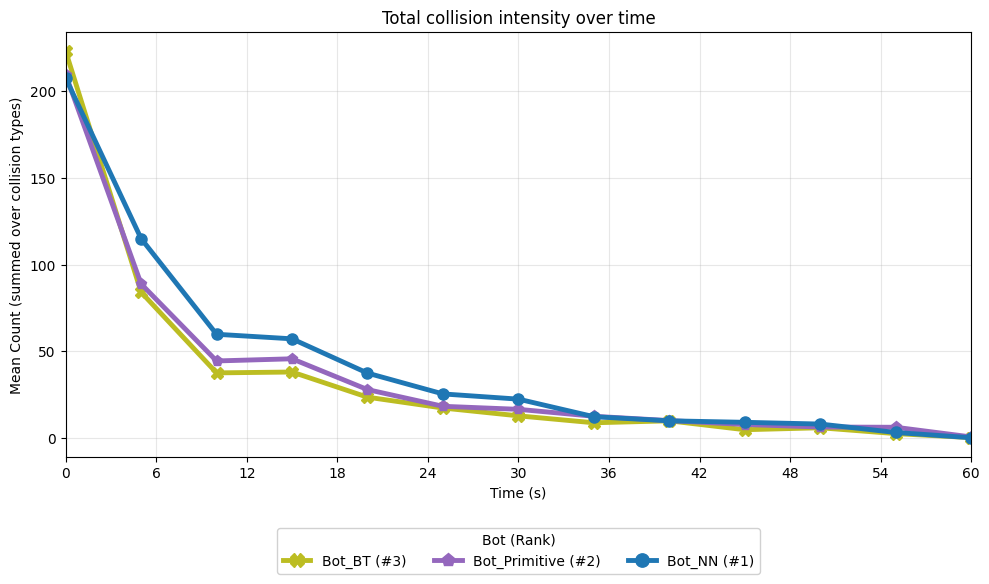

In [79]:
# Total collision intensity
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

In [ ]:
# Per-type collision intensity
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="per_type", timer=60, summary_df=df)
if fig:
    plt.show()

### Action Taken vs. Win Relation

Does spending most action (aggressive) lead to a win?
This taking mean of action-taken per games versus win-rate

In [ ]:
fig = plot_action_win_related(df, width, height)
plt.show()

### Pearson Correlation Analysis (Overall)

Correlation analysis using Pearson coefficient with scatter plots and regression lines.
All data from all bots combined, separated by configuration

In [ ]:
correlation_figs = plot_all_correlations(df, width, height)

## Individual Bot Analysis

Analyze bot agent against its different configurations.
Each of report: Win Rate; Collision; Action-Taken; Duration; is calculated with averaging data from matchup (left and right position)

### Pearson Correlation Analysis (Per Bot)

Detailed plots for individual bots, separated by configuration

In [ ]:
# Get unique bots
bots_list = sorted(df['Bot_L'].unique())
print(f"Analyzing {len(bots_list)} bots: {bots_list}")

# Individual bot correlation analysis
for bot in bots_list:
    print(f"\n{'='*60}")
    print(f"Analyzing correlations for {bot}")
    print(f"{'='*60}")
    
    correlation_figs = plot_individual_bot_correlations(df, bot, width, height)
    
    if not correlation_figs:
        print(f"No data available for {bot}")
        continue
    
    # Win Rate vs ActInterval
    if 'actinterval' in correlation_figs:
        print("\n--- Win Rate vs Action Interval Configuration ---")
        plt.show()
    
    # Win Rate vs Round Type
    if 'roundtype' in correlation_figs:
        print("\n--- Win Rate vs Round Type Configuration ---")
        plt.show()
    
    # Win Rate vs Timer
    if 'timer' in correlation_figs:
        print("\n--- Win Rate vs Timer Configuration ---")
        plt.show()
    
    # Win Rate vs Skill Type
    if 'skilltype' in correlation_figs:
        print("\n--- Win Rate vs Skill Type Configuration ---")
        plt.show()
    
    # Win Rate vs Action Types
    if 'actions' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Types ---")
        plt.show()
    
    # Win Rate vs Action Duration
    if 'actions_dur' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Duration ---")
        plt.show()
    
    # Win Rate vs Collisions
    if 'collisions' in correlation_figs:
        print("\n--- Win Rate vs Collision Types (Hit, Struck, Tie) ---")
        plt.show()

## Arena Heatmaps - Bot Movement Analysis

Visualize bot movement patterns across different game phases (Early, Mid, Late)

In [ ]:
# Check if arena_heatmap directory exists
heatmap_dir = "arena_heatmaps"

if os.path.exists(heatmap_dir):
    # Get all bot directories
    bot_dirs = [d for d in os.listdir(heatmap_dir)
               if os.path.isdir(os.path.join(heatmap_dir, d))]
    
    # Sort bot directories by rank from df_sum
    if "Rank" in df_sum.columns and "Bot" in df_sum.columns:
        rank_map = df_sum.groupby("Bot")["Rank"].first().to_dict()
        bot_dirs = sorted(bot_dirs, key=lambda b: rank_map.get(b, 9999))
    else:
        bot_dirs = sorted(bot_dirs)
    
    if bot_dirs:
        phase_names = ["window_2.5-15s.png", "window_15-30s.png", "window_30-45s.png", "window_45-60s.png"]
        
        # Display heatmaps for each bot
        for bot_name in bot_dirs:
            print(f"\n{'='*60}")
            print(f"{bot_name} (#{bot_dirs.index(bot_name)+1})")
            print(f"{'='*60}")
            bot_dir = os.path.join(heatmap_dir, bot_name)
            
            # Display phase heatmaps
            fig, axes = plt.subplots(1, len(phase_names), figsize=(20, 5))
            for idx, phase_name in enumerate(phase_names):
                image_path = os.path.join(bot_dir, phase_name)
                if os.path.exists(image_path):
                    image = Image.open(image_path)
                    axes[idx].imshow(image)
                    axes[idx].set_title(phase_name)
                    axes[idx].axis('off')
                else:
                    axes[idx].text(0.5, 0.5, f"Image not found:\n{phase_name}",
                                  ha='center', va='center')
                    axes[idx].axis('off')
            plt.tight_layout()
            plt.show()
            
            # Display position distribution
            dist_path = os.path.join(bot_dir, "position_distribution.png")
            if os.path.exists(dist_path):
                print("\nPosition Distribution (X & Y Overlayed)")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()
            
            # Display distance distribution
            dist_path = os.path.join(bot_dir, "distance_distribution.png")
            if os.path.exists(dist_path):
                print("\nDistance Distribution")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()

            print("\nFull Configuration Analysis")
            fig = plot_full_cross_heatmap_half(df, bot_name=bot_name, lower_triangle=True)
            plt.show()
    else:
        print("No bot heatmaps found in directory")
        print("Run: `python detailed_analyzer.py all` to generate heatmaps")
else:
    print(f"Heatmap directory not found: {heatmap_dir}")
    print("Run: `python detailed_analyzer.py all` to generate heatmaps for all bots")